# LATAM Airlines

**"Probabilidad de atraso de los vuelos que aterriza o despegan"**

El problema consiste en predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago de Chile (SCL).

Para eso les entregamos un dataset usando datos públicos y reales donde cada fila corresponde a un vuelo que aterrizó o despegó de SCL.

# Instalar las dependencias


In [ ]:
!pip install -r requirements.txt

# Entendimiento inicial de los datos

## Cargar Librerias

In [ ]:
%matplotlib inline

import re
import random
from collections import Counter

import numpy as np
import pandas as pd
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 1000)

from scipy.stats import kstest

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.preprocessing import StandardScaler, MinMaxScaler,OrdinalEncoder

from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,GridSearchCV,ParameterGrid

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn import metrics as mt
from sklearn.metrics import  roc_curve, auc, silhouette_score, recall_score, precision_score, confusion_matrix, accuracy_score

## Definición de funciones

In [ ]:
def cross_target(data,var,target):
    """Calcula los porcentajes de conversión del target por cada categoria de la variable"""
    
    base = data[[var,target]]#.fillna("NULOS")
    print("----------------------------------------------------------------")
    print("---- Var: ",var)
    print(pd.concat([pd.DataFrame(base[:][var].value_counts(dropna=False).index, columns = ['Atributo']),
           pd.DataFrame(base[:][var].value_counts(dropna=False).values, columns = ['Cantidad']),
           pd.DataFrame(100*base[:][var].value_counts(dropna=False).values/len(base), columns = ['%Total'])], axis = 1))
    
    temp = pd.DataFrame(np.array(base.groupby(var, as_index = False, axis = 0)[target].mean()), 
                         columns = [var,"% ratio_conv"])
    temp["% ratio_conv"] = temp["% ratio_conv"]*100
    temp = temp.sort_values(by = ['% ratio_conv'], ascending = [False])
    print("")
    print(temp)


def plot_graph_initial(df, meta):
  """Graficos para el analisis univariado"""
  
  import matplotlib
  matplotlib.rcParams.update({'font.size': 16})
  for i in range(len(meta)) :
      plt.figure(figsize=(35,7))
      v=meta.iloc[i].variable #print(meta.iloc[i].variable)
      t=meta.iloc[i].tipo
      if (t.__class__.__name__=="CategoricalDtype"):
          fa=df[v].value_counts() 
          fr=fa/len(df[v]) 
          #Barras
          plt.subplot(1,2,1)
          plt.bar(fa.index,fa)
          plt.xticks(fa.index,rotation=90)
          plt.title(v)
          #Pie
          plt.subplot(1,2,2)
          plt.pie(fr,autopct='%1.1f%%', shadow=True, startangle=90)
          plt.legend(fr.index,loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
          plt.title(v)
          #Guardar
          #plt.savefig(v+".jpg")

      else:
          #Histograma
          plt.subplot(1,2,1)
          plt.hist(df[v].dropna(),bins=100)
          plt.title(v)
          #Boxplot
          plt.subplot(1,2,2)
          plt.boxplot(df[v])
          plt.title(v)
          #Guardar
          #plt.savefig(v+".jpg")
      plt.show()



def plot_graph_bivariable(df2, meta, y):
  """Graficos para el analisis bivariado"""
  
  import matplotlib
  matplotlib.rcParams.update({'font.size': 16})
  for i in range(len(meta)) :
      plt.figure(figsize=(35,7))
      v=meta.iloc[i].variable #print(meta.iloc[i].variable)
      t=meta.iloc[i].tipo
      if v==y: break
      print(v)
      if (t.__class__.__name__=="CategoricalDtype"):        
          g=df2.groupby([df2[y],v]).size().unstack(0)
          tf= g[1]/(g[0]+g[1])
          c1 = g[0]
          c2 = g[1]
          width = 0.9   # the width of the bars: can also be len(x) sequence

          p1 = plt.bar(g.index, c1, width)
          p2 = plt.bar(g.index, c2, width,
                       bottom=c1)

          plt.ylabel('Freq')
          plt.title('Bivariado')
          plt.xticks(g.index,rotation=90)
          plt.legend((p1[0], p2[0]), ('0', '1'),loc='lower left',bbox_to_anchor=(1, 1))

          plt.twinx().plot(tf.values,linestyle='-', linewidth=2.0,color='red')
          plt.ylabel(y)
          #Guardar
          #plt.savefig("Bivariado_"+ v + ".jpg")
      else:
          d=pd.qcut(df2[v], 10, duplicates='drop',labels=False)     
          g=df2.groupby([y, d]).size().unstack(0)   
          N = len(g)
          menMeans = g[0]
          womenMeans = g[1]
          tf= g[1]/(g[0]+g[1])
          ind = np.arange(N)    # the x locations for the groups

          width = 0.9       # the width of the bars: can also be len(x) sequence        
          p1 = plt.bar(ind, menMeans, width)
          p2 = plt.bar(ind, womenMeans, width,
                       bottom=menMeans)

          plt.ylabel('Freq')
          plt.xlabel("Deciles " + v)
          plt.title('Bivariado: ' + v + " vs " + y)
          plt.xticks(ind, np.arange(1,10,1),rotation=90)
          plt.legend((p1[0], p2[0]), ('0', '1'),loc='lower left',bbox_to_anchor=(1, 1))

          plt.twinx().plot(tf.values,linestyle='-', linewidth=2.0,color='red')
          plt.ylabel(y)
          #Guardar
          #plt.savefig("Bivariado_"+ v + ".jpg")
      plt.show()



def fx_porc_missings(data, only_missings = False):
    """Calcula los porcentajes de valores vacios en cada variable"""
    
    df_vars_missings = pd.concat([pd.DataFrame(data.isnull().sum(), columns = ['n_nulos']),
           pd.DataFrame(100*data.isnull().sum()/len(data), columns = ['%Total'])], axis = 1)
    if only_missings:
        return(df_vars_missings[df_vars_missings["n_nulos"]!=0])
    else:
        return(df_vars_missings)



def fx_percentiles_en_lista(lista):
    """Calcula los percentiles y lo muestra en un dataframe"""
    
    vector_percentiles = [0,0.5,1,2.5,5,10,25,50,75,90,92.5,95,97.5,98,98.5,99,99.5,100]
    display(pd.concat([pd.DataFrame(vector_percentiles, columns = ['Percentile']),
                     pd.DataFrame(np.nanpercentile(lista, vector_percentiles), 
                                  columns = ['Valor'])], axis = 1))



def clean_outlier_perc(df, column, value_perc):
  """Genera el reemplazo de valores outliers superiores por un percentile personalizado"""
  
  top_value = df[column].quantile(value_perc) 
  df.loc[df[column] >= top_value, column] = top_value



def correlation_heatmap(df):
    """Función para plotear las correlaciones de las variables de un dataset"""
    
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)


def print_mc(matriz_conf):
    """Función para plotear la matriz de confusion"""

    matriz_conf = pd.DataFrame(matriz_conf)
    matriz_conf.index = ["Real_0","Real_1"]
    matriz_conf.columns = ["Pred_0","Pred_1"]
    print(matriz_conf) 
    

def fx_evaluate_classif(y_real, pred, pred_proba):
    """Función para las metricas de evaluación de un modelo de clasificacion"""

    from sklearn import metrics as mt
    matriz_conf = mt.confusion_matrix(y_real,pred)
    print_mc(matriz_conf)
    roc = mt.roc_auc_score(y_real,pred_proba)
    accuracy_real = mt.accuracy_score(y_real,pred)
    print("\nROC-AUC: ", roc) 
    print("Accu:", accuracy_real,'\n')
    print(mt.classification_report(y_real, pred)[0:163])

## Lectura y validación de datos

Ruta donde se encuentra alojado el dataset del caso

In [ ]:
url_data='../data/'

**Lectura y carga de la data**

In [ ]:
dfVuelos=pd.read_csv(url_data+'dataset_SCL.csv', na_values='?', low_memory=False)

**Validar la correcta lectura del dataframe**

Se observa que se tienen **68206 filas** y **18 columnas** de los tipos int64(3), object(15). Se tiene que modificar el tipo de dato de las variables **Fecha-I** y **Fecha-O** para su posterior tratamiento

In [ ]:
dfVuelos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


Mostrar los 5 primeros registros

In [ ]:
dfVuelos.head(5)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


## Estudiar las dimensiones del dataset

In [ ]:
dfVuelos.shape

(68206, 18)

Se tienen 68206 filas y 18 columnas

In [ ]:
dfVuelos.size

1227708

No se tiene un **id** correspondiente a cada vuelo. Como parte de las indicaciones cada fila corresponde a un vuelo que aterrizó o despegó de SCL, por lo que cada fila será tomado como un único registro

## Evaluar el tipo de Problema

**Vemos que es un caso de aprendizaje supervisado de clasificación para predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago de Chile (SCL)**

In [ ]:
dfVuelos.head(3)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami


## Variable Objetivo

**Armado del target**

Se debe construir el target **atraso_15** en base a una nueva variable llamada **dif_min**. La definición del target obedece:

*   dif_min<15    : Si la diferencia en minutos entre Fecha-O y Fecha-I es menor de 15 minutos entonces atraso_15=0
*   dif_min>15    : Si la diferencia en minutos entre Fecha-O y Fecha-I es mayor de 15 minutos entonces atraso_15=1

Finalmente tomando en cuenta una diferencia de 15 min se construye el target **atraso_15**. Esta variable **bivariada** será usada para predecir si un vuelo se retrasa o no.

Se convierten los campos **Fecha-O** y **Fecha-I** en variables del tipo *datetime* para su posterior tratamiento.

In [ ]:
dfVuelos['Fecha-O']=pd.to_datetime(dfVuelos['Fecha-O'])
dfVuelos['Fecha-I']=pd.to_datetime(dfVuelos['Fecha-I'])

Crear la variables **dif_min** tomando las variables **Fecha-O** y **Fecha-I**

In [ ]:
dfVuelos['dif_min']=dfVuelos['Fecha-O']-dfVuelos['Fecha-I']
dfVuelos['dif_min']=dfVuelos['dif_min']/np.timedelta64(1,'m')

Se crea la variable **atraso_15** en base a la variable **dif_min**

In [ ]:
dfVuelos['atraso_15'] = dfVuelos['dif_min'].map(lambda x: '1' if x>15 else '0')

Se valida la cantidad de valores para cada categoría del target. Se observa que 12614 (**~18,4%**) corresponde el target de análisis

In [ ]:
# Validación
dfVuelos['atraso_15'].value_counts()

0    55592
1    12614
Name: atraso_15, dtype: int64

## Describir el Dataset

El primer alcance descriptivo de los datos es el siguiente:

*   **Viernes** es el dia de la semana con más fechas programadas de vuelo. Representa el **15%**

*   **Grupo LATAM** es el operador con la mayor cantidad de vuelos operados. Representa el **60%**.

*   **TIPOVUELO**. Los vuelos Nacionales(N) representan el **54%** del total de vuelos

*   **SIGLAORI**. Todos los vuelos salen de la ciudad de Santiago, esta variable con una única categoría será eliminada posteriormente ya que por tener **cero varianza** no aporta en el proceso de aprendizaje.

*   La variable **Vlo-O** tiene un valor nulo, el resto de variables no tiene valores vacios.

*   **DIANOM** que obedece al día de la semana es correspondiente al valor de la variable **DIA**. Para fines descriptivos se usará **DIANOM**

*   **MES** y **AÑO** necesitan ser transformados en variables categóricas, con ello  la posibilidad de conocer el mes y el año que tiene menos y más vuelos programados y operados.


In [ ]:
dfVuelos.describe(include =['int64','object','float64'])

,Vlo-I,Ori-I,Des-I,Emp-I,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,dif_min,atraso_15
count,68206,68206,68206,68206,68205,68206,68206,68206,68206.000000,68206.000000,68206.000000,68206,68206,68206,68206,68206,68206.000000,68206
unique,584,1,64,30,861,1,63,32,NaN,NaN,NaN,7,2,23,1,62,NaN,2
top,174,SCEL,SCFA,LAN,174,SCEL,SCFA,LAN,NaN,NaN,NaN,Viernes,N,Grupo LATAM,Santiago,Buenos Aires,NaN,0
freq,686,68206,5787,37611,649,68206,5786,20988,NaN,NaN,NaN,10292,36966,40892,68206,6335,NaN,55592
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.714790,6.622585,2017.000029,NaN,NaN,NaN,NaN,NaN,9.110855,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.782886,3.523321,0.005415,NaN,NaN,NaN,NaN,NaN,19.313387,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,2017.000000,NaN,NaN,NaN,NaN,NaN,-14.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,3.000000,2017.000000,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.000000,7.000000,2017.000000,NaN,NaN,NaN,NaN,NaN,4.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,10.000000,2017.000000,NaN,NaN,NaN,NaN,NaN,12.000000,NaN


# Data Wrangling

## Registros Repetidos

In [ ]:
dfVuelos.shape

(68206, 21)

In [ ]:
dfVuelos.drop_duplicates(inplace = True)

In [ ]:
dfVuelos.shape

(68206, 21)

## Renombramiento de variables

In [ ]:
dfVuelos.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES', 'dif_min', 'atraso_15'],
      dtype='object')

Se renombra las variables para un mejor entendimiento

In [ ]:
dfVuelos.rename(columns={
   'Fecha-I':'fecVuelProg',
   'Vlo-I':'nroVuelProg',
   'Ori-I': 'codCiudadOrigProg',
   'Des-I': 'codCiudadDestProg',
   'Emp-I': 'codAerolineaVuelProg',
   'Fecha-O':'fecVuelOperado',
   'Vlo-O':'nroVuelOperado',
   'Ori-O': 'codCiudadOrigOperado',
   'Des-O': 'codCiudadDestOperado',
   'Emp-O': 'codAerolineaVuelOperado',
   'DIA': 'diaVuelOperado',
   'MES': 'mesVuelOperado',
   'AÑO': 'anioVuelOperado',
   'DIANOM':'diaSemVuelOperado',
   'TIPOVUELO': 'tipVuelo',
   'OPERA': 'nombAerolineaOperado',
   'SIGLAORI': 'nombCiudadOrig',
   'SIGLADES': 'nombCiudadDest'},inplace=True)

In [ ]:
dfVuelos.columns

Index(['fecVuelProg', 'nroVuelProg', 'codCiudadOrigProg', 'codCiudadDestProg',
       'codAerolineaVuelProg', 'fecVuelOperado', 'nroVuelOperado',
       'codCiudadOrigOperado', 'codCiudadDestOperado',
       'codAerolineaVuelOperado', 'diaVuelOperado', 'mesVuelOperado',
       'anioVuelOperado', 'diaSemVuelOperado', 'tipVuelo',
       'nombAerolineaOperado', 'nombCiudadOrig', 'nombCiudadDest', 'dif_min',
       'atraso_15'],
      dtype='object')

## Remover nulos

In [ ]:
fx_porc_missings(dfVuelos, only_missings=True)

,n_nulos,%Total
nroVuelOperado,1,0.001466


La variable **nroVuelOperado** es una variable cualitativa. Para este caso se **imputa por su moda**

In [ ]:
dfVuelos['nroVuelOperado'].mode()[0]

'174'

In [ ]:
dfVuelos['nroVuelOperado'].fillna(dfVuelos['nroVuelOperado'].mode()[0],inplace=True)

Se observan que todo el dataframe no contiene variables con valores nulos

In [ ]:
fx_porc_missings(dfVuelos, only_missings=True)

,n_nulos,%Total


## Creación de nuevas variables

En este paso se crear las dos variables restantes solicitadas en el desafío: **temporada_alta** y **periodo_dia**, con el fin de darles posterior tratamiento. Las variables **dif_min** y **atraso_15** han sido creadas en la sección **Variable Objetivo**

### Se crea la variable **temporada_alta**

In [ ]:
dfVuelos["temporada_alta"]='0'

cond1 =( (dfVuelos['fecVuelProg'] >= dfVuelos['fecVuelProg'].dt.year.apply(str) + '-12-15') & \
 (dfVuelos['fecVuelProg']  <= dfVuelos['fecVuelProg'].dt.year.apply(lambda x: x+1).apply(str) + '-03-03') )
cond2 = ( (dfVuelos['fecVuelProg'] >= dfVuelos['fecVuelProg'].dt.year.apply(str) + '-07-15') & \
 (dfVuelos['fecVuelProg']  <= dfVuelos['fecVuelProg'].dt.year.apply(str) + '-07-31') )
cond3 = ( (dfVuelos['fecVuelProg'] >= dfVuelos['fecVuelProg'].dt.year.apply(str) + '-09-11') & \
 (dfVuelos['fecVuelProg']  <= dfVuelos['fecVuelProg'].dt.year.apply(str) + '-09-30') )
dfVuelos.loc[(cond1 | cond2 | cond3) , 'temporada_alta'] = '1'

In [ ]:
# Validación
dfVuelos['temporada_alta'].value_counts()

0    58051
1    10155
Name: temporada_alta, dtype: int64

### Se crea la variable **periodo_dia**

In [ ]:
dfVuelos['periodo_dia'] = ""

index = pd.DatetimeIndex(dfVuelos['fecVuelProg'])
dfVuelos.loc[index.indexer_between_time('5:00','11:59'),"periodo_dia"]="mañana"
dfVuelos.loc[index.indexer_between_time('12:00','18:59'),"periodo_dia"]="tarde"
dfVuelos.loc[index.indexer_between_time('19:00','04:59'),"periodo_dia"]="noche"

Validación para ver si las horas corresponden correctamente con la variable **periodo_dia** creada

In [ ]:
dfVuelos['horaFecI']=dfVuelos['fecVuelProg'].dt.hour
dfVuelos.groupby(by=['periodo_dia','horaFecI']).size()

periodo_dia  horaFecI
mañana       5           2514
             6           4199
             7           4882
             8           4363
             9           3264
             10          2462
             11          3668
noche        0           1082
             1           1573
             2            641
             3            505
             4           1092
             19          3591
             20          2935
             21          2312
             22          2320
             23          1297
tarde        12          3412
             13          3675
             14          3836
             15          3884
             16          3072
             17          3465
             18          4162
dtype: int64

Se verifica que las horas corresponden de manera correcta con las partes del día.

In [ ]:
dfVuelos["periodo_dia"].value_counts(normalize = True)*100

tarde     37.395537
mañana    37.169750
noche     25.434712
Name: periodo_dia, dtype: float64

Se observa que se tiene un porcentaje menor (**~25%**) de personas que vuelan durante la noche. Siendo un porcentaje mayor durante la mañana y la tarde

### Exportar las variables creadas

Se guarda y se exporta los variables creadas en el archivo **synthetic_features.csv**. Se mantiene el index para posteriores cruces

In [ ]:
dfVuelos[['temporada_alta','dif_min','atraso_15','periodo_dia']].to_csv(url_data+'synthetic_features.csv',sep=',')

In [ ]:
dfVuelos.head(5)

,fecVuelProg,nroVuelProg,codCiudadOrigProg,codCiudadDestProg,codAerolineaVuelProg,fecVuelOperado,nroVuelOperado,codCiudadOrigOperado,codCiudadDestOperado,codAerolineaVuelOperado,diaVuelOperado,mesVuelOperado,anioVuelOperado,diaSemVuelOperado,tipVuelo,nombAerolineaOperado,nombCiudadOrig,nombCiudadDest,dif_min,atraso_15,temporada_alta,periodo_dia,horaFecI
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,3.0,0,0,noche,23
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami,9.0,0,0,noche,23
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami,9.0,0,0,noche,23
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami,3.0,0,0,noche,23
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami,-2.0,0,0,noche,23


Eliminar la variable **horaFecI** que no será empleada para el análisis posterior

In [ ]:
dfVuelos.drop('horaFecI', axis=1, inplace=True)

# EDA

## Analisis Preliminar Univariado

In [ ]:
df_analisis = dfVuelos.copy()

In [ ]:
df_analisis.head(5)

,fecVuelProg,nroVuelProg,codCiudadOrigProg,codCiudadDestProg,codAerolineaVuelProg,fecVuelOperado,nroVuelOperado,codCiudadOrigOperado,codCiudadDestOperado,codAerolineaVuelOperado,diaVuelOperado,mesVuelOperado,anioVuelOperado,diaSemVuelOperado,tipVuelo,nombAerolineaOperado,nombCiudadOrig,nombCiudadDest,dif_min,atraso_15,temporada_alta,periodo_dia
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,3.0,0,0,noche
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami,9.0,0,0,noche
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami,9.0,0,0,noche
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami,3.0,0,0,noche
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami,-2.0,0,0,noche


### Origen de los vuelos

Se realiza el análisis de las siguientes variables:

* **codCiudadOrigProg**
* **codCiudadOrigOperado**
* **nombCiudadOrig**

In [ ]:
df_analisis[['codCiudadOrigProg','codCiudadOrigOperado','nombCiudadOrig']].describe(include='all')

,codCiudadOrigProg,codCiudadOrigOperado,nombCiudadOrig
count,68206,68206,68206
unique,1,1,1
top,SCEL,SCEL,Santiago
freq,68206,68206,68206


Algunas consideraciones relacionadas con las variables:

- **Todos los vuelos parten de Santiago de Chile**. No existen cambios en el origen de los vuelos operados con respecto a los vuelos programados.
- Las variables: **codCiudadOrigProg** y **codCiudadOrigOperado** que describen el código de ciudad de origen programado y codigo de ciudad de origen de operación por tener un único valor se comportan como una **columna constante de varianza nula**, en ese sentido, esta columna será eliminada posteriormente ya que no aporta en la diferenciación de una clase(1) con otra(0). 
- El origen del vuelo programado y operado es el mismo, lo que evidencia que se realiza lo programado
- Nos quedaremos con **nombCiudadOrig** para el análisis exploratorio de los datos, sin embargo para el entrenamiento del modelo será igualmente eliminada, por ser una **columna constante de varianza nula**

In [ ]:
df_analisis.drop('codCiudadOrigProg', axis=1, inplace=True)
df_analisis.drop('codCiudadOrigOperado', axis=1, inplace=True)

**Número de vuelos por Origen**

Como se menciona **Todos los vuelos parten de Santiago de Chile**. No existen cambios en el origen de los vuelos operados con respecto a los vuelos programados.

### Destino de los Vuelos

Se realiza el análisis de las siguientes variables:

* **codCiudadDestProg**
* **codCiudadDestOperado**
* **nombCiudadDest**

In [ ]:
df_analisis[['codCiudadDestProg','codCiudadDestOperado','nombCiudadDest']].describe(include='all')

,codCiudadDestProg,codCiudadDestOperado,nombCiudadDest
count,68206,68206,68206
unique,64,63,62
top,SCFA,SCFA,Buenos Aires
freq,5787,5786,6335


In [ ]:
groupped_data = df_analisis.groupby(['nombCiudadDest','codCiudadDestProg','codCiudadDestOperado']).agg({'atraso_15': 'count'})
groupped_data["%"] = groupped_data.apply(lambda x:  100*x / x.sum())
groupped_data

,,,atraso_15,%
nombCiudadDest,codCiudadDestProg,codCiudadDestOperado,,
Antofagasta,SCFA,SCFA,5786,8.483125
Arica,SCAR,SCAR,2436,3.571533
Asuncion,SGAS,SGAS,232,0.340146
Atlanta,KATL,KATL,358,0.524881
Auckland N.Z.,NZAA,NZAA,361,0.529279
Balmaceda,SCBA,SCBA,839,1.230097
Bariloche,SAZS,SAZS,2,0.002932
Bogota,SKBO,SKBO,1604,2.351699
Buenos Aires,SABE,SABE,3090,4.530393


Algunas consideraciones relacionadas con las variables:

- Existen algunos cambios en el **destino** de los vuelos operados con respecto a los vuelos programados
- Algunas **ciudades de destino** agrupan uno o más codigos de destino programado y operado

**Número de vuelos por Destino**

In [ ]:
groupped_data = df_analisis.groupby(['nombCiudadDest'],as_index=False).agg({'atraso_15': 'count'})
groupped_data.rename(columns={'atraso_15':'cantidad'},inplace=True)
groupped_data.sort_values(by=['cantidad'],ascending=False,inplace=True)
groupped_data["%"] = groupped_data['cantidad']/len(df_analisis)*100
groupped_data.head(5)

,nombCiudadDest,cantidad,%
8,Buenos Aires,6335,9.288039
0,Antofagasta,5786,8.483125
28,Lima,5270,7.726593
9,Calama,5146,7.544791
42,Puerto Montt,4357,6.388001


In [ ]:
groupped_data.tail(5)

,nombCiudadDest,cantidad,%
12,Cataratas Iguacu,2,0.002932
41,"Pisco, Peru",1,0.001466
44,Puerto Stanley,1,0.001466
15,Cochabamba,1,0.001466
61,Washington,1,0.001466


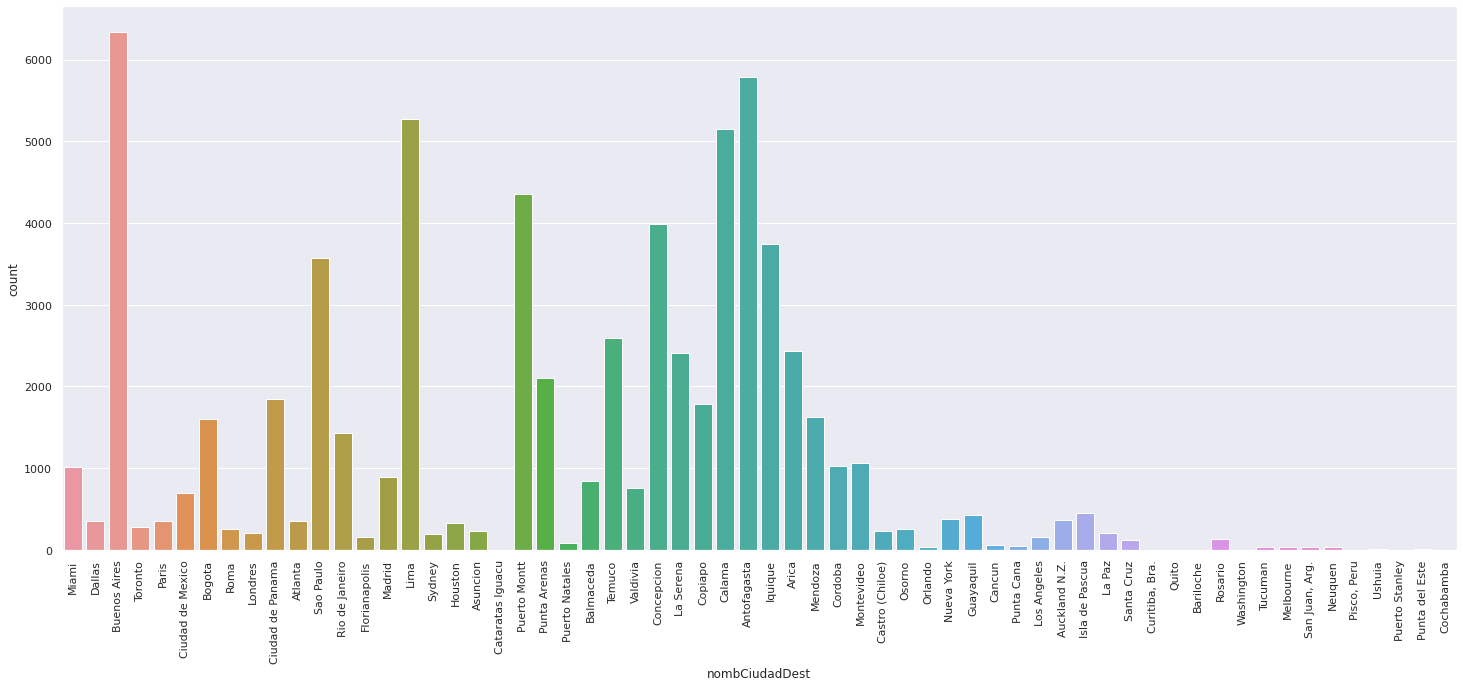

In [ ]:
plt.figure(figsize=(25,10))
sns.countplot(x='nombCiudadDest', data=df_analisis)
plt.xticks(rotation=90)
plt.show()

- Los destinos más frecuentes son **Buenos Aires(9,2%), Antofagasta(8.4%), Lima(7.7%) y Calama(7.5%)**. Estas ciudades se encuentran dentro de los países: **Argentina, Chile y Perú**
- Los destinos menos frecuentes son **Washington, Pisco - Peru, Puerto Stanley y Cochabamba**


**Agrupación de las ciudades en PAIS, REGION**

In [ ]:
#Pendiente
#Crear una nueva variable
#Se debe relacionar esto con respecto al origen y destino. Esto permite mirar la frecuencia de un lugar a otro. Mirar cuales son las conexiones más frecuentes

### Número de vuelos por año, mes y dia de la semana

**Vuelos por año**

In [ ]:
df_analisis.anioVuelOperado.value_counts()

2017    68204
2018        2
Name: anioVuelOperado, dtype: int64

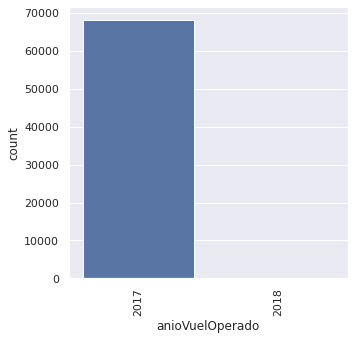

In [ ]:
plt.figure(figsize=(5,5))
sns.countplot(x='anioVuelOperado',data=df_analisis)
plt.xticks(rotation=90)
plt.show()

In [ ]:
df_analisis.anioVuelOperado.value_counts(normalize = True)*100

2017    99.997068
2018     0.002932
Name: anioVuelOperado, dtype: float64

Se observa que la mayor cantidad de vuelos operados corresponden al año 2017. Esta variable se puede considerar así mismo como una **columna constante de varianza nula** ya que el 99.99% de sus valores se encuentran sobre una única categoria por lo que será eliminado.

In [ ]:
df_analisis.drop('anioVuelOperado', axis=1, inplace=True)

**Vuelos por mes**

In [ ]:
df_analisis.mesVuelOperado.value_counts(normalize = True)*100

12    9.318828
1     8.955224
11    8.914172
10    8.843797
7     8.785151
8     8.421546
9     8.225083
2     8.153242
3     8.037416
5     7.682609
4     7.360056
6     7.302877
Name: mesVuelOperado, dtype: float64

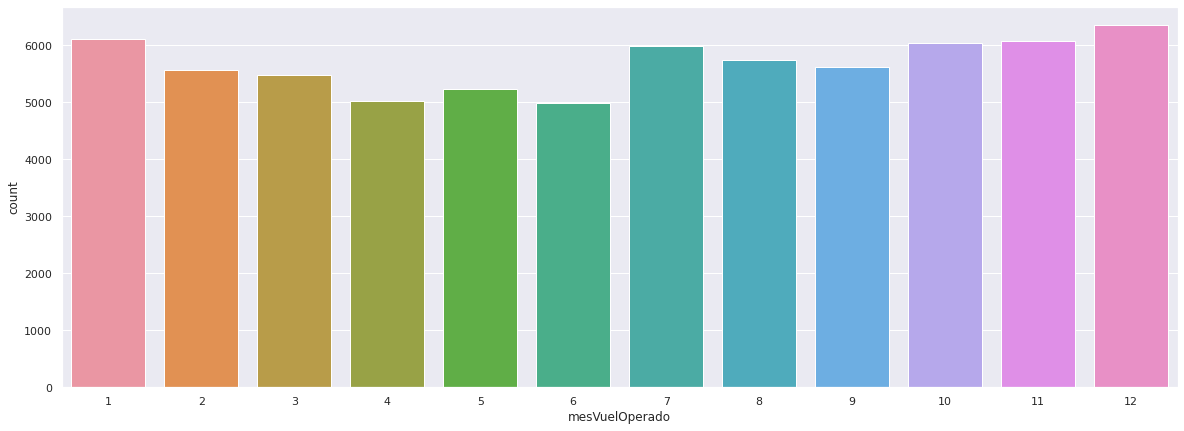

In [ ]:
plt.figure(figsize=(20,7))
sns.countplot(x='mesVuelOperado',data=df_analisis)
plt.show()

Se observa lo siguiente:

*   **Enero** y **Diciembre** son los meses con la mayor cantidad de vuelos operados
*   **Abril** y **Junio** registran la menor cantidad de vuelos operados
*   **Enero**, **Julio** y **Diciembre** registran una subida en el número de vuelos operados con respecto a los meses anteriores.
*   El último trimestre del año (Oct. Nov. Dic.) tiene un mayor número de vuelos operados con respecto al resto de trimestres
*   El segundo trimestre del año (Abr. May. Jun.) tiene el menor número de vuelos operados




**Vuelos por día de la semana**

In [ ]:
df_analisis.diaSemVuelOperado.value_counts(normalize = True)*100

Viernes      15.089582
Jueves       15.029470
Lunes        14.853532
Domingo      14.362373
Miercoles    14.253878
Martes       14.165909
Sabado       12.245257
Name: diaSemVuelOperado, dtype: float64

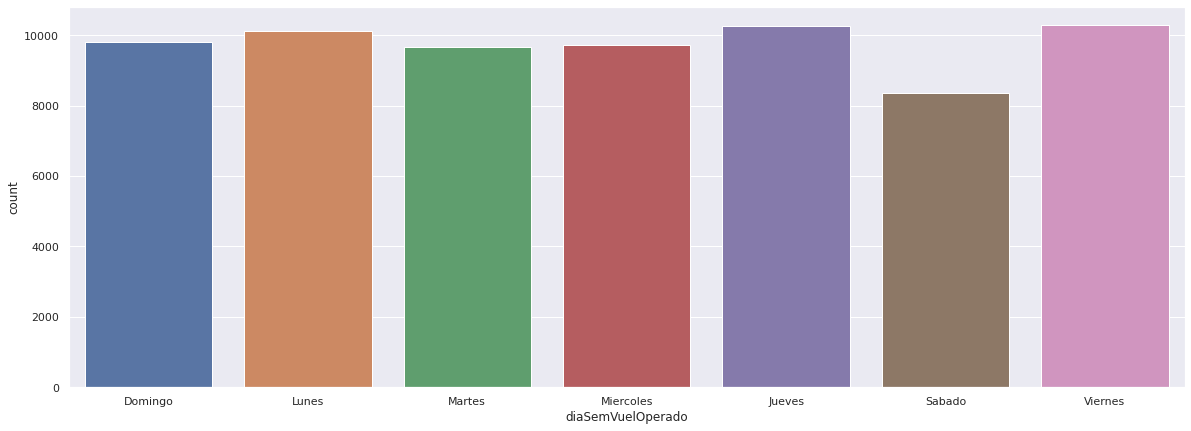

In [ ]:
plt.figure(figsize=(20,7))
sns.countplot(x='diaSemVuelOperado',data=df_analisis)
plt.show()

Se observa lo siguiente:
- Los **Sábados** es el dia con la menor cantidad de vuelos. Representa el **12.2%** de los vuelos operados
- Los **Jueves** y **Viernes** son los días con la mayor cantidad de vuelos. Cada uno representa más del **15%**.

### Número de vuelos por tipo y nombre de la aerolínea

**Vuelos por tipo de vuelo**

In [ ]:
df_analisis.tipVuelo.value_counts(normalize = True)*100

N    54.197578
I    45.802422
Name: tipVuelo, dtype: float64

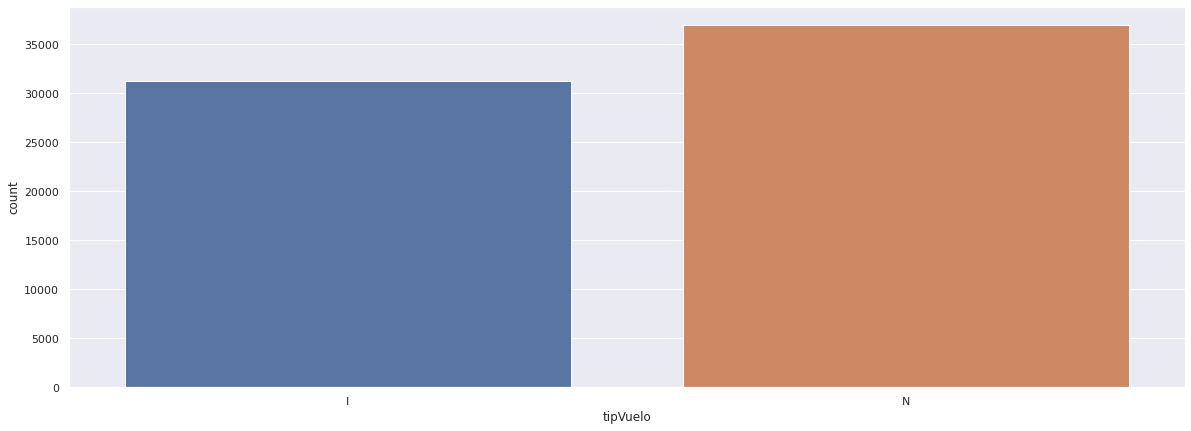

In [ ]:
plt.figure(figsize=(20,7))
sns.countplot(x='tipVuelo',data=df_analisis)
plt.show()

Del total de vuelos operados el **54%** corresponde a los vuelos **Nacionales** (36966), 10% más que los vuelos Internacionales (31240).

**Vuelos por nombre de la aerolínea que opera**

In [ ]:
df_analisis.nombAerolineaOperado.value_counts(normalize = True)*100

Grupo LATAM                 59.953670
Sky Airline                 20.962965
Aerolineas Argentinas        2.857520
Copa Air                     2.712371
Latin American Wings         2.454330
Avianca                      1.689001
JetSmart SPA                 1.605431
Gol Trans                    1.181714
American Airlines            1.109873
Air Canada                   0.828373
Iberia                       0.530745
Delta Air                    0.524881
Air France                   0.524881
Aeromexico                   0.514617
United Airlines              0.491159
Oceanair Linhas Aereas       0.409055
Alitalia                     0.379732
K.L.M.                       0.368003
British Airways              0.300560
Qantas Airways               0.285899
Lacsa                        0.134885
Austral                      0.108495
Plus Ultra Lineas Aereas     0.071841
Name: nombAerolineaOperado, dtype: float64

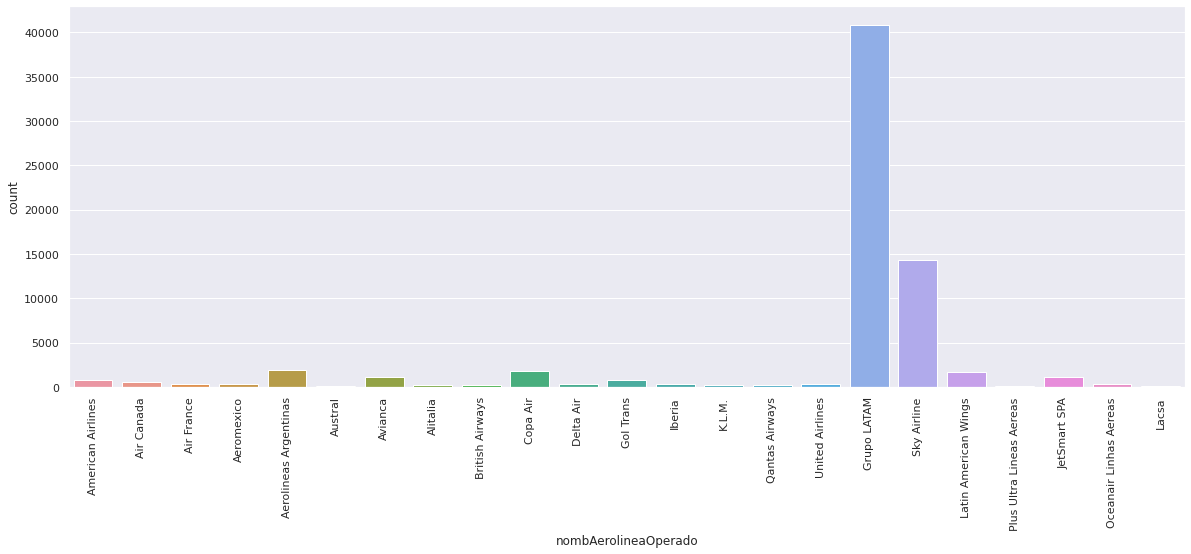

In [ ]:
plt.figure(figsize=(20,7))
sns.countplot(x='nombAerolineaOperado',data=df_analisis)
plt.xticks(rotation=90)
plt.show()

Se observa lo siguiente:
- La aerolinea con más vuelos es el **Grupo LATAM** con 40892 vuelos, esto representa el **59.9%** del total de vuelos operados. Seguido de **Sky Airlines** con el **20.9%**.
- **Más del 80%** del total de vuelos operados está conformado por las aerolíneas Grupo LATAM y Sky Airlines.
- **Cerca de 10%** está conformado por Aerolineas Argentinas (2.85%), Copa Air (2.7%), Latin American Wings (2.4%), Avianca (1.6%).

### Número de vuelos por temporada y periodo

**Vuelos por temporada**

In [ ]:
df_analisis.temporada_alta.value_counts(normalize = True)*100

0    85.111281
1    14.888719
Name: temporada_alta, dtype: float64

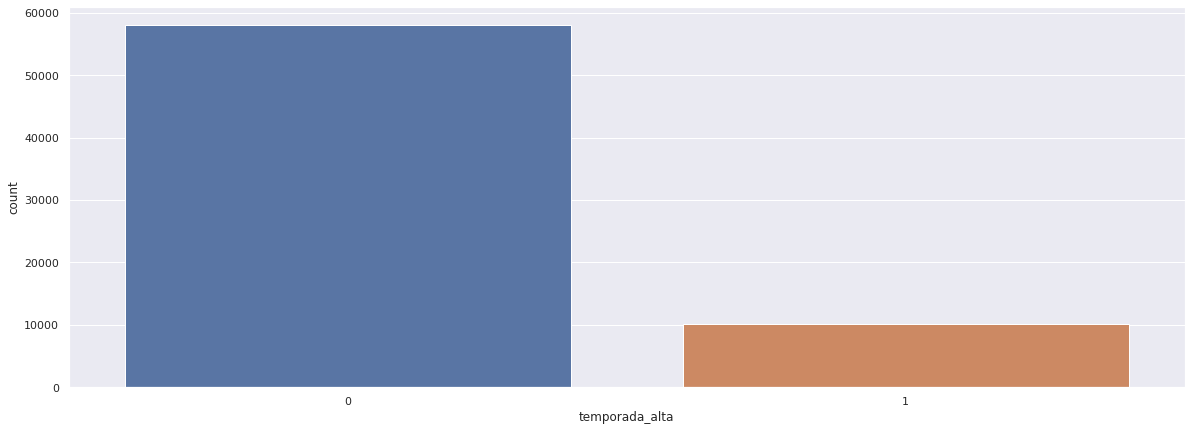

In [ ]:
plt.figure(figsize=(20,7))
sns.countplot(x='temporada_alta',data=df_analisis)
plt.show()

Se observa que el **85.11%** de los vuelos no se realizan en temporada alta, es decir entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep.

**Vuelos por periodo dia**

In [ ]:
df_analisis.periodo_dia.value_counts(normalize = True)*100

tarde     37.395537
mañana    37.169750
noche     25.434712
Name: periodo_dia, dtype: float64

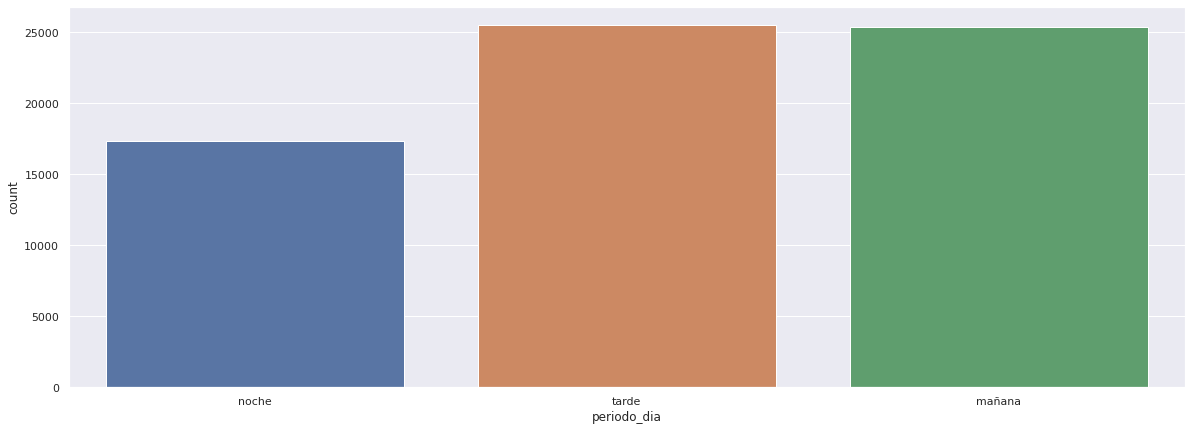

In [ ]:
plt.figure(figsize=(20,7))
sns.countplot(x='periodo_dia',data=df_analisis)
plt.show()

Se observa que se tiene un porcentaje menor **(25.4%)** de personas que vuelan durante la **noche**. Siendo un porcentaje **mayor** durante la **mañana** y la **tarde**

### Distribución de la tasa de retraso (min)

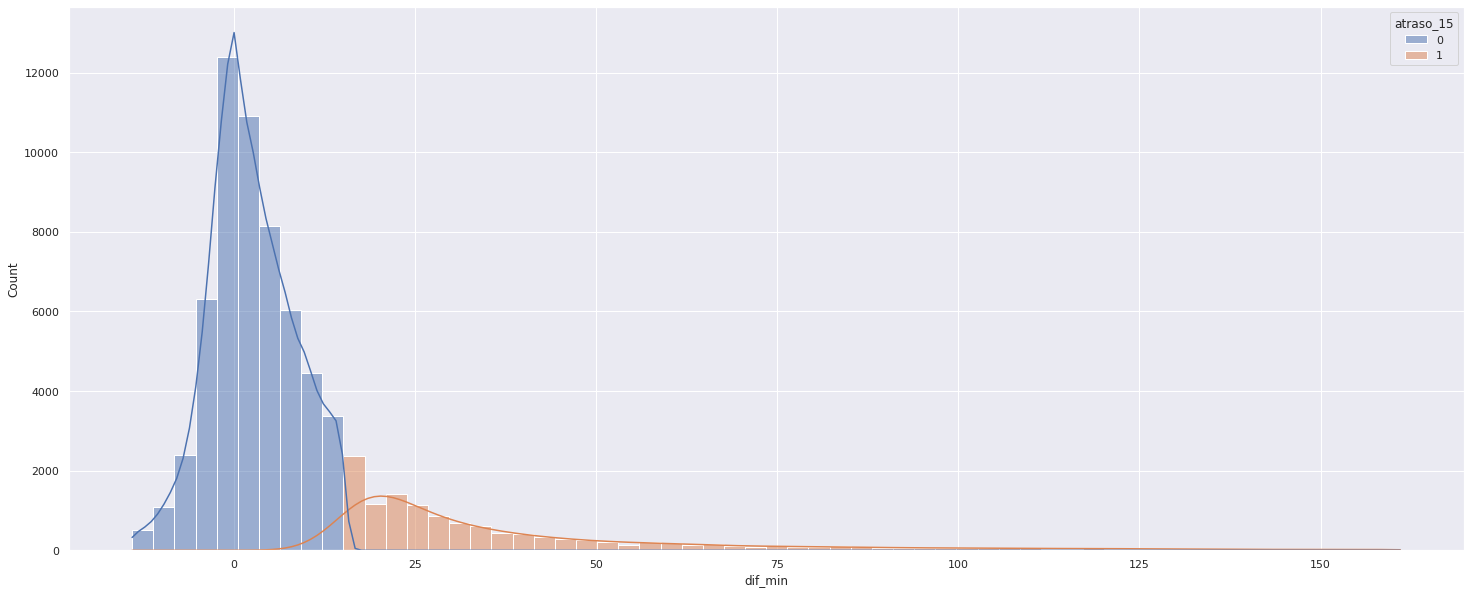

In [ ]:
plt.figure(figsize=(25,10))
sns.histplot(data=df_analisis, x='dif_min',kde=True,hue='atraso_15',bins=60)
plt.show()

Se observa lo siguiente:
- La variable **dif_min** presenta un histograma asimetrico con cola hacia la derecha, lo que evidencia que se tiene la presencia de pocos altos valores de retraso de un vuelo.
- La diferencia en minutos para la variable **atraso_15** de **valor igual a 1**, tiene un histograma achatado asimetrico de cola hacia a la derecha, lo que evidencia que se tiene la presencia de pocos altos valores de retraso de un vuelo. Esto genera una alta desviación estandar con respecto a la media.
- La diferencia en minutos para la variable **atraso_15** de **valor igual a 0**, tiene un histograma apuntado con baja desviación estandar ya que sus valores se encuentran concentrados cerca de la media.
- La desviación estandar de la variable **atraso_15** de **valor igual a 0** es mayor que la variable **atraso_15** de **valor igual a 1**, esto evidencia una mayor variabilidad en cuanto a sus valores con respecto a la media para los vuelos retrasados.

### Reporte Univariado

Se realiza la conversión en los tipos de datos para realizar el reporte univariado

In [ ]:
df_analisis_uni = df_analisis.copy()

In [ ]:
feat_numerical_uni = ['dif_min']

feat_categorical_uni = [
 'codCiudadDestProg',
 'codAerolineaVuelProg',
 'codCiudadDestOperado',
 'codAerolineaVuelOperado',
 'diaSemVuelOperado',
 'mesVuelOperado',
 'tipVuelo',
 'nombAerolineaOperado',
 'nombCiudadDest',
 'atraso_15',
 'temporada_alta',
 'periodo_dia']

In [ ]:
for var in feat_categorical_uni:
  df_analisis_uni[var] = df_analisis_uni[var].astype('category')

In [ ]:
v=pd.DataFrame({"variable": df_analisis_uni.columns.values})
t=pd.DataFrame({"tipo": df_analisis_uni.dtypes.values})
meta=pd.concat([v, t], axis=1)
meta=meta.loc[(meta['tipo']=='category')|(meta['tipo']=='float64'),:]
meta

,variable,tipo
2,codCiudadDestProg,category
3,codAerolineaVuelProg,category
6,codCiudadDestOperado,category
7,codAerolineaVuelOperado,category
9,mesVuelOperado,category
10,anioVuelOperado,category
11,diaSemVuelOperado,category
12,tipVuelo,category
13,nombAerolineaOperado,category
14,nombCiudadOrig,category


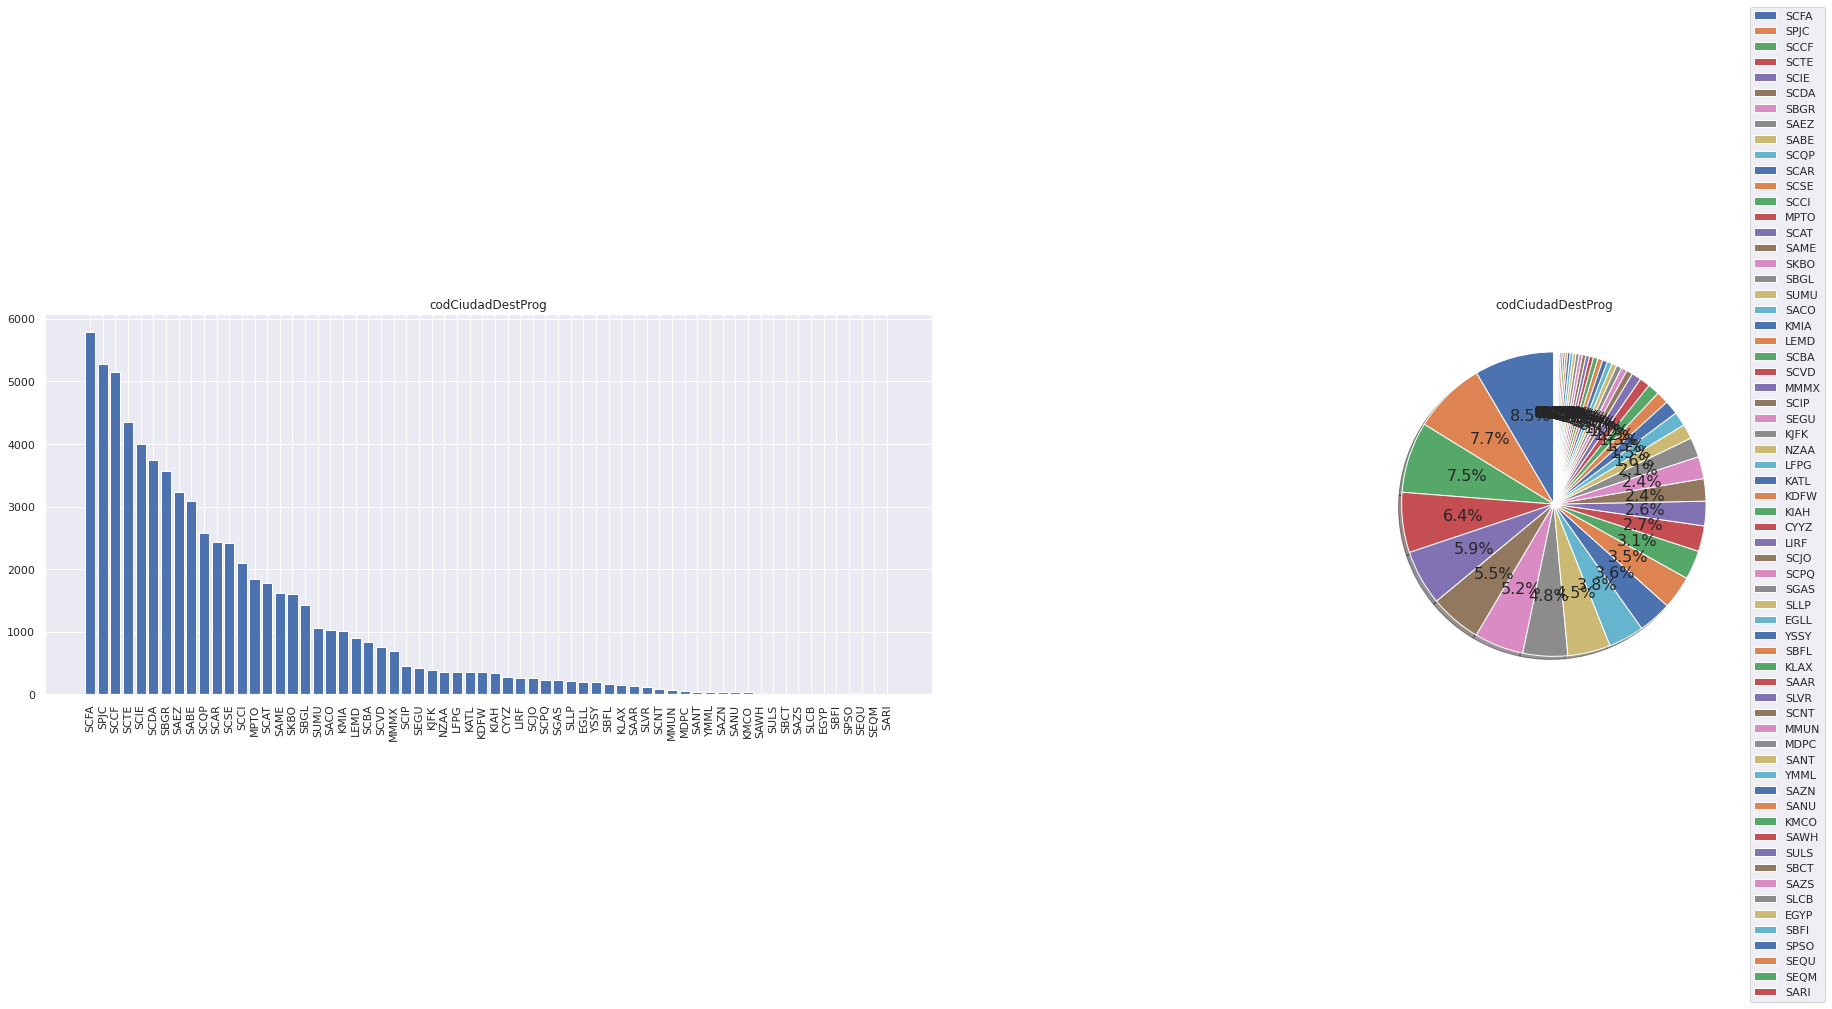

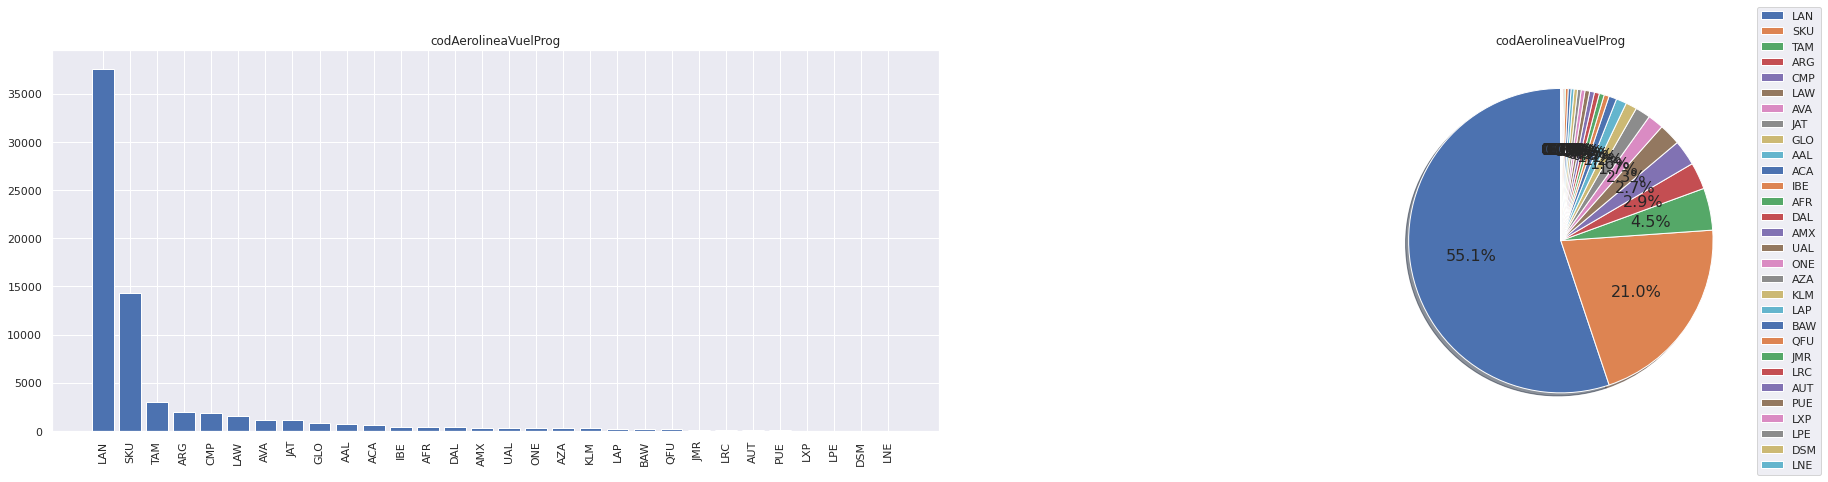

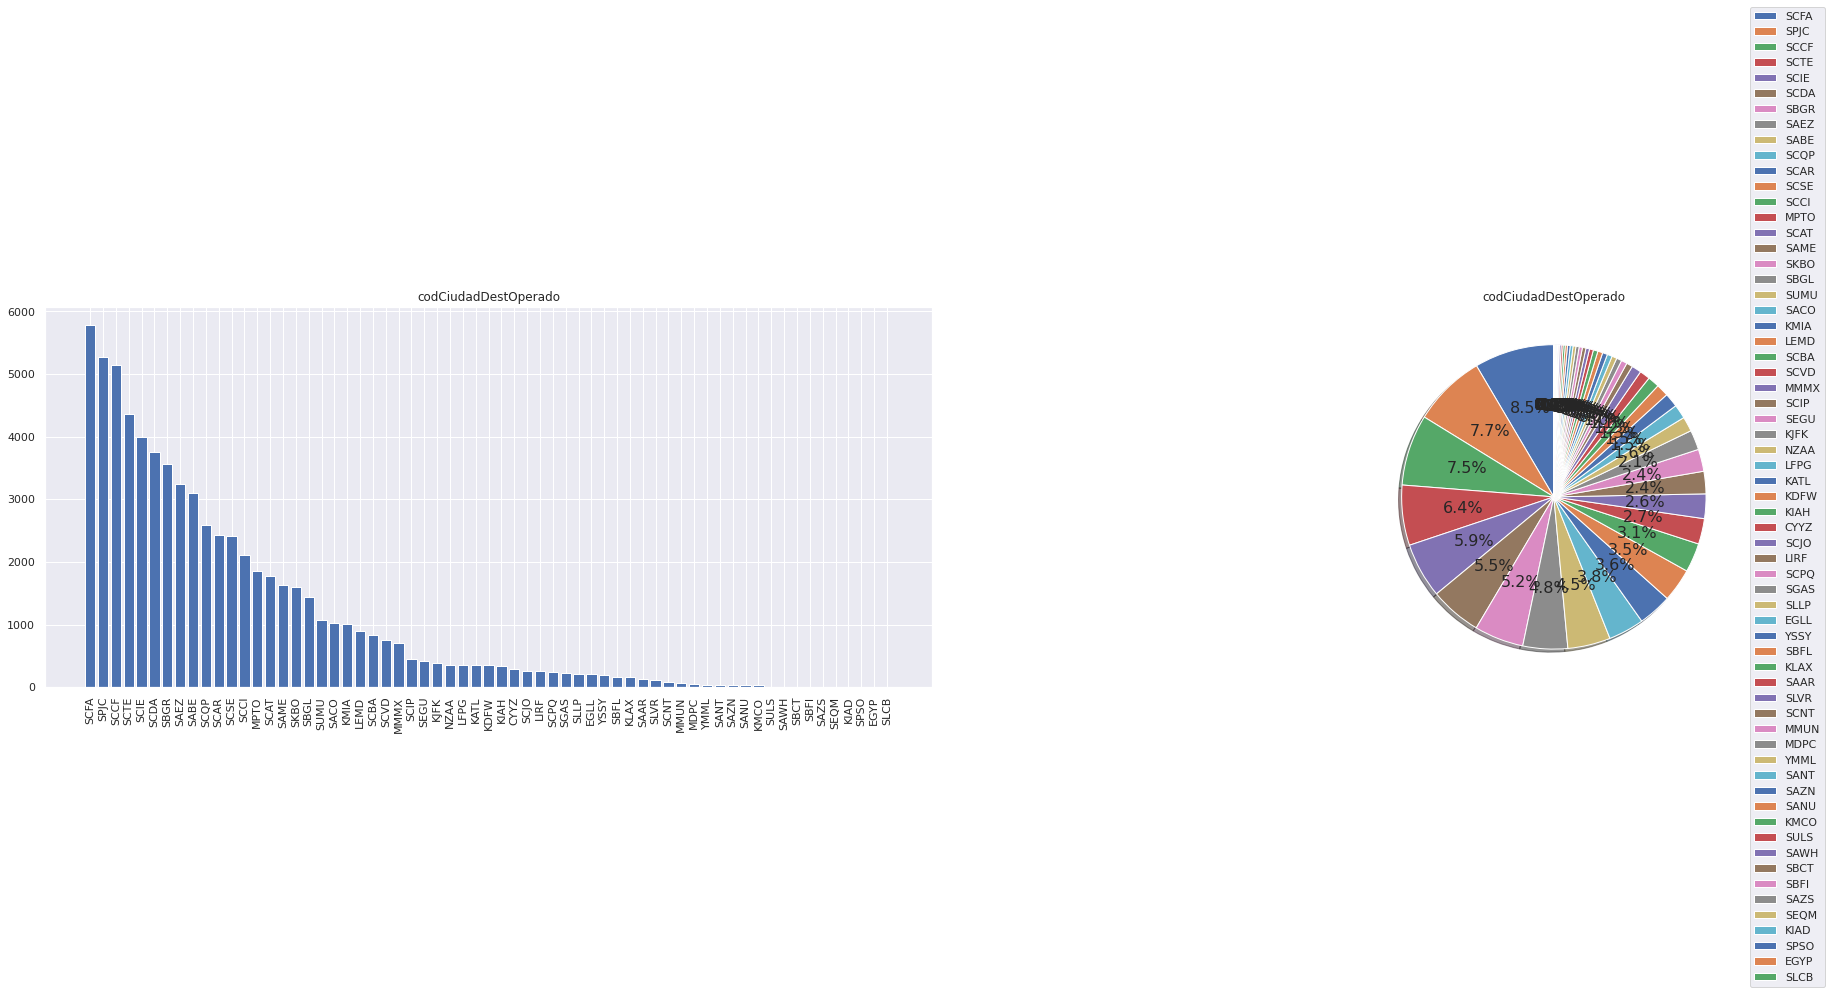

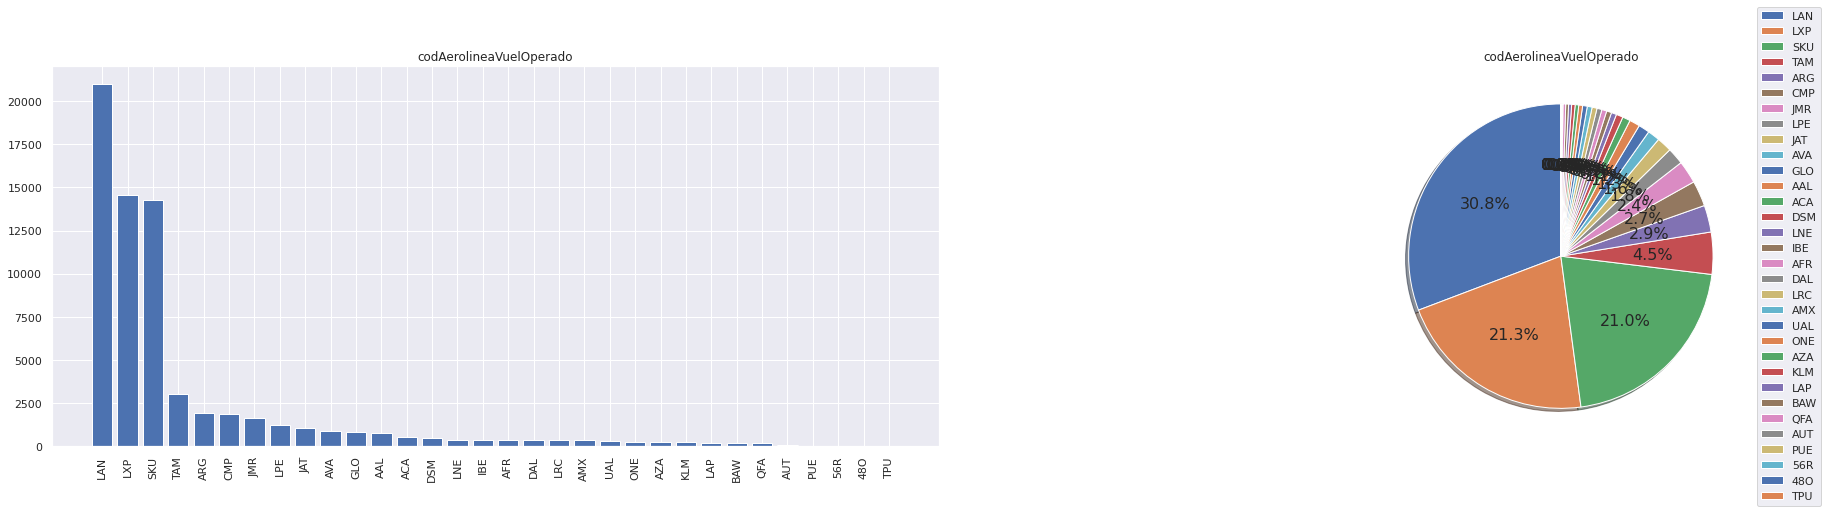

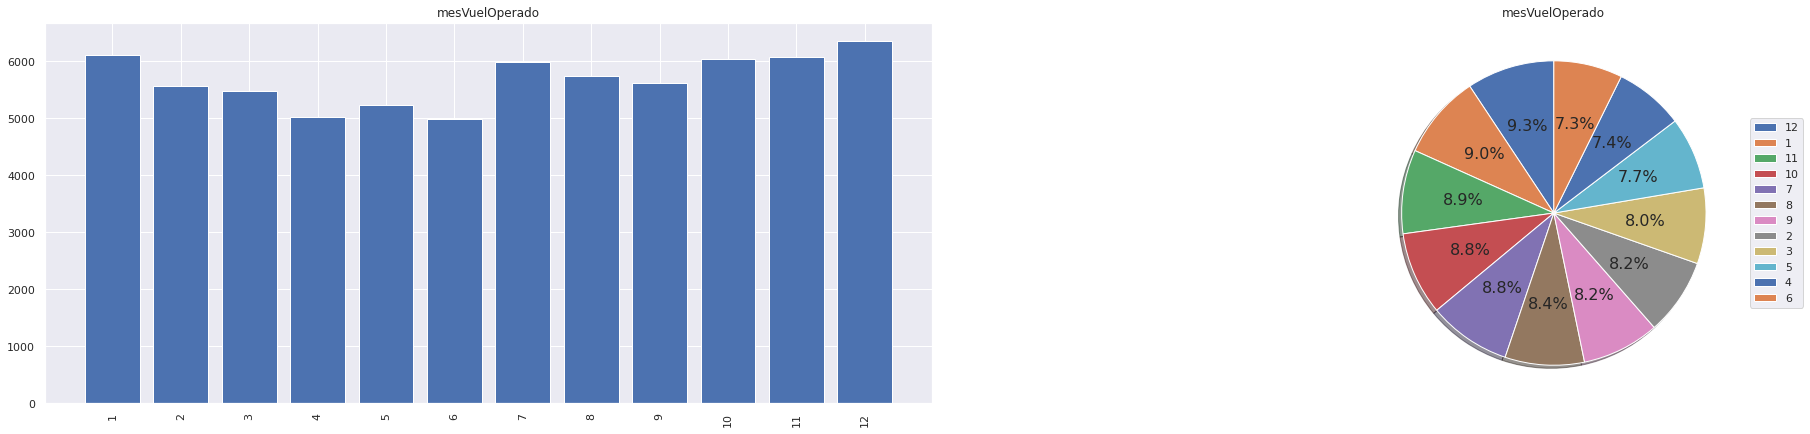

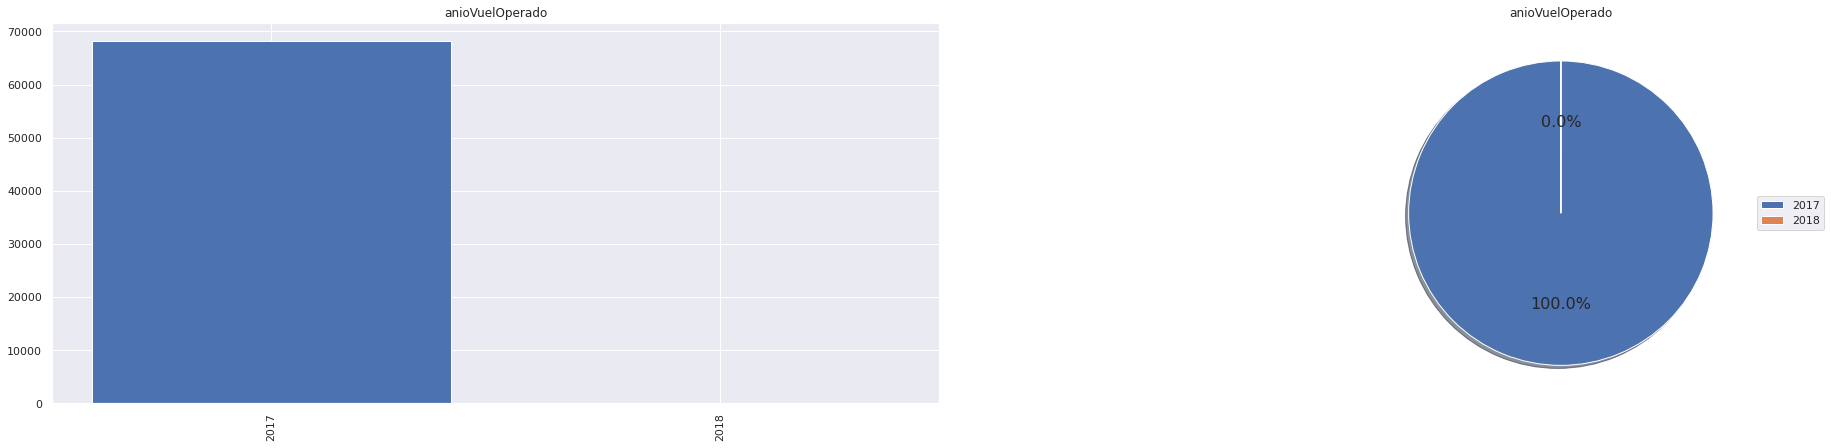

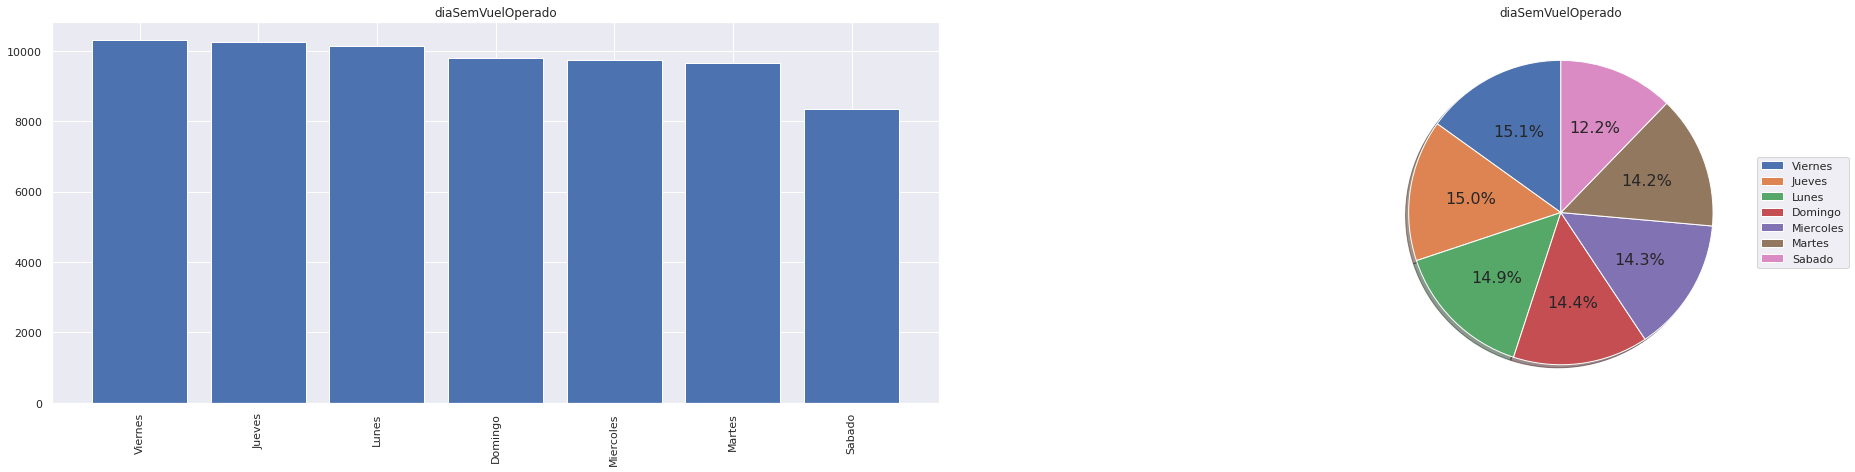

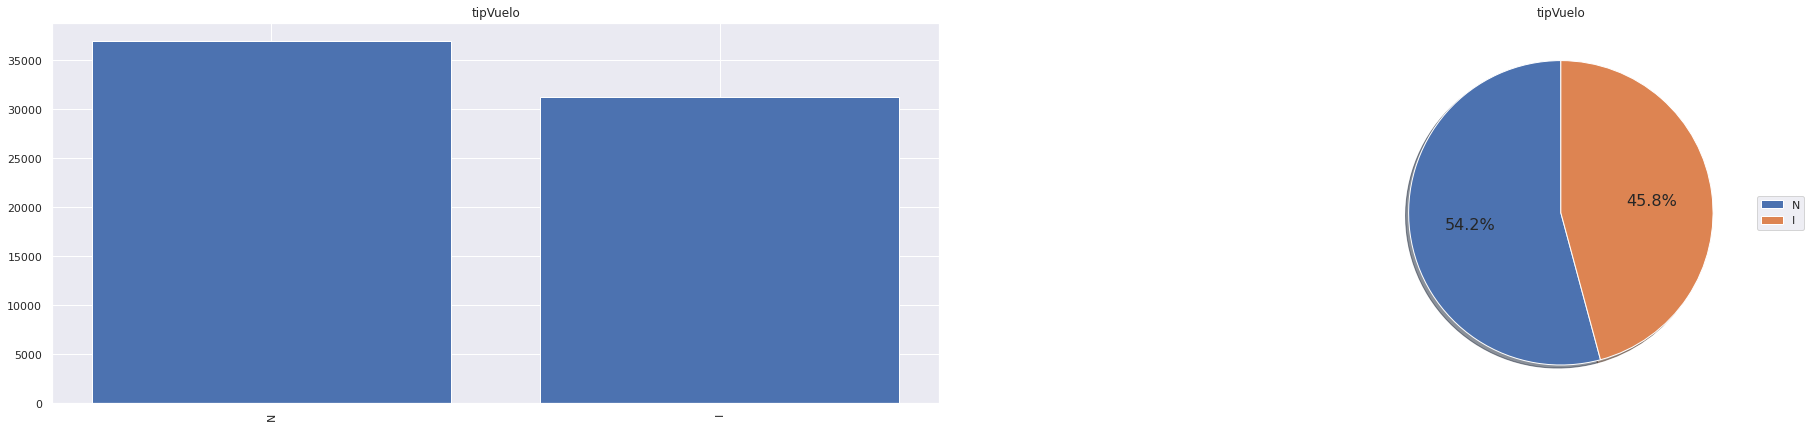

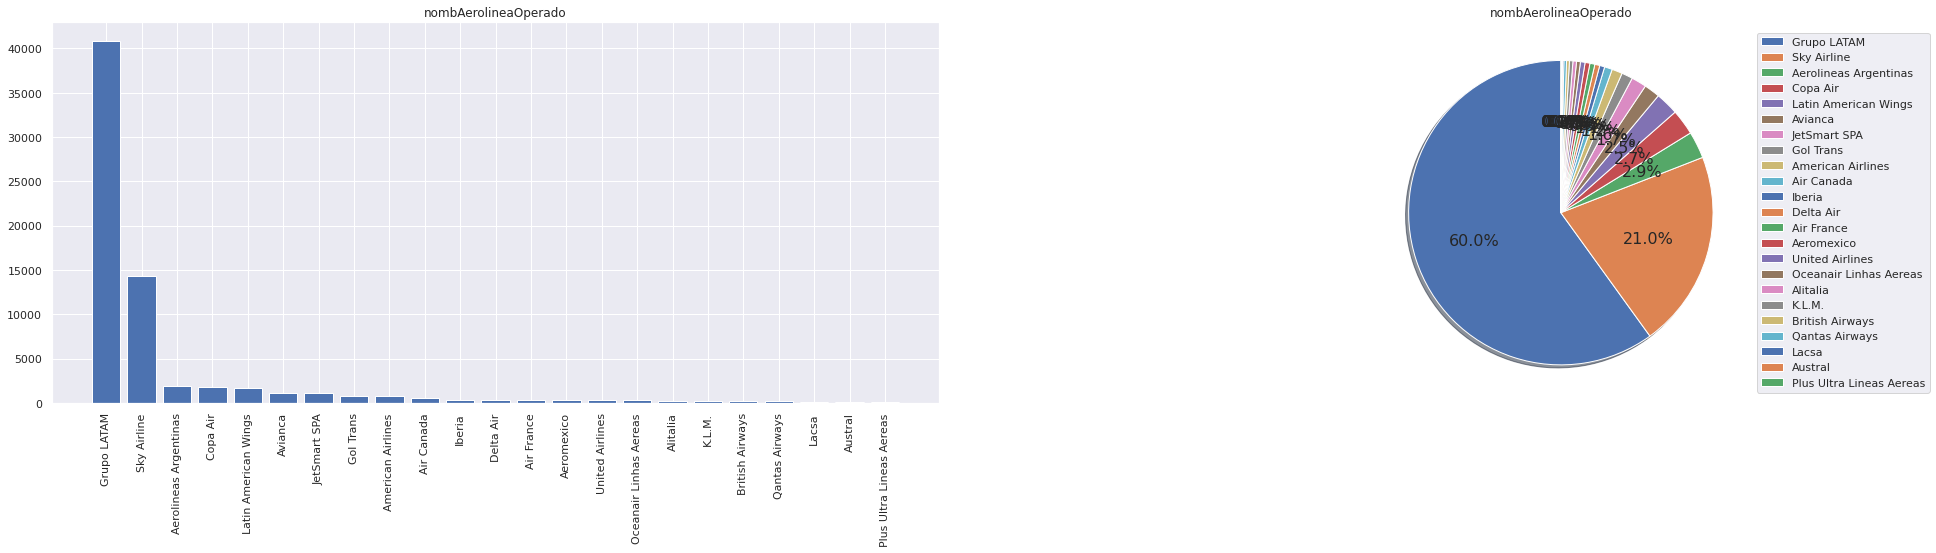

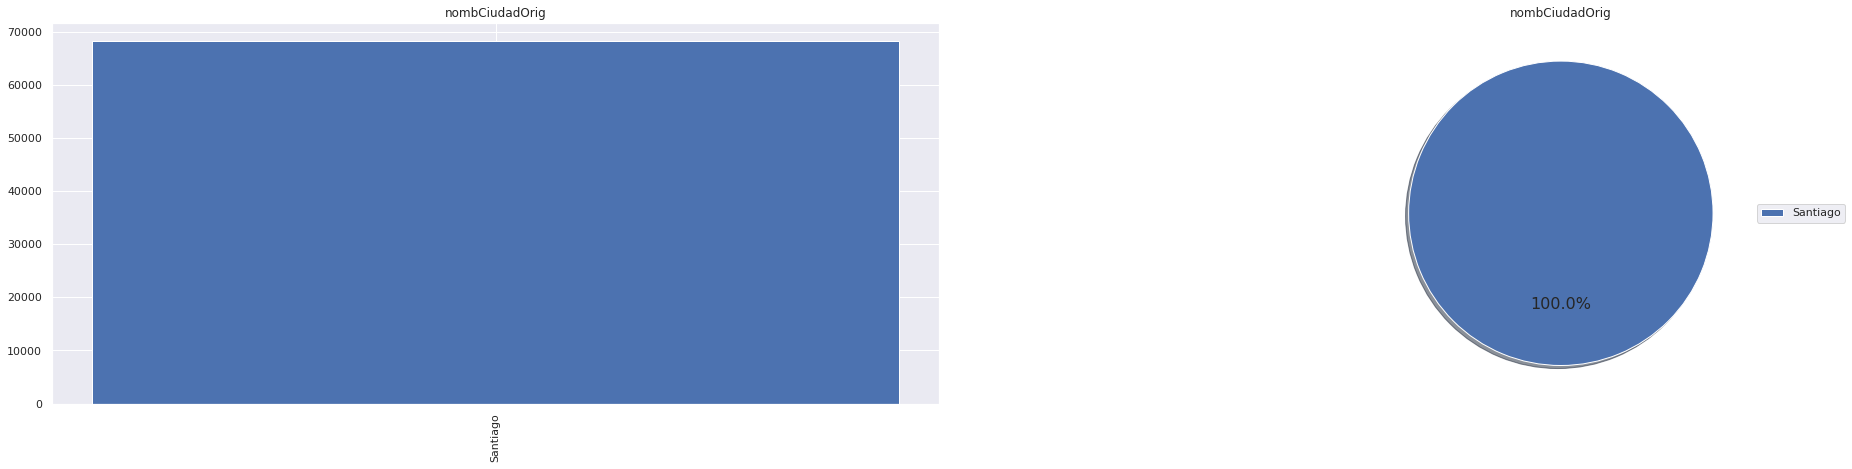

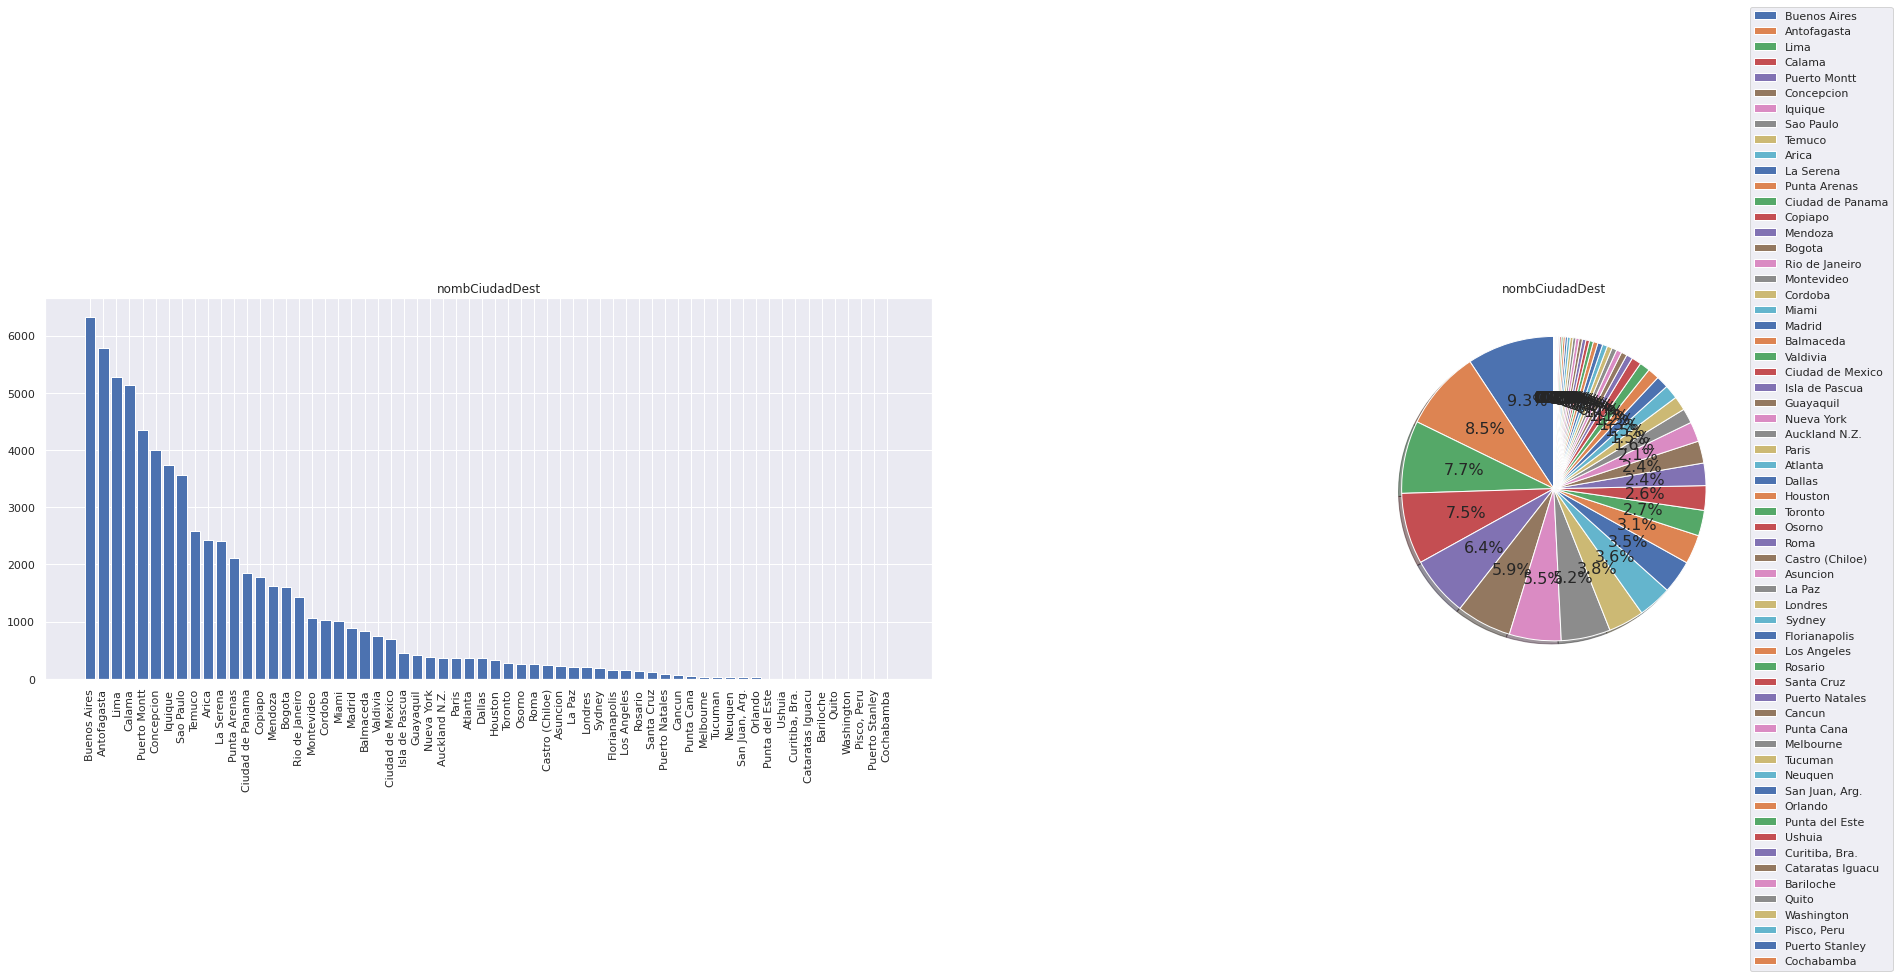

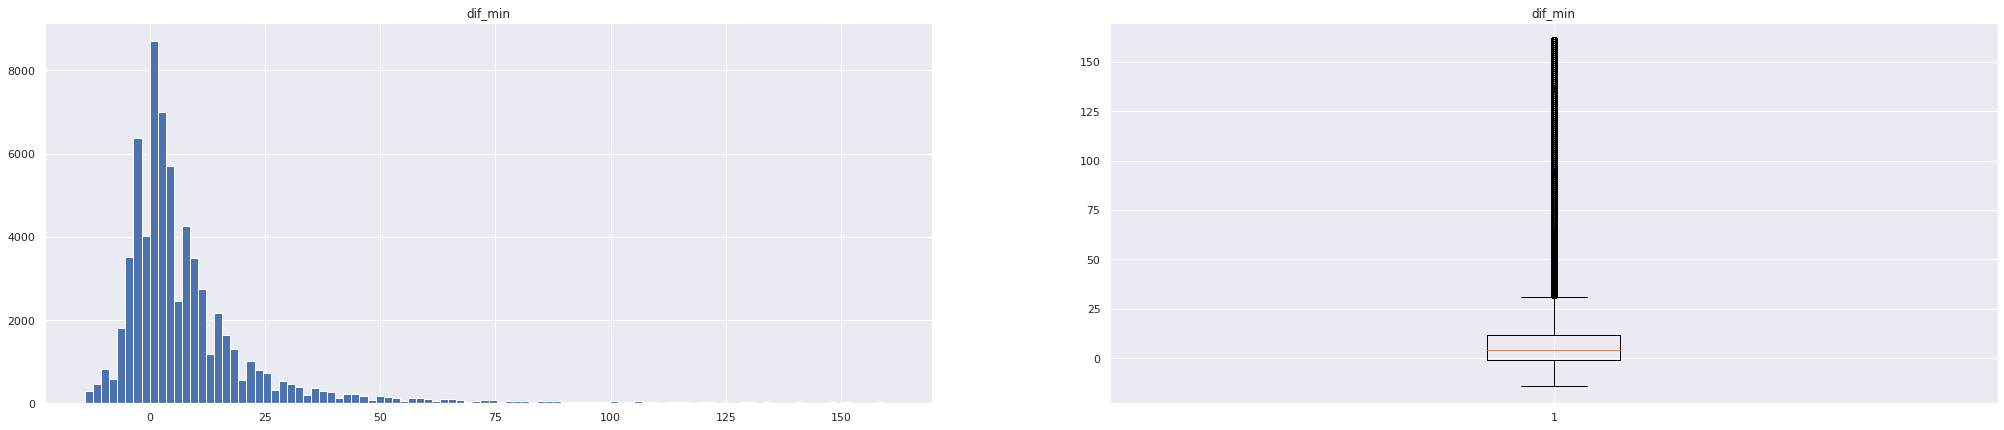

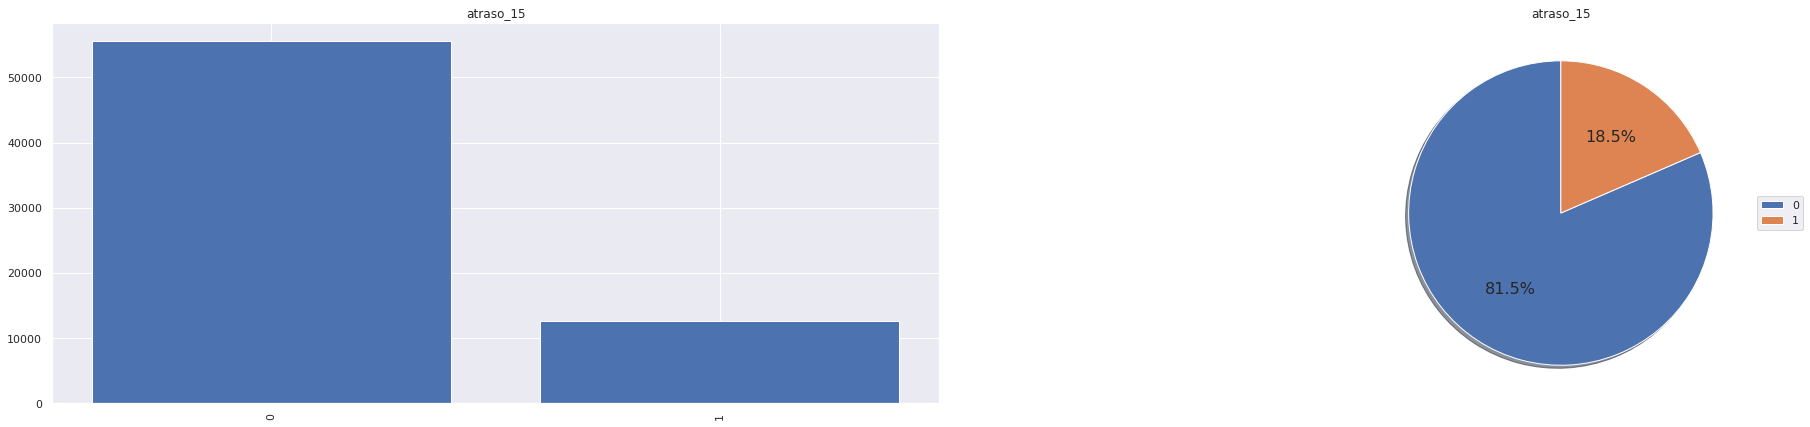

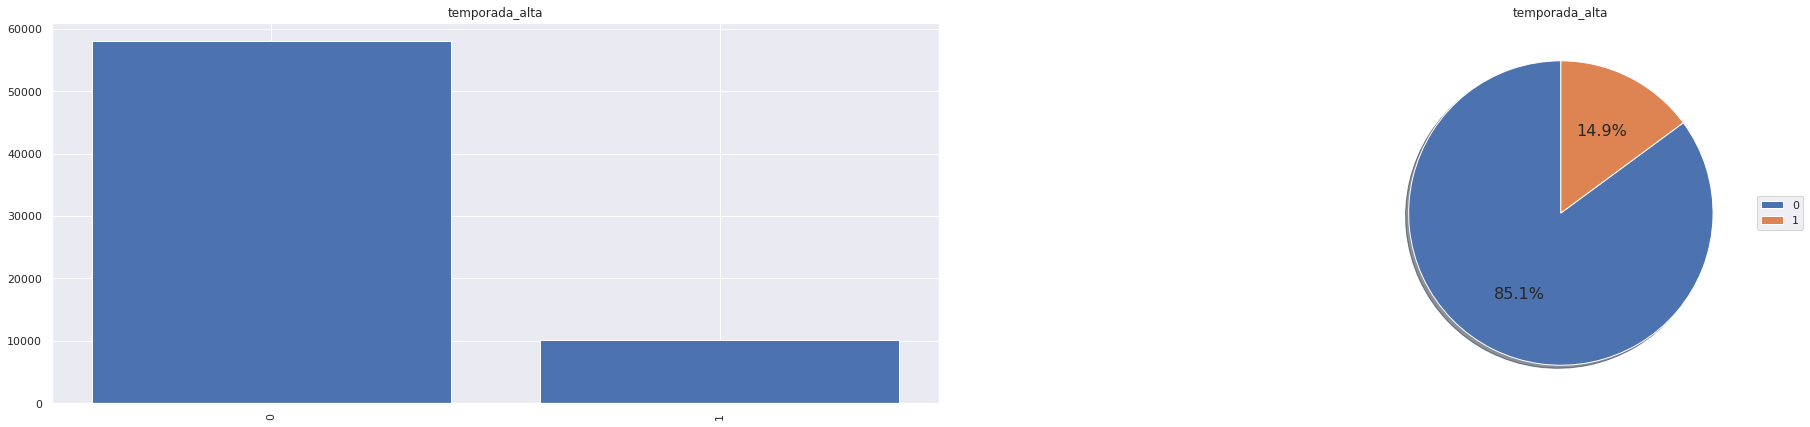

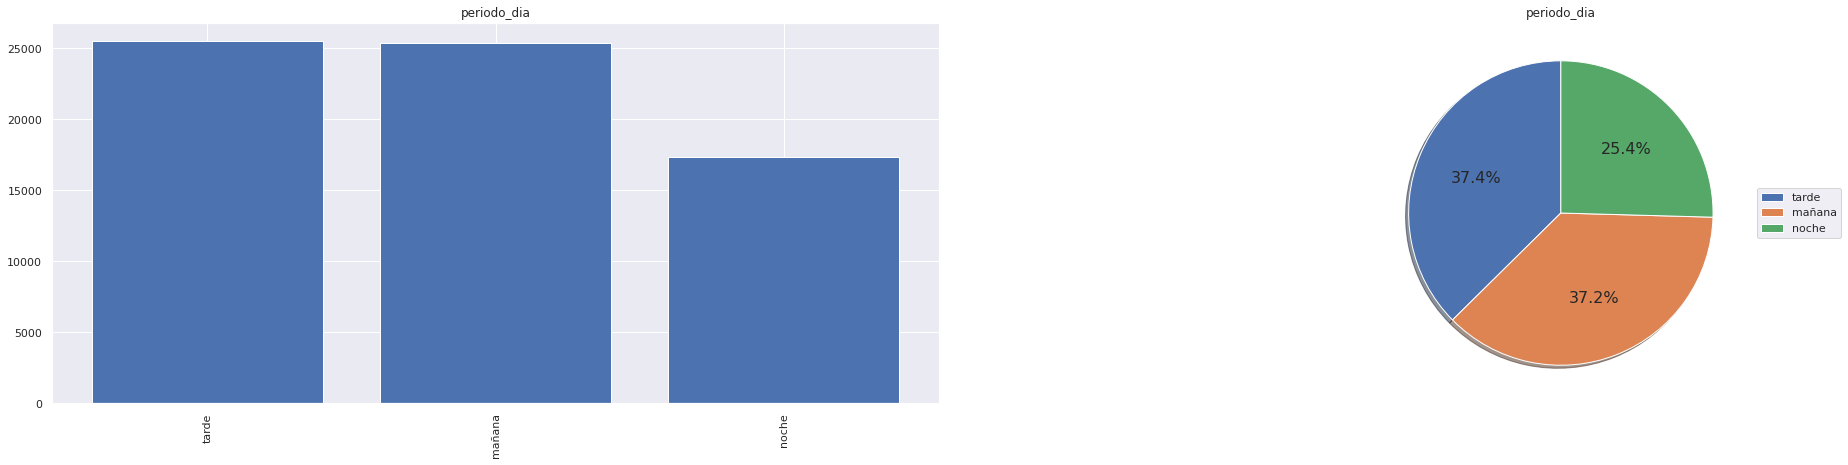

In [ ]:
# Análisis Univariado
plot_graph_initial(df_analisis, meta)

## Analisis Preliminar Bivariado

### Análisis de la tasa de retraso

In [169]:
# Se debe de tomar en cuenta la cantidad de valores por cada boxplot, la intensidad de color en cada boxplot ayudaría a saber la cantidad de valores en cada boxplot.

Se realiza el análisis correspondiente de la **tasa de atraso** por destino, aerolínea, tipo de vuelo, dia de la semana, mes del año, temporada y periodo. En ese sentido se necesita convertir las variables **mesVuelOperado** y **diaSemVuelOperado** a tipo *'category'* para un correcto análisis

In [ ]:
df_analisis['diaSemVuelOperado'] = df_analisis['diaSemVuelOperado'].astype('object')
df_analisis['mesVuelOperado'] = df_analisis['mesVuelOperado'].astype('object')

**Tasa de Atraso por destino**

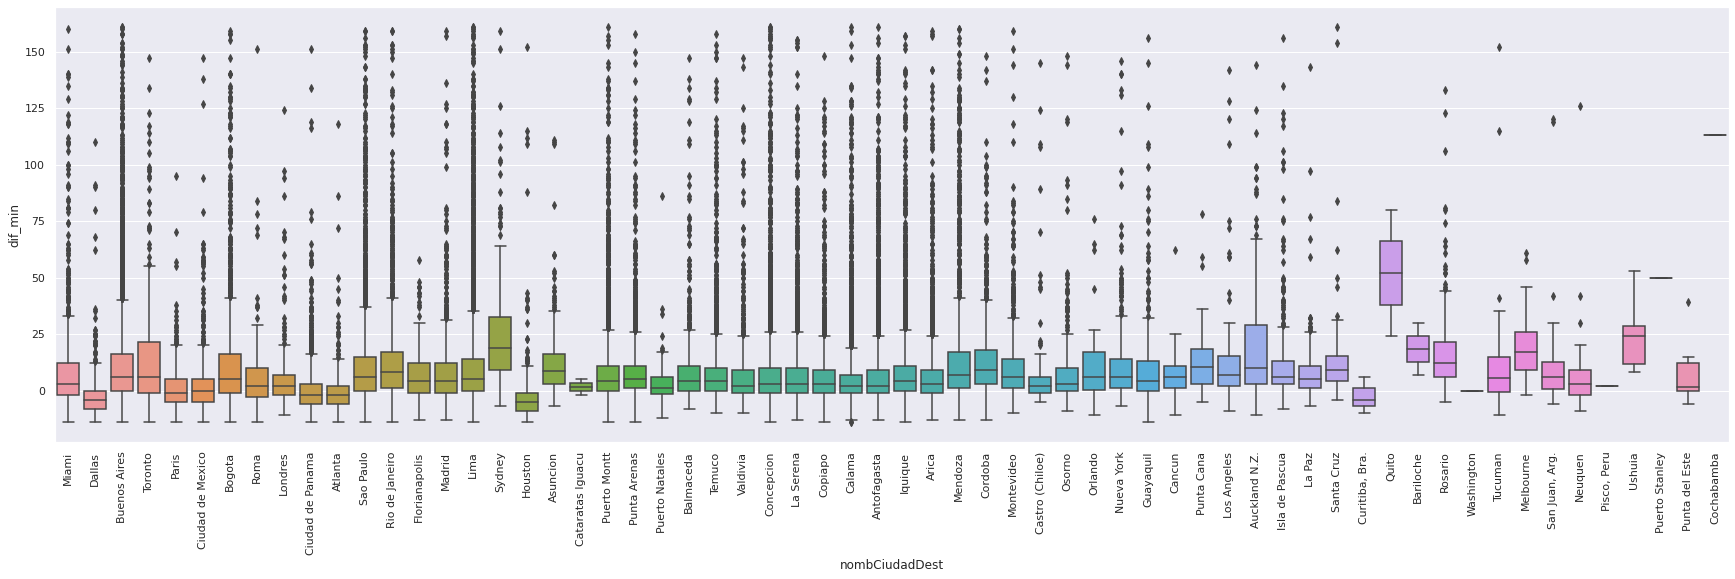

In [133]:
fig, ax = plt.subplots(1, figsize=(30, 8))
sns.boxplot(x=df_analisis['nombCiudadDest'], y=df_analisis['dif_min']);
plt.xticks(rotation = 90)
plt.show()

Se observa lo siguiente:
- La tasa de atraso para el destino de **Quito** es alta con respecto al resto de destinos. Sus valores son dispersos ya que la posición del primer con el tercer cuartil no se encuentran próximos.
- Los siguientes destinos que presentan altos valores de retraso son **Sydney, Ushuia, Bariloche, Melbourne y Auckland N.Z**.
- **Houston y Curitiba** presentan vuelos adelantados a lo programado.

**Tasa de atraso por aerolínea**

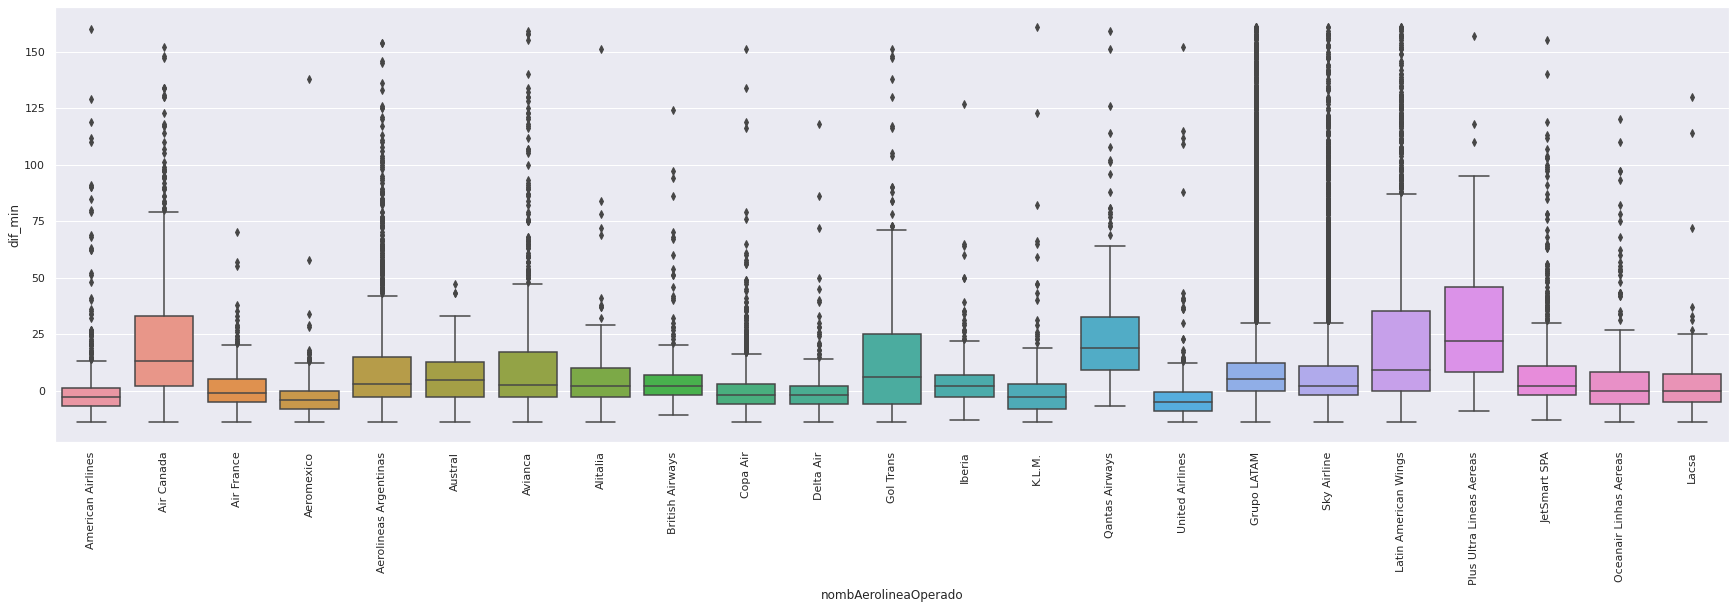

In [132]:
fig, ax = plt.subplots(1, figsize=(30, 8))
sns.boxplot(x=df_analisis['nombAerolineaOperado'], y=df_analisis['dif_min']);
plt.xticks(rotation = 90)
plt.show()

*Observaciones*

**Tasa de atraso por tipo de vuelo**

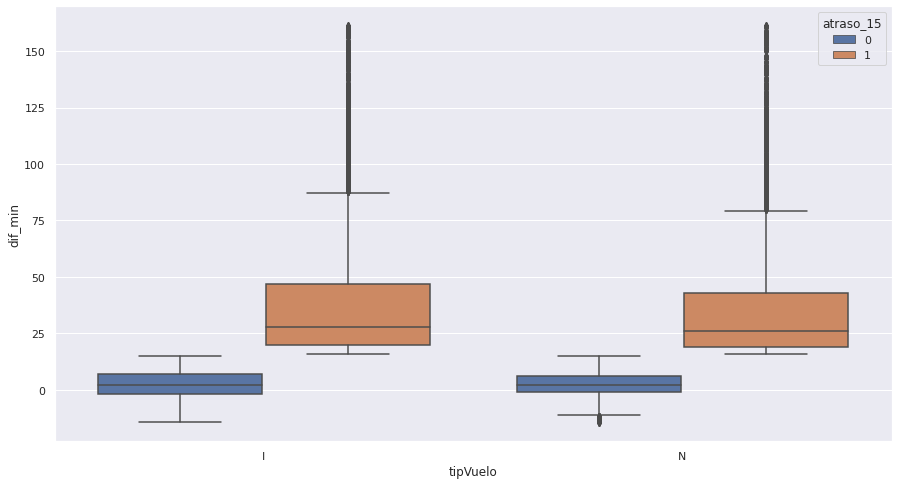

In [163]:
fig, ax = plt.subplots(1, figsize=(15, 8))
sns.boxplot(data=df_analisis, x="tipVuelo", y="dif_min",hue="atraso_15")
plt.show()

*Observaciones*

**Tasa de atraso por dia de la semana**

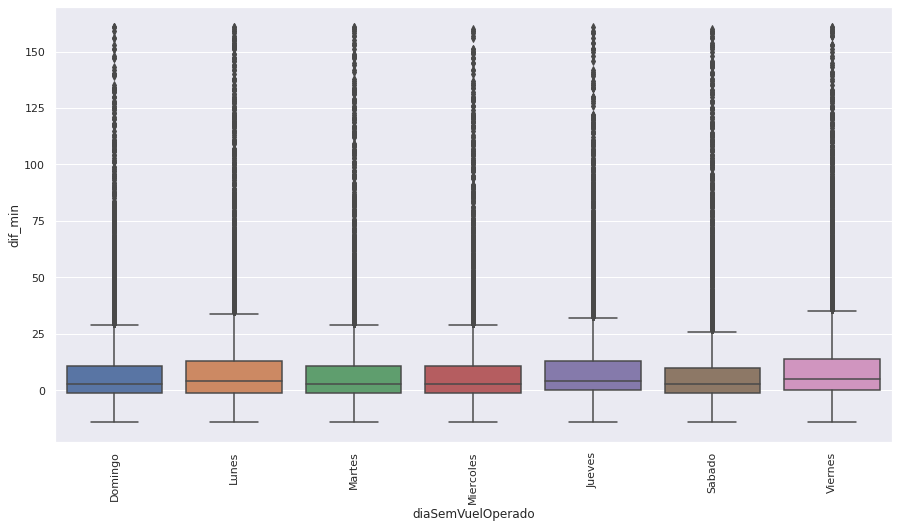

In [162]:
fig, ax = plt.subplots(1, figsize=(15, 8))
sns.boxplot(x=df_analisis['diaSemVuelOperado'], y=df_analisis['dif_min']);
plt.xticks(rotation = 90)
plt.show()

*Observaciones*

**Tasa de atraso por mes del año**

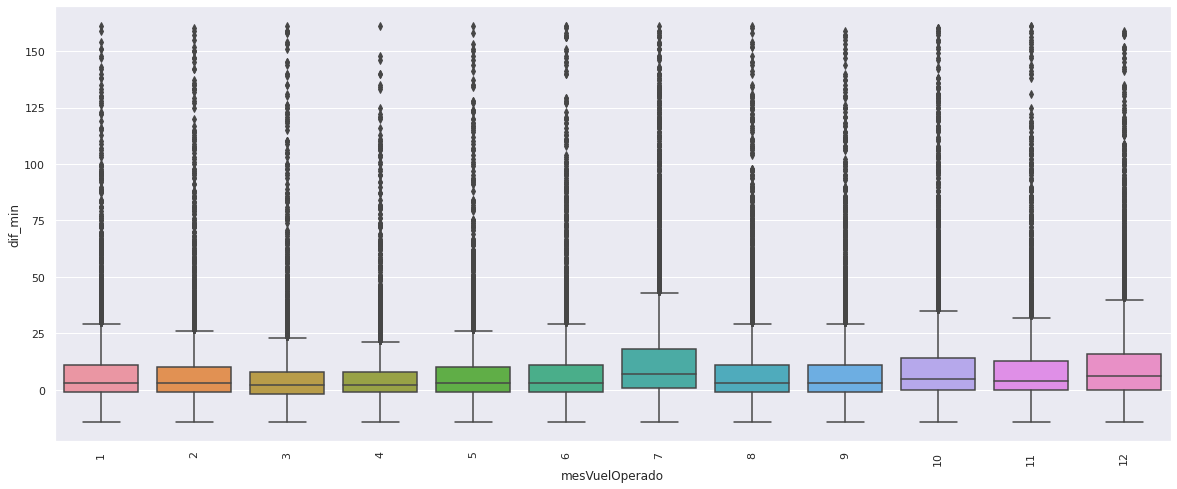

In [149]:
fig, ax = plt.subplots(1, figsize=(20, 8))
sns.boxplot(x=df_analisis['mesVuelOperado'], y=df_analisis['dif_min']);
plt.xticks(rotation = 90)
plt.show()

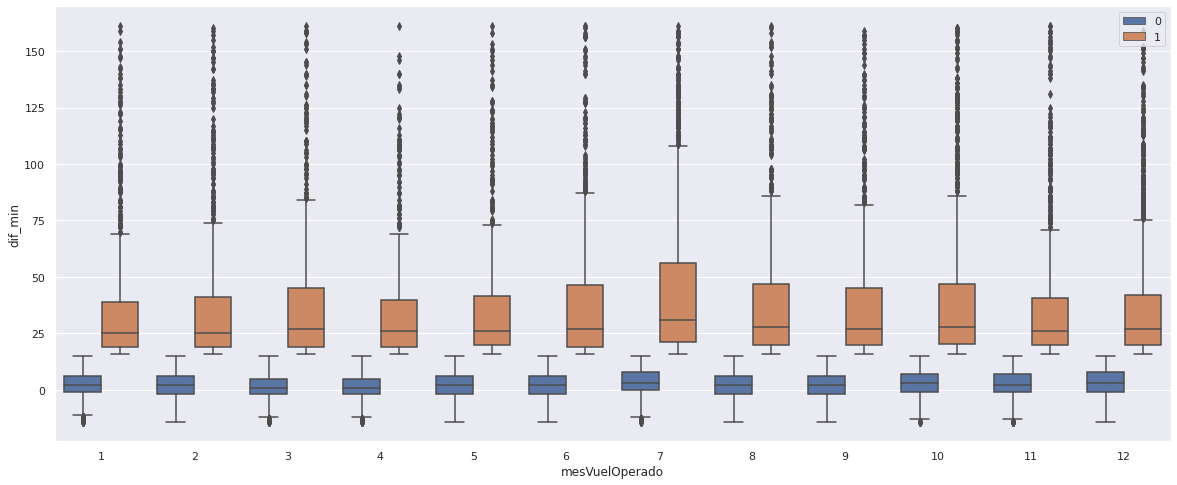

In [155]:
fig, ax = plt.subplots(1, figsize=(20, 8))
sns.boxplot(data=df_analisis, x="mesVuelOperado", y="dif_min",hue="atraso_15")
plt.legend(loc='upper right')
plt.show()

*Observaciones*

**Tasa de atraso por temporada**

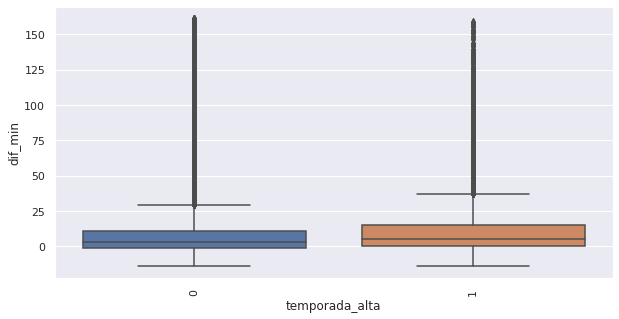

In [161]:
fig, ax = plt.subplots(1, figsize=(10, 5))
sns.boxplot(x=df_analisis['temporada_alta'], y=df_analisis['dif_min']);
plt.xticks(rotation = 90)
plt.show()

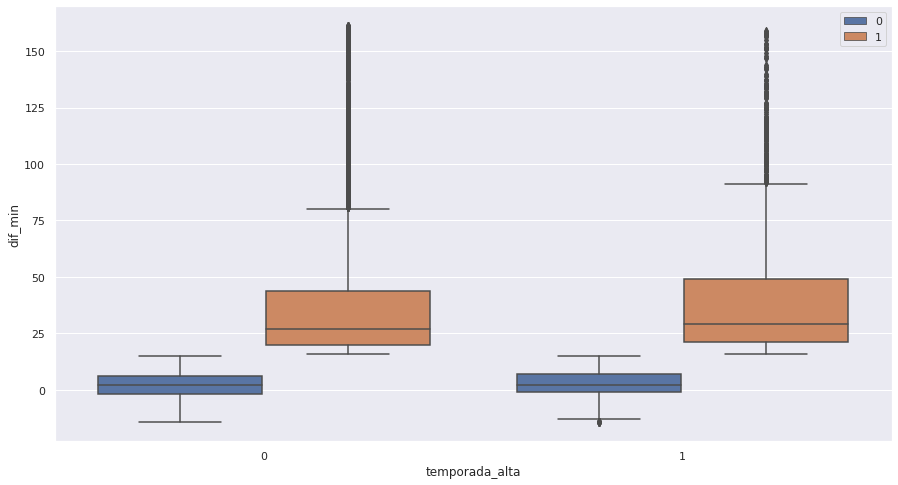

In [164]:
fig, ax = plt.subplots(1, figsize=(15, 8))
sns.boxplot(data=df_analisis, x="temporada_alta", y="dif_min",hue="atraso_15")
plt.legend(loc='upper right')
plt.show()

*Observaciones*

**Tasa de atraso por periodo**

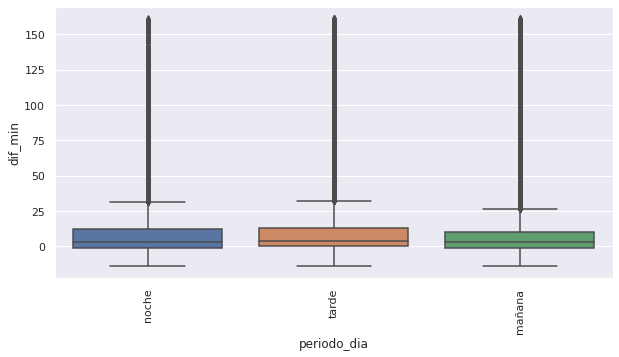

In [168]:
fig, ax = plt.subplots(1, figsize=(10, 5))
sns.boxplot(x=df_analisis['periodo_dia'], y=df_analisis['dif_min']);
plt.xticks(rotation = 90)
plt.show()

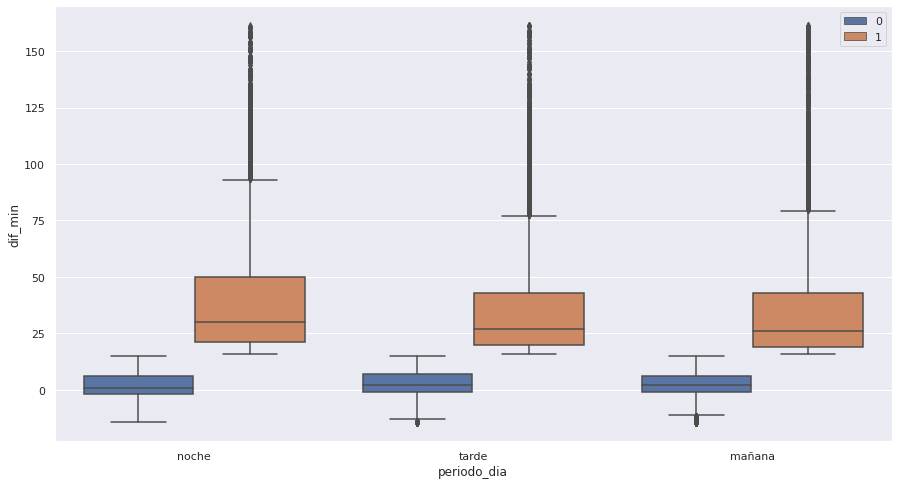

In [166]:
fig, ax = plt.subplots(1, figsize=(15, 8))
sns.boxplot(data=df_analisis, x="periodo_dia", y="dif_min",hue="atraso_15")
plt.legend(loc='upper right')
plt.show()

*Observaciones*

### Análisis de las rutas de mayor frecuencia

In [178]:
groupped_data = df_analisis.groupby(['nombCiudadOrig','nombCiudadDest'],as_index=False).agg({'atraso_15': 'count'})
groupped_data.rename(columns={'atraso_15':'nro_vuelos'},inplace=True)
groupped_data.sort_values(by=['nro_vuelos'],ascending=False,inplace=True)
groupped_data["% Total"] = groupped_data['nro_vuelos']/len(df_analisis)*100
groupped_data.head(10)

,nombCiudadOrig,nombCiudadDest,nro_vuelos,% Total
8,Santiago,Buenos Aires,6335,9.288039
0,Santiago,Antofagasta,5786,8.483125
28,Santiago,Lima,5270,7.726593
9,Santiago,Calama,5146,7.544791
42,Santiago,Puerto Montt,4357,6.388001
16,Santiago,Concepcion,3993,5.854324
24,Santiago,Iquique,3747,5.493652
54,Santiago,Sao Paulo,3569,5.232677
56,Santiago,Temuco,2589,3.795854
1,Santiago,Arica,2436,3.571533


Se contempla el análisis de rutas de mayor y menor frecuencia que indica cuales son los orígenes y destinos con más y menos número de vuelos tienen, sin embargo como se aprecia la ciudad de origen es la misma para todos los vuelos. 

Este tipo de análisis puede ser de vital importancia en caso se tengan múltiples origenes, ya que permite saber cuales son las rutas de mayor y menor frecuencia

### Análisis de los vuelos Programados vs Operados

Se realiza el análisis de las siguientes variables:
*   **nroVuelProg**
*   **codCiudadDestProg**
*   **codAerolineaVuelProg**


*   **nroVuelOperado**
*   **codCiudadDestOperado**
*   **codAerolineaVuelOperado**


In [ ]:
df_analisis[['nroVuelProg','nroVuelOperado','codCiudadDestProg','codCiudadDestOperado','codAerolineaVuelProg','codAerolineaVuelOperado']].describe(include='all')

,nroVuelProg,nroVuelOperado,codCiudadDestProg,codCiudadDestOperado,codAerolineaVuelProg,codAerolineaVuelOperado
count,68206,68206,68206,68206,68206,68206
unique,584,861,64,63,30,32
top,174,174,SCFA,SCFA,LAN,LAN
freq,686,650,5787,5786,37611,20988


In [179]:
df_analisis.nroVuelProg.value_counts(normalize = True)*100

174      1.005777
11       0.945665
116      0.891417
150      0.816644
704      0.815178
162      0.810779
164      0.806381
118      0.744803
172      0.730141
170      0.725743
146      0.665631
120      0.645105
281      0.628977
136      0.612849
1        0.596722
114      0.590857
138      0.586459
134      0.573263
122      0.567399
130      0.567399
126      0.554203
702      0.554203
43       0.551271
142      0.546873
124      0.543940
912      0.542474
112      0.539542
7        0.535144
802      0.533677
285      0.533677
190      0.533677
273      0.533677
7663     0.532211
752      0.532211
800      0.530745
6830     0.530745
507      0.529279
445      0.529279
572      0.529279
530      0.527813
801      0.527813
501      0.527813
51       0.527813
239      0.526347
8161     0.526347
401      0.524881
750      0.524881
461      0.524881
624      0.524881
300      0.523414
8137     0.523414
940      0.521948
455      0.521948
642      0.521948
276      0.519016
340      0

In [194]:
df_analisis.nroVuelOperado.value_counts(normalize = True)*100

174       0.952995
11        0.947131
116       0.891417
150       0.757998
704       0.753599
162       0.750667
164       0.744803
118       0.743336
172       0.683224
170       0.662698
146       0.652435
120       0.615782
1         0.583526
136       0.582060
122       0.555670
130       0.554203
281       0.549805
43        0.546873
114       0.543940
138       0.542474
912       0.542474
134       0.542474
142       0.541008
7         0.535144
112       0.533677
7663      0.532211
6830      0.530745
51        0.527813
8161      0.526347
124       0.523414
940       0.523414
8137      0.523414
401       0.521948
624       0.520482
126       0.519016
276       0.519016
71        0.514617
702       0.510219
495       0.510219
1281      0.507287
8125      0.504354
1287      0.494091
1285      0.494091
25        0.492625
190       0.489693
1283      0.489693
273       0.488227
285       0.488227
800       0.486761
104       0.486761
93        0.486761
802       0.486761
752       0.

Se puede observar muchas categorias en las variables **nroVueloProg** y **nroVueloOper**, esto es un sintoma de mucha variabilidad que no ayuda en la diferencia de una clase con otra, por lo que se decide no tomarlas en cuenta para la etapa de aprendizaje

In [183]:
df_analisis.codCiudadDestProg.value_counts(normalize = True)*100

SCFA    8.484591
SPJC    7.726593
SCCF    7.543325
SCTE    6.388001
SCIE    5.857256
SCDA    5.493652
SBGR    5.234144
SAEZ    4.750315
SABE    4.536258
SCQP    3.787057
SCAR    3.571533
SCSE    3.533413
SCCI    3.086239
MPTO    2.712371
SCAT    2.609741
SAME    2.382488
SKBO    2.351699
SBGL    2.102454
SUMU    1.562912
SACO    1.499868
KMIA    1.488139
LEMD    1.310735
SCBA    1.235962
SCVD    1.104008
MMMX    1.026303
SCIP    0.662698
SEGU    0.620180
KJFK    0.561534
NZAA    0.529279
LFPG    0.526347
KATL    0.524881
KDFW    0.523414
KIAH    0.491159
CYYZ    0.414920
LIRF    0.379732
SCJO    0.379732
SCPQ    0.344544
SGAS    0.340146
SLLP    0.306425
EGLL    0.300560
YSSY    0.285899
SBFL    0.237516
KLAX    0.227253
SAAR    0.199396
SLVR    0.175938
SCNT    0.115826
MMUN    0.092367
MDPC    0.079172
SANT    0.055714
YMML    0.055714
SAZN    0.054247
SANU    0.051315
KMCO    0.049849
SAWH    0.008797
SULS    0.008797
SBCT    0.004398
SAZS    0.002932
SLCB    0.001466
EGYP    0.0014

In [182]:
df_analisis.codCiudadDestOperado.value_counts(normalize = True)*100

SCFA    8.483125
SPJC    7.726593
SCCF    7.544791
SCTE    6.388001
SCIE    5.854324
SCDA    5.493652
SBGR    5.232677
SAEZ    4.751781
SABE    4.536258
SCQP    3.795854
SCAR    3.571533
SCSE    3.533413
SCCI    3.086239
MPTO    2.712371
SCAT    2.609741
SAME    2.382488
SKBO    2.351699
SBGL    2.103920
SUMU    1.562912
SACO    1.499868
KMIA    1.489605
LEMD    1.310735
SCBA    1.230097
SCVD    1.104008
MMMX    1.026303
SCIP    0.662698
SEGU    0.618714
KJFK    0.560068
NZAA    0.529279
LFPG    0.526347
KATL    0.524881
KDFW    0.523414
KIAH    0.489693
CYYZ    0.414920
SCJO    0.379732
LIRF    0.379732
SCPQ    0.344544
SGAS    0.340146
SLLP    0.306425
EGLL    0.300560
YSSY    0.284432
SBFL    0.237516
KLAX    0.227253
SAAR    0.199396
SLVR    0.175938
SCNT    0.115826
MMUN    0.092367
MDPC    0.079172
YMML    0.057180
SANT    0.055714
SAZN    0.054247
SANU    0.051315
KMCO    0.049849
SULS    0.008797
SAWH    0.008797
SBCT    0.004398
SBFI    0.002932
SAZS    0.002932
SEQM    0.0029

A pesar que estas variables tienen bastantes categorias, aplicando alguna tecnica como CONVERSION CON RESPECTO AL TARGET pueden ser útiles para el modelo 

In [185]:
df_analisis.codAerolineaVuelProg.value_counts(normalize = True)*100

LAN    55.143243
SKU    20.962965
TAM     4.470281
ARG     2.857520
CMP     2.712371
LAW     2.307715
AVA     1.689001
JAT     1.605431
GLO     1.181714
AAL     1.109873
ACA     0.828373
IBE     0.530745
AFR     0.524881
DAL     0.524881
AMX     0.514617
UAL     0.491159
ONE     0.409055
AZA     0.379732
KLM     0.368003
LAP     0.316688
BAW     0.300560
QFU     0.285899
JMR     0.146615
LRC     0.134885
AUT     0.108495
PUE     0.071841
LXP     0.013195
LPE     0.005865
DSM     0.002932
LNE     0.001466
Name: codAerolineaVuelProg, dtype: float64

In [184]:
df_analisis.codAerolineaVuelOperado.value_counts(normalize = True)*100

LAN    30.771486
LXP    21.344163
SKU    20.962965
TAM     4.465883
ARG     2.853121
CMP     2.712371
JMR     2.414744
LPE     1.779902
JAT     1.605431
AVA     1.297540
GLO     1.181714
AAL     1.109873
ACA     0.828373
DSM     0.722810
LNE     0.548339
IBE     0.530745
AFR     0.524881
DAL     0.524881
LRC     0.523414
AMX     0.514617
UAL     0.491159
ONE     0.409055
AZA     0.379732
KLM     0.368003
LAP     0.321086
BAW     0.300560
QFA     0.285899
AUT     0.112893
PUE     0.071841
56R     0.024924
48O     0.014661
TPU     0.002932
Name: codAerolineaVuelOperado, dtype: float64

A pesar que estas variables tienen bastantes categorias, aplicando alguna tecnica como CONVERSION CON RESPECTO AL TARGET pueden ser útiles para el modelo

- El 75% de la variable **codAerolineaVuelProg** se reparte entre LAN y SKU, teniendo 55% y 20% respectivamente
- El 73% de la variable **codAerolineaVuelOper** se reparte entre LAN, LXP y SKU, teniendo 31%, 21% y 21% respectivamente



**Creacion de la hora en base a la Fecha operativa del vuelo**

In [187]:
df_analisis['horaOperVuelo'] = df_analisis['fecVuelOperado'].dt.hour

In [188]:
df_analisis["horaOperVuelo"]=df_analisis['horaOperVuelo'].astype('str')

In [189]:
df_analisis.horaOperVuelo.value_counts(normalize= True)*100

7     6.700290
8     6.364543
18    5.678386
14    5.668123
6     5.659326
15    5.621206
19    5.459930
11    5.207753
13    5.137378
17    5.118318
9     5.113920
12    5.043545
16    4.762044
20    4.448289
5     3.835440
10    3.759200
21    3.465971
22    3.297364
1     2.468991
23    1.985163
4     1.735918
0     1.693399
2     0.974988
3     0.800516
Name: horaOperVuelo, dtype: float64

**Creación de campos de validación para revisar si lo programado es igual a lo operado**

In [191]:
# Validación para ver si lo programado es igual a lo operado
df_analisis['cambioNroVuelo'] = df_analisis.apply(lambda x: '0' if x['nroVuelProg']==x['nroVuelOperado'] else '1', axis=1)
df_analisis['cambioCodCiudadDest'] = df_analisis.apply(lambda x: '0' if x['codCiudadDestProg']==x['codCiudadDestOperado'] else '1', axis=1)
df_analisis['cambioCodAerolineaVuelo'] = df_analisis.apply(lambda x:'0' if x['codAerolineaVuelProg']==x['codAerolineaVuelOperado'] else '1', axis=1)

In [192]:
print(df_analisis.groupby(df_analisis['cambioNroVuelo']).size())
print("------------")
print(df_analisis.groupby(df_analisis['cambioCodCiudadDest']).size())
print("------------")
print(df_analisis.groupby(df_analisis['cambioCodAerolineaVuelo']).size())

cambioNroVuelo
0    63687
1     4519
dtype: int64
------------
cambioCodCiudadDest
0    68178
1       28
dtype: int64
------------
cambioCodAerolineaVuelo
0    49537
1    18669
dtype: int64


- El **nroVuelProg** y **nroVuelOperado** se observa que tienen diferencias en sus categorias, el numero de vuelo cambio en la operación en un **6.6%** con respecto a todos los vuelos programados.
- El **codCiudadDestProg** y **codCiudadDestOperado** se observa que tienen diferencias en sus categorias, la ciudad destino cambio en la operación en un **0.04%** con respecto a todos los vuelos programados.
- El **codAerolineaVueloProg** y **codAerolineaVueloOperado** se observa que tienen diferencias en sus categorias, el codigo de la aerolínea cambio en su ejecución en un **27.37%** con respecto a todos los vuelos programados.

Las nuevas variables. **cambioNroVuelo**, **cambioCodAerolineaVuelo** tienen la posibilidad de ser empleadas en el proceso de entrenamiento. Por otro lado las variables **cambioCodCiudadOri** y **cambioCodCiudadDest** no serán usadas debido a la baja varianza.


In [193]:
df_analisis.drop('cambioCodCiudadDest', axis=1, inplace=True)

Se puede observar muchas categorias en las variables **nroVuelProg** y **nroVuelOperado** y ninguna de las categorias reune un porcentaje mayor con respecto a otro, esto es un sintoma de mucha variabilidad que no ayuda en la diferencia de una clase con otra. En ese sentido se omite las siguientes campos dado que tienen mucha variabilidad (se puede observar que existen demasiadas categorías en las variables) lo cual no ayudaria a hacer alguna distinción con el target:

nroVueloProg: 584

nroVueloOper : 861

**Si no se desea omitir una alternativa es conversar con el negocio para que nos proporcione un mejor entendiminto de estas variables y asi poder considerarlas.**

In [195]:
df_analisis.drop('nroVuelProg', axis=1, inplace=True)
df_analisis.drop('nroVuelOperado', axis=1, inplace=True)

### Reporte Bivariado (Variables de más influencia)

In [196]:
df_analisis['atraso_15']=df_analisis['atraso_15'].astype('int64')

In [198]:
meta

,variable,tipo
2,codCiudadDestProg,category
3,codAerolineaVuelProg,category
6,codCiudadDestOperado,category
7,codAerolineaVuelOperado,category
9,mesVuelOperado,category
10,anioVuelOperado,category
11,diaSemVuelOperado,category
12,tipVuelo,category
13,nombAerolineaOperado,category
14,nombCiudadOrig,category


codCiudadDestProg


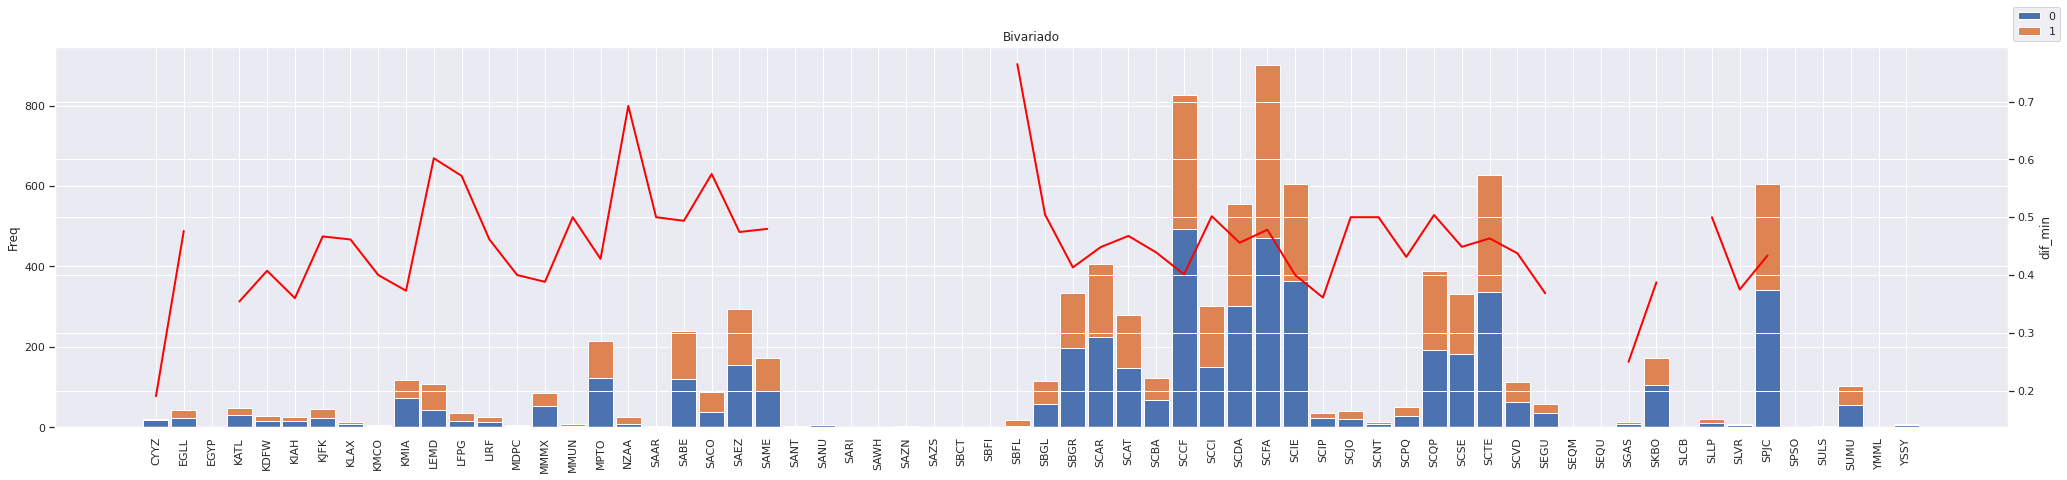

codAerolineaVuelProg


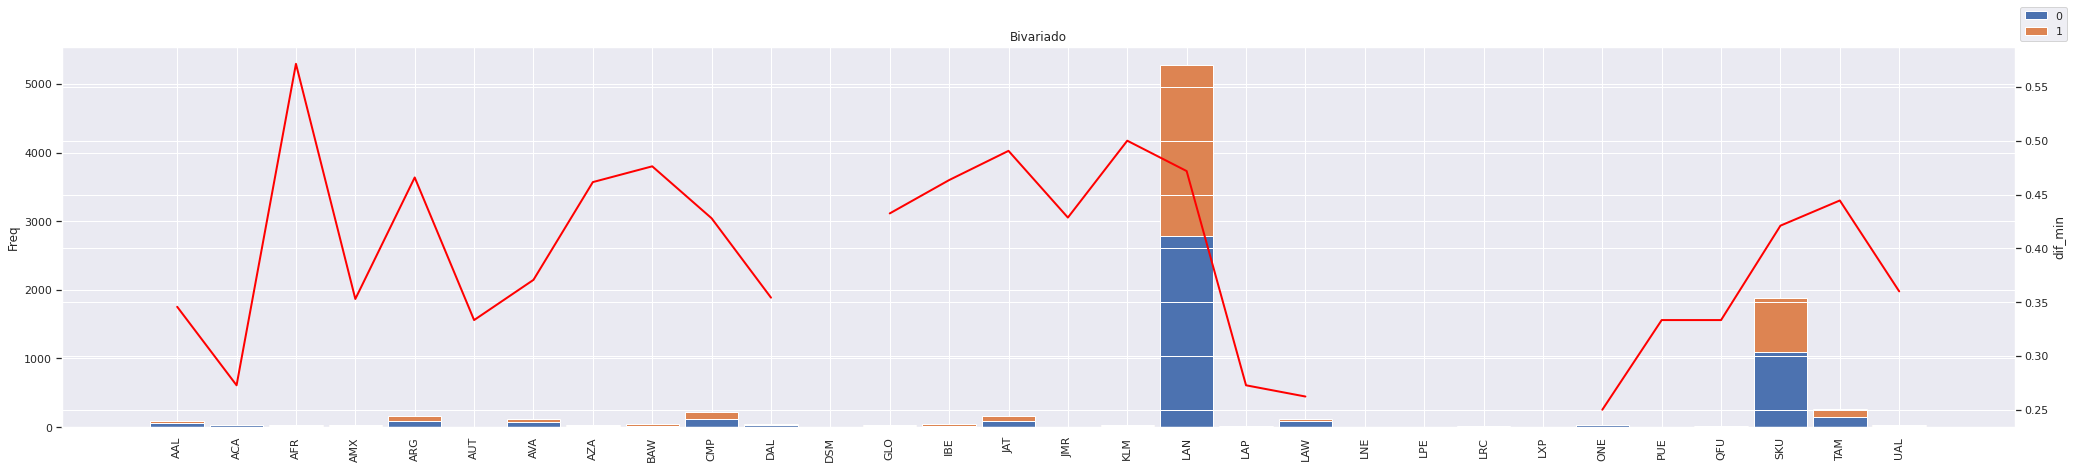

codCiudadDestOperado


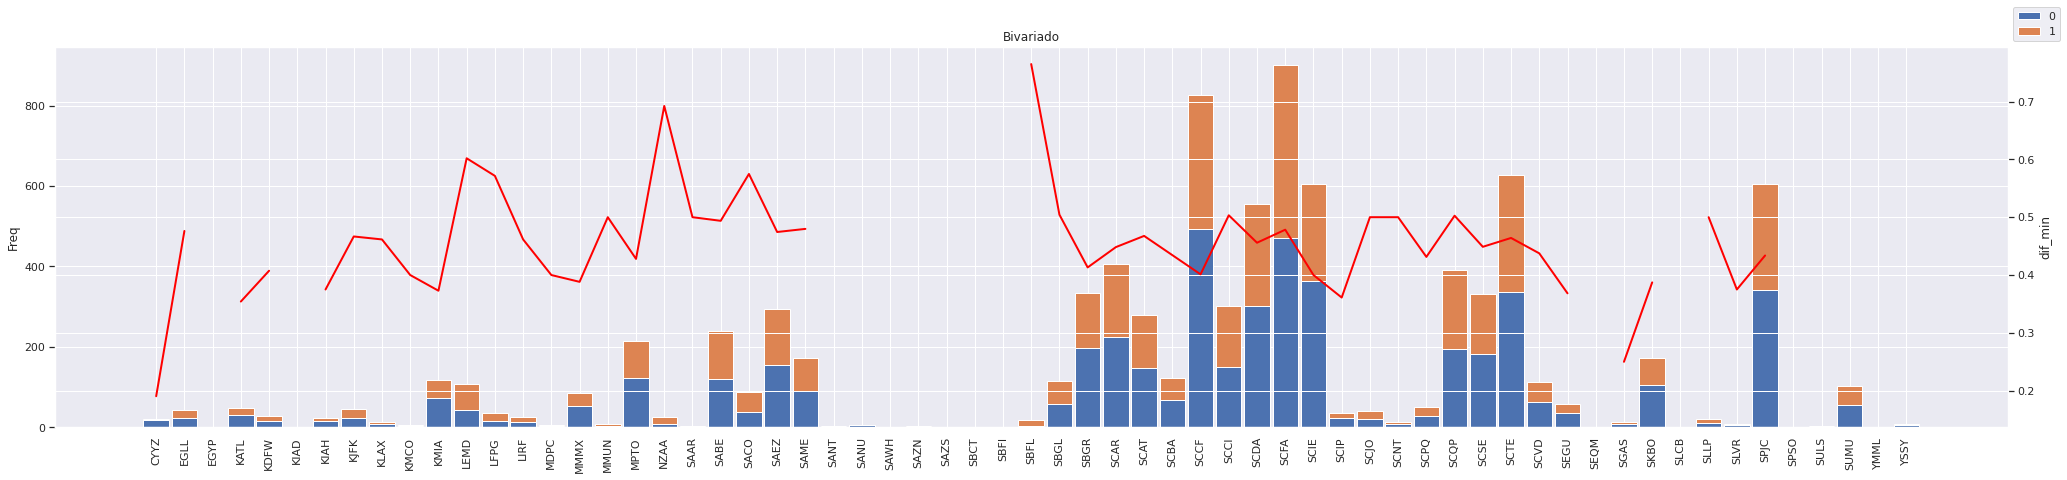

codAerolineaVuelOperado


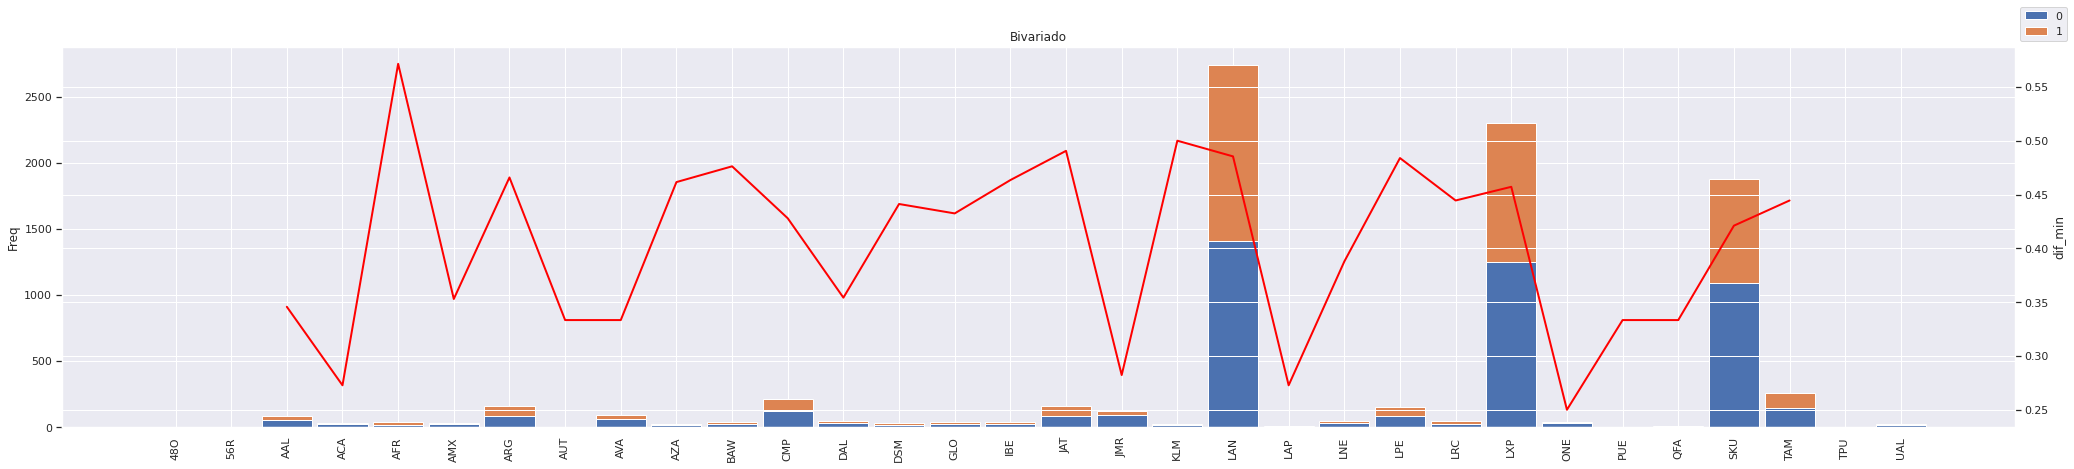

mesVuelOperado


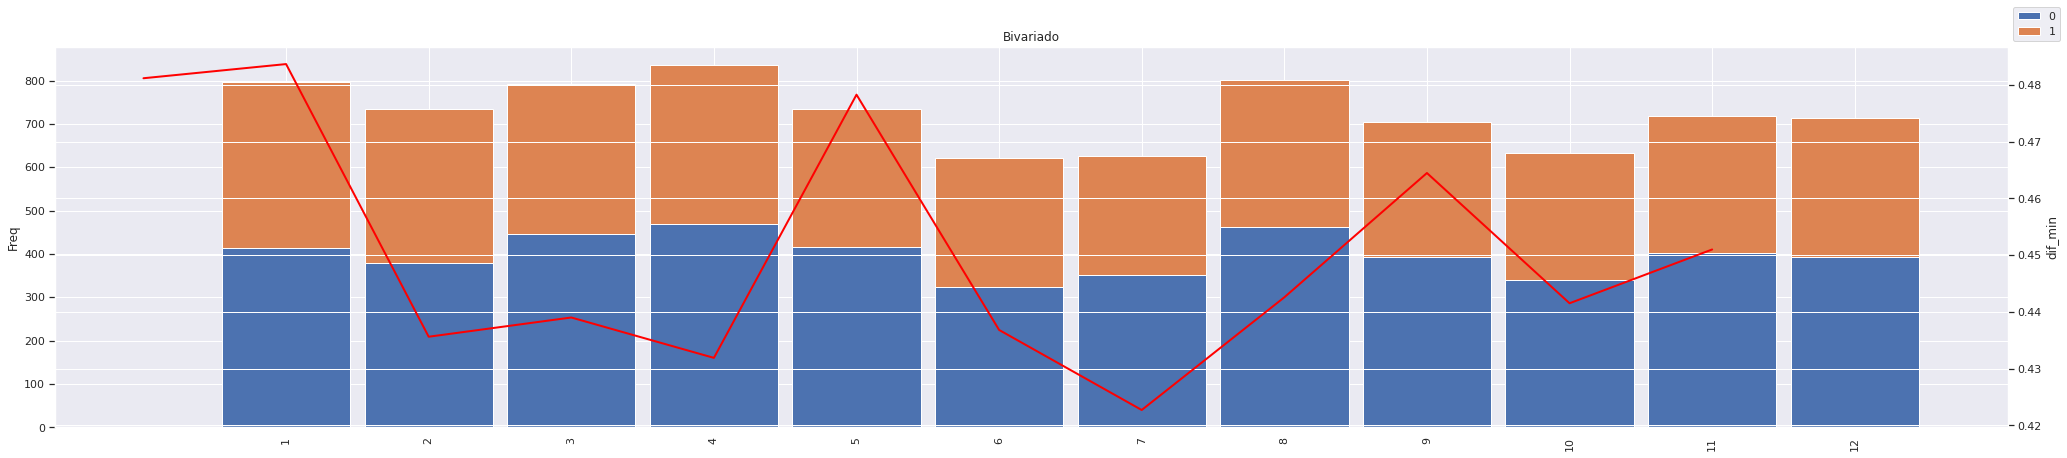

anioVuelOperado


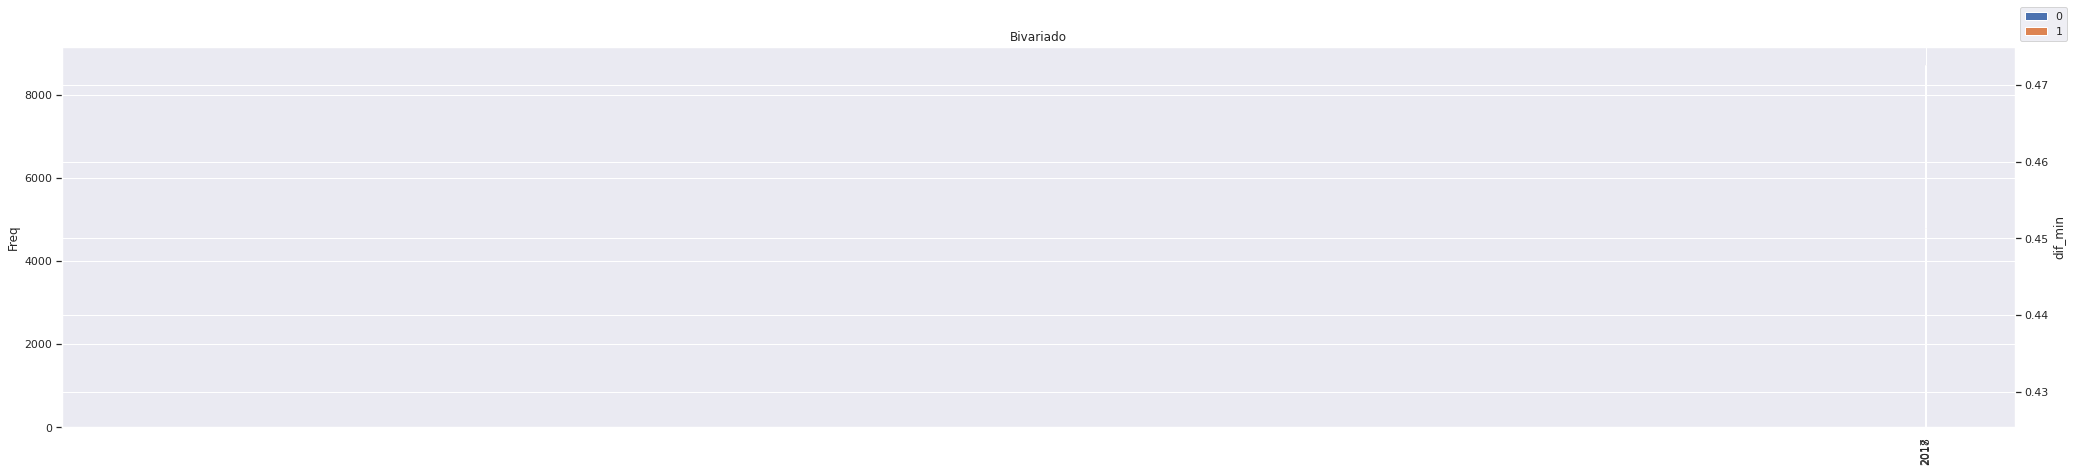

diaSemVuelOperado


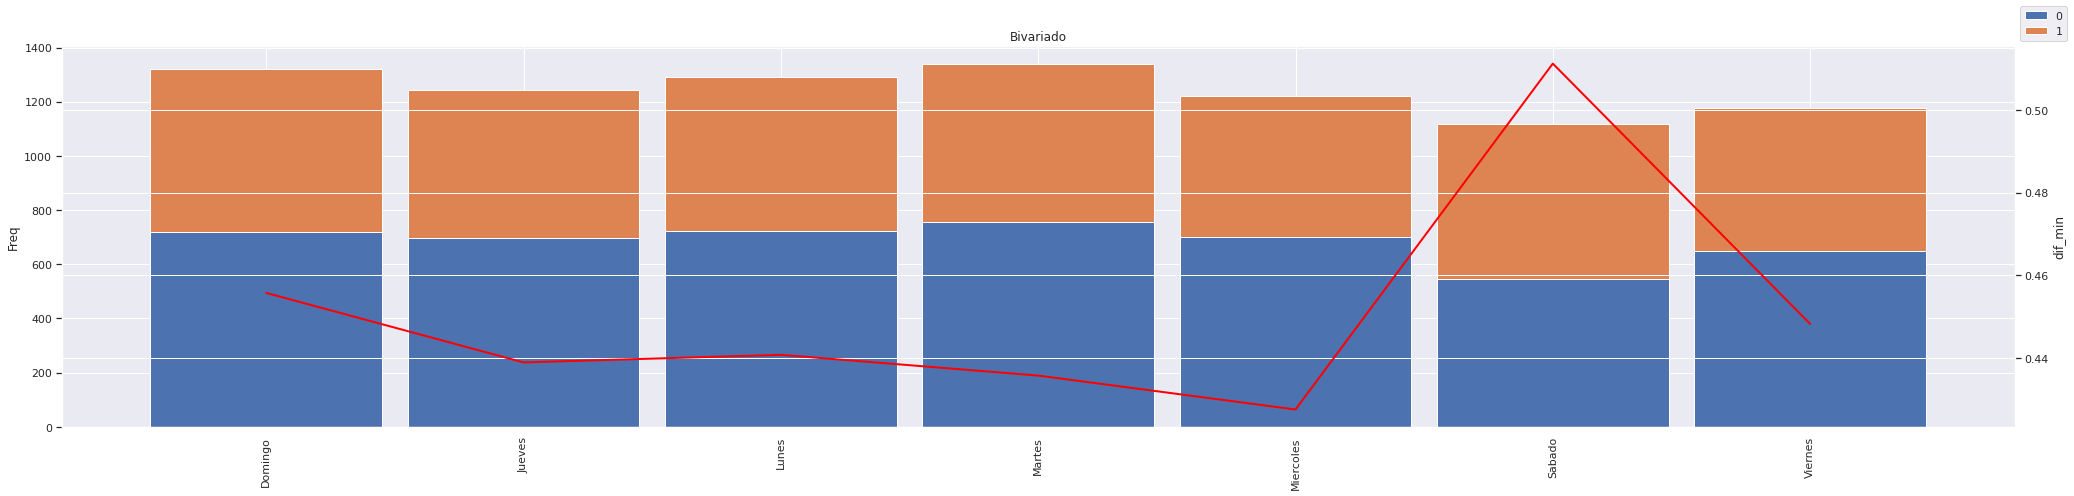

tipVuelo


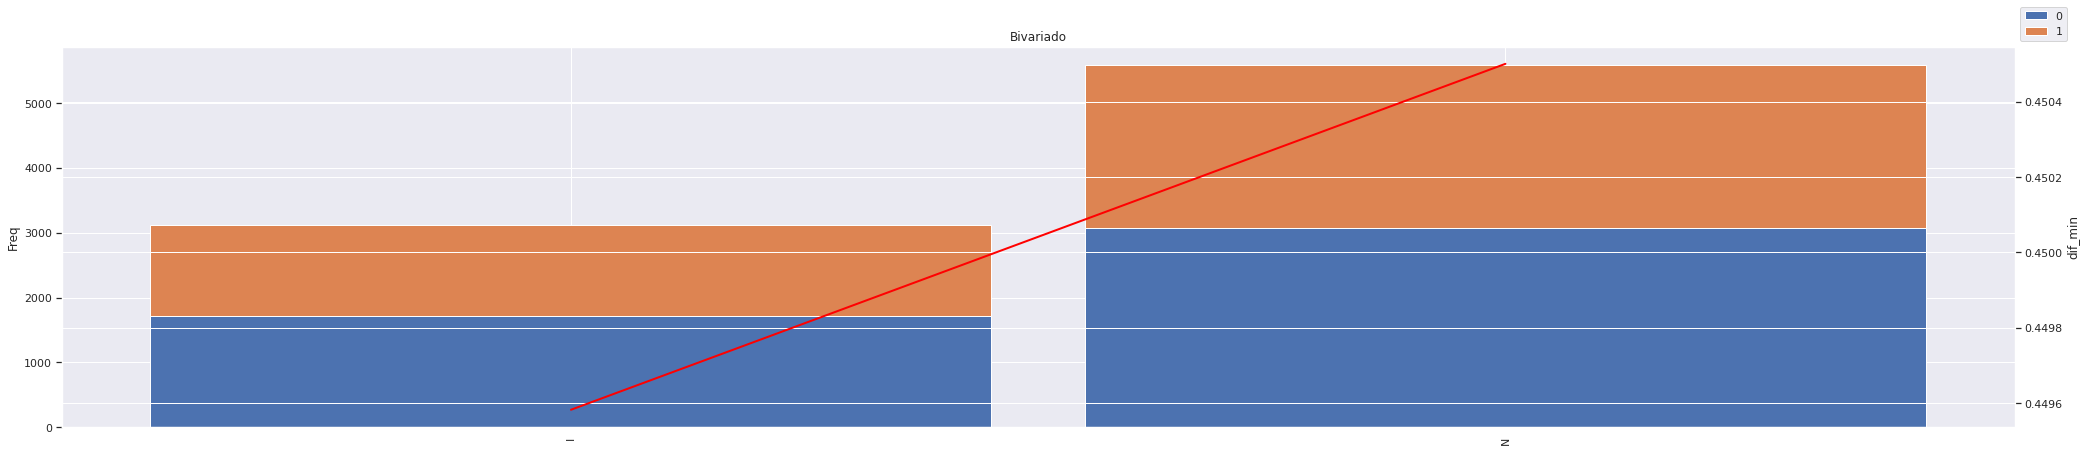

nombAerolineaOperado


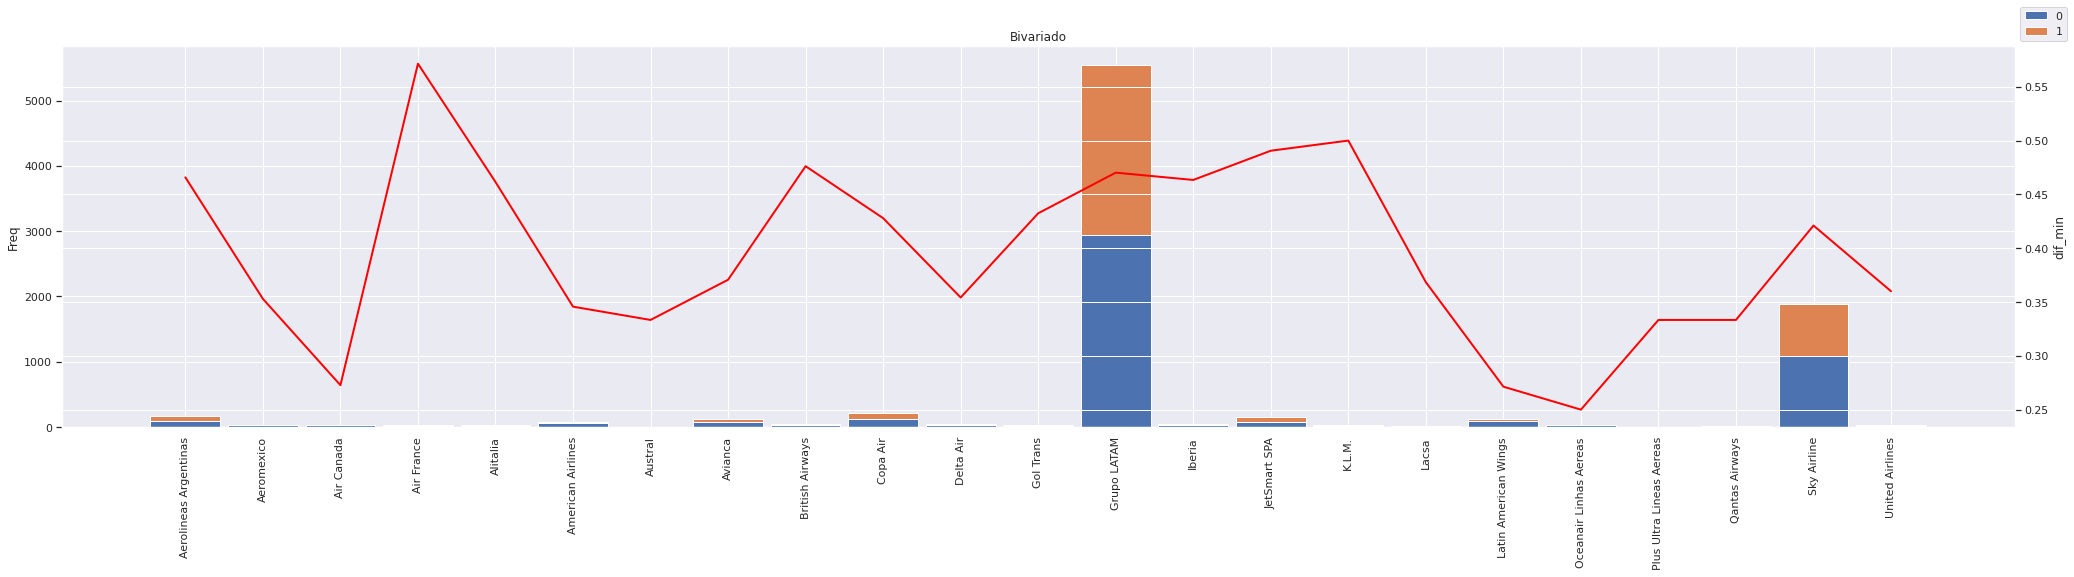

nombCiudadOrig


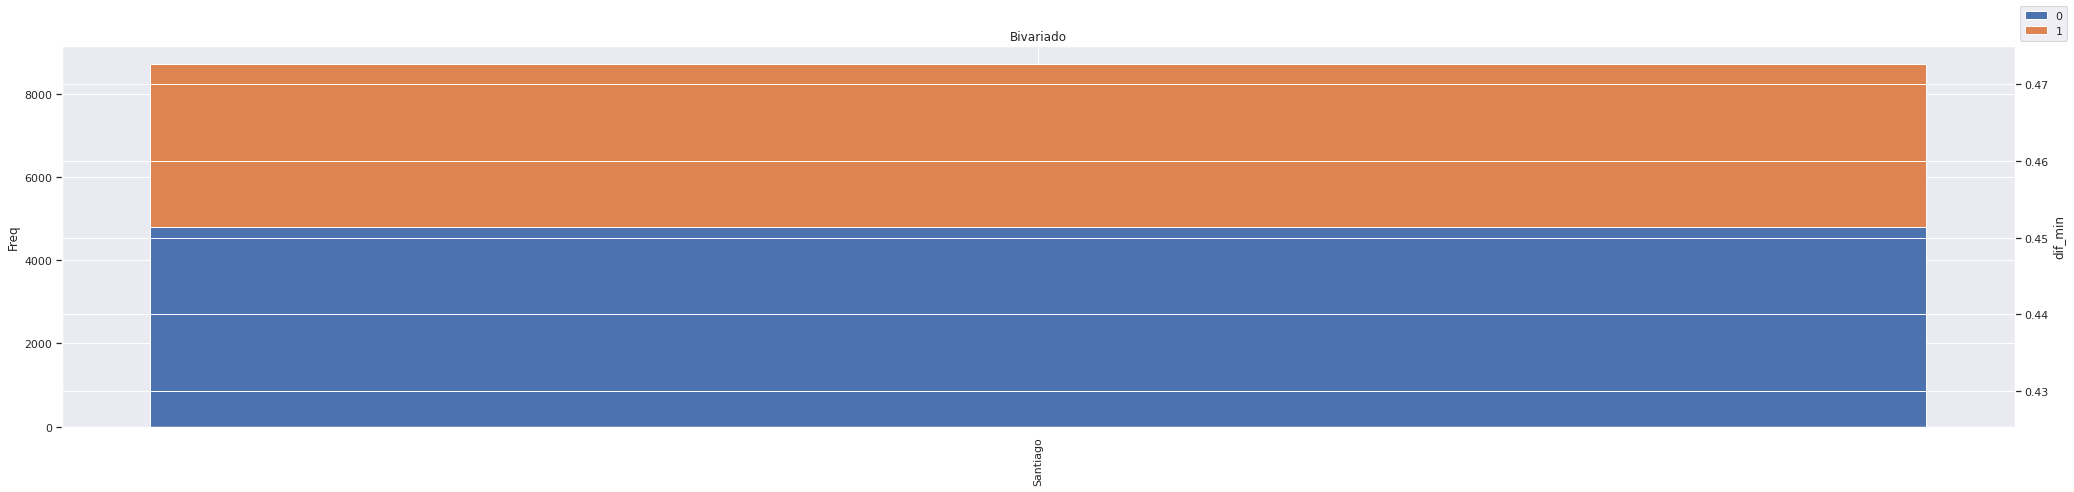

nombCiudadDest


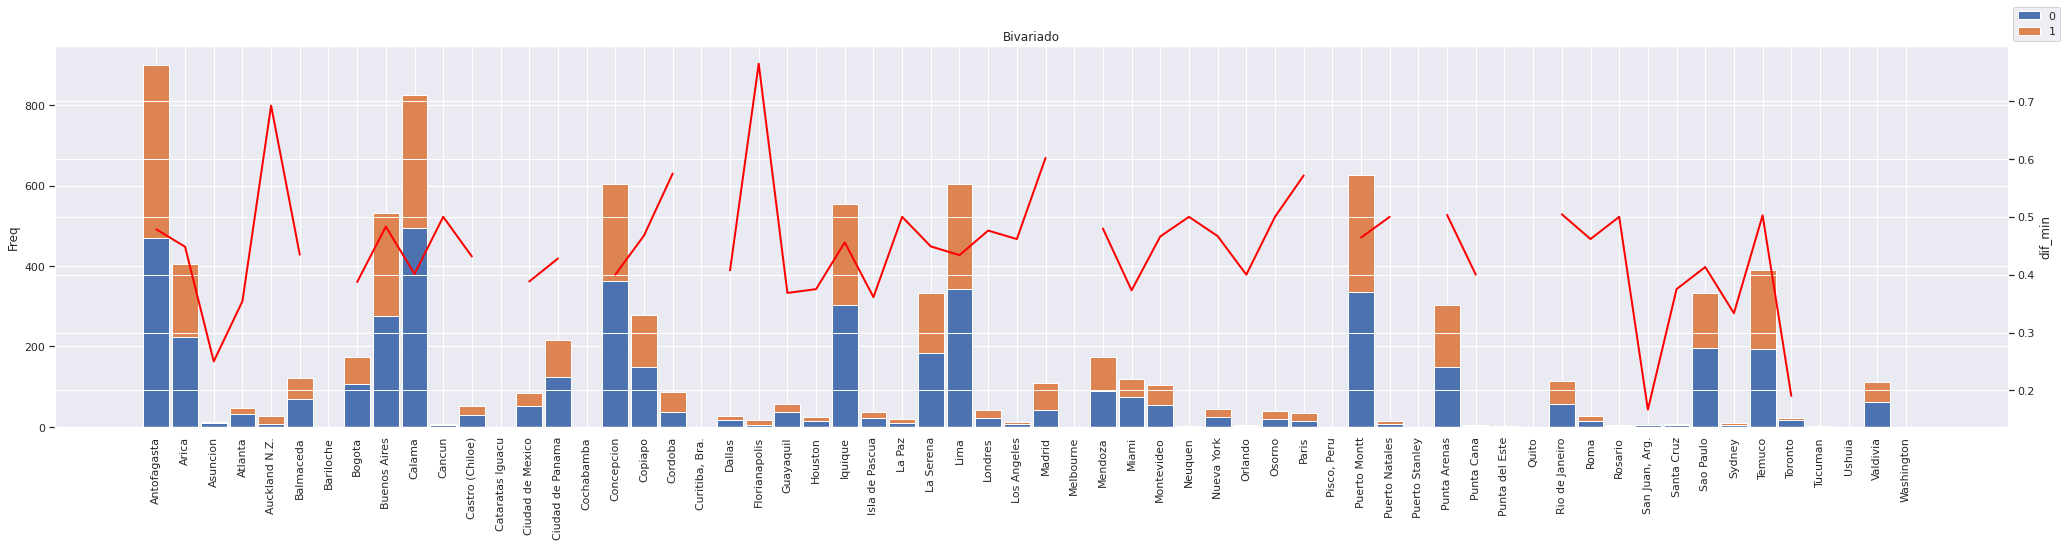

<Figure size 2520x504 with 0 Axes>

In [199]:
plot_graph_bivariable(df_analisis, meta,'dif_min')

Este análisis nos permite visualizar por tipo categoria de la variable cualitativa y decil de la variable cuantitativa su participación con respecto al target. Esto representa lo que se llama Target Encoding. Nos ayudará en saber como podemos agrupar las variables, así como la representatividad con respecto al target de importancia

# Outliers

# Preparación de los datos

In [ ]:
dataVuelos = df_analisis.copy()

### Agrupando según ratio de Conversión

In [ ]:
dataVuelos.describe(include='category')

,codCiudadDestProg,codAeroVueloProg,codCiudadDestOper,codAeroVueloOper,diaMesOperVuelo,nroMesOperVuelo,anioOperVuelo,diaSem,tipVuelo,aerolineaOpera,nombCiudadOrig,nombCiudadDest,temporadaAlta,partesDia,horaOperVuelo,cambioNroVuelo,cambioCodAeroVuelo
count,68206,68206,68206,68206,68206,68206,68206,68206,68206,68206,68206,68206,68206,68206,68206,68206,68206
unique,64,30,63,32,31,12,2,7,2,23,1,62,2,3,24,2,2
top,SCFA,LAN,SCFA,LAN,20,12,2017,Viernes,N,Grupo LATAM,Santiago,Buenos Aires,0,tarde,7,0,0
freq,5787,37611,5786,20988,2290,6356,68204,10292,36966,40892,68206,6335,58051,25506,4570,63687,49537


In [ ]:
# Var: codCiudadDestProg
cross_target(dataVuelos,'codCiudadDestProg','target')

----------------------------------------------------------------
---- Var:  codCiudadDestProg
   Atributo  Cantidad    %Total
0      SCFA      5787  8.484591
1      SPJC      5270  7.726593
2      SCCF      5145  7.543325
3      SCTE      4357  6.388001
4      SCIE      3995  5.857256
5      SCDA      3747  5.493652
6      SBGR      3570  5.234144
7      SAEZ      3240  4.750315
8      SABE      3094  4.536258
9      SCQP      2583  3.787057
10     SCAR      2436  3.571533
11     SCSE      2410  3.533413
12     SCCI      2105  3.086239
13     MPTO      1850  2.712371
14     SCAT      1780  2.609741
15     SAME      1625  2.382488
16     SKBO      1604  2.351699
17     SBGL      1434  2.102454
18     SUMU      1066  1.562912
19     SACO      1023  1.499868
20     KMIA      1015  1.488139
21     LEMD       894  1.310735
22     SCBA       843  1.235962
23     SCVD       753  1.104008
24     MMMX       700  1.026303
25     SCIP       452  0.662698
26     SEGU       423  0.620180
27     KJF

In [ ]:
# Definición de agrupación
def def_codCiudadDestProg(x):
    if x in ['SCFA','SPJC','SCCF','SCTE','SCIE','SCDA','SBGR','SAEZ','SABE','SCQP','SCAR','SCSE',
             'SCCI','MPTO','SCAT','SAME','SKBO','SBGL','SUMU','SACO','KMIA','LEMD','SCBA','SCVD','MMMX']:
        return x
    else:
        return 'OTRO'

dataVuelos['codCiudadDestProg'] = dataVuelos['codCiudadDestProg'].apply(lambda x: def_codCiudadDestProg(x))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


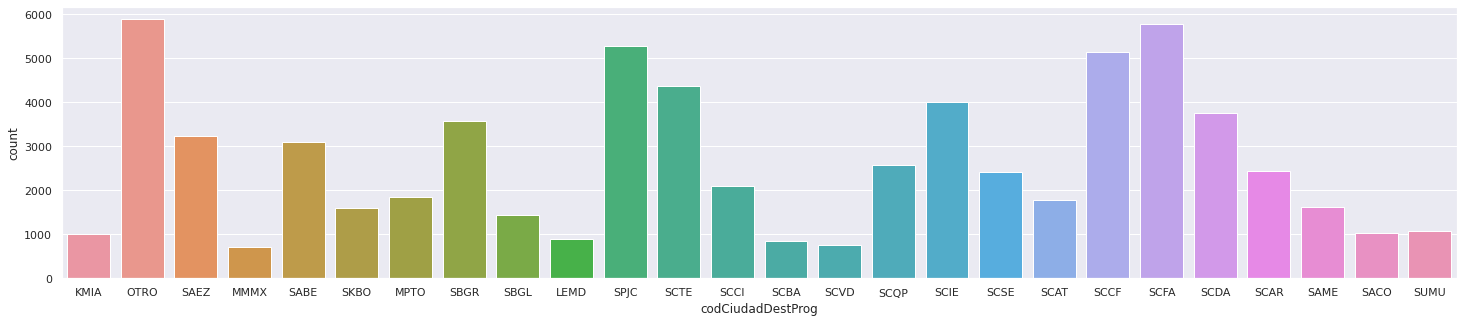

In [ ]:
plt.figure(figsize=(25,5))
sns.countplot(dataVuelos['codCiudadDestProg'])
plt.show()

In [ ]:
cross_target(dataVuelos,'codCiudadDestProg','target')

----------------------------------------------------------------
---- Var:  codCiudadDestProg
   Atributo  Cantidad    %Total
0      OTRO      5880  8.620942
1      SCFA      5787  8.484591
2      SPJC      5270  7.726593
3      SCCF      5145  7.543325
4      SCTE      4357  6.388001
5      SCIE      3995  5.857256
6      SCDA      3747  5.493652
7      SBGR      3570  5.234144
8      SAEZ      3240  4.750315
9      SABE      3094  4.536258
10     SCQP      2583  3.787057
11     SCAR      2436  3.571533
12     SCSE      2410  3.533413
13     SCCI      2105  3.086239
14     MPTO      1850  2.712371
15     SCAT      1780  2.609741
16     SAME      1625  2.382488
17     SKBO      1604  2.351699
18     SBGL      1434  2.102454
19     SUMU      1066  1.562912
20     SACO      1023  1.499868
21     KMIA      1015  1.488139
22     LEMD       894  1.310735
23     SCBA       843  1.235962
24     SCVD       753  1.104008
25     MMMX       700  1.026303

   codCiudadDestProg % ratio_conv
6      

In [ ]:
# Var: codAeroVueloProg
cross_target(dataVuelos,'codAeroVueloProg','target')

----------------------------------------------------------------
---- Var:  codAeroVueloProg
   Atributo  Cantidad     %Total
0       LAN     37611  55.143243
1       SKU     14298  20.962965
2       TAM      3049   4.470281
3       ARG      1949   2.857520
4       CMP      1850   2.712371
5       LAW      1574   2.307715
6       AVA      1152   1.689001
7       JAT      1095   1.605431
8       GLO       806   1.181714
9       AAL       757   1.109873
10      ACA       565   0.828373
11      IBE       362   0.530745
12      AFR       358   0.524881
13      DAL       358   0.524881
14      AMX       351   0.514617
15      UAL       335   0.491159
16      ONE       279   0.409055
17      AZA       259   0.379732
18      KLM       251   0.368003
19      LAP       216   0.316688
20      BAW       205   0.300560
21      QFU       195   0.285899
22      JMR       100   0.146615
23      LRC        92   0.134885
24      AUT        74   0.108495
25      PUE        49   0.071841
26      LXP     

In [ ]:
# Definición de agrupación
def def_codAeroVueloProg(x):
    if x in ['LAN','SKU','TAM']:
        return x
    else:
        return 'OTRO'

dataVuelos['codAeroVueloProg'] = dataVuelos['codAeroVueloProg'].apply(lambda x: def_codAeroVueloProg(x))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


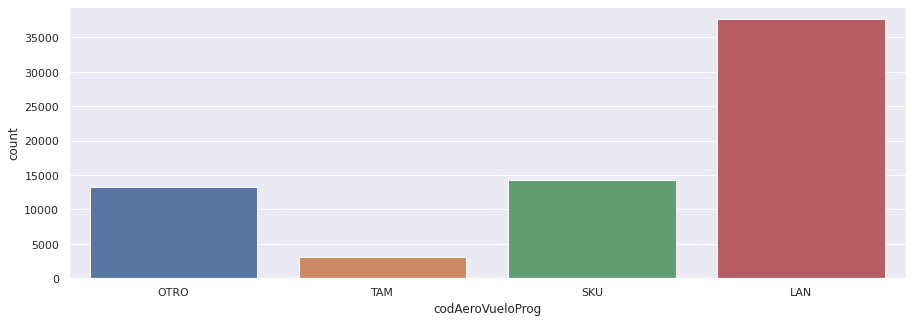

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(dataVuelos['codAeroVueloProg'])
plt.show()

In [ ]:
cross_target(dataVuelos,'codAeroVueloProg','target')

----------------------------------------------------------------
---- Var:  codAeroVueloProg
  Atributo  Cantidad     %Total
0      LAN     37611  55.143243
1      SKU     14298  20.962965
2     OTRO     13248  19.423511
3      TAM      3049   4.470281

  codAeroVueloProg % ratio_conv
3              TAM    25.582158
1             OTRO    21.444746
2              SKU    17.764722
0              LAN    17.157215


- Se observa que la categoria **LAN** tiene un 55% y un ratio de conversión del 17% con respecto al target.
- Se observa que la categoria **SKU** tiene un 21% y un ratio de conversión del 18% con respecto al target.
- Se observa que la categoria **TAM** tiene un 4.4% y un ratio de conversión del **26%** con respecto al target. **Se aprecia que a pesar de tener una poca cantidad de registros, tiene un alto nivel de conversión con respecto al target, lo que permite diferenciar una clase de otra.
- La categoria **OTRO** al ser agrupada paso a tener un alto ratio de conversión, esto es mejor que tener una alta variabilidad con el resto de categorias

In [ ]:
# Var: codCiudadDestOper
cross_target(dataVuelos,'codCiudadDestOper','target')

----------------------------------------------------------------
---- Var:  codCiudadDestOper
   Atributo  Cantidad    %Total
0      SCFA      5786  8.483125
1      SPJC      5270  7.726593
2      SCCF      5146  7.544791
3      SCTE      4357  6.388001
4      SCIE      3993  5.854324
5      SCDA      3747  5.493652
6      SBGR      3569  5.232677
7      SAEZ      3241  4.751781
8      SABE      3094  4.536258
9      SCQP      2589  3.795854
10     SCAR      2436  3.571533
11     SCSE      2410  3.533413
12     SCCI      2105  3.086239
13     MPTO      1850  2.712371
14     SCAT      1780  2.609741
15     SAME      1625  2.382488
16     SKBO      1604  2.351699
17     SBGL      1435  2.103920
18     SUMU      1066  1.562912
19     SACO      1023  1.499868
20     KMIA      1016  1.489605
21     LEMD       894  1.310735
22     SCBA       839  1.230097
23     SCVD       753  1.104008
24     MMMX       700  1.026303
25     SCIP       452  0.662698
26     SEGU       422  0.618714
27     KJF

In [ ]:
# Definición de agrupación
def def_codCiudadDestOper(x):
    if x in ['SCFA','SPJC','SCCF','SCTE','SCIE','SCDA','SBGR','SAEZ','SABE','SCQP','SCAR','SCSE',
             'SCCI','MPTO','SCAT','SAME','SKBO','SBGL','SUMU','SACO','KMIA','LEMD','SCBA','SCVD','MMMX']:
        return x
    else:
        return 'OTRO'

dataVuelos['codCiudadDestOper'] = dataVuelos['codCiudadDestOper'].apply(lambda x: def_codCiudadDestOper(x))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


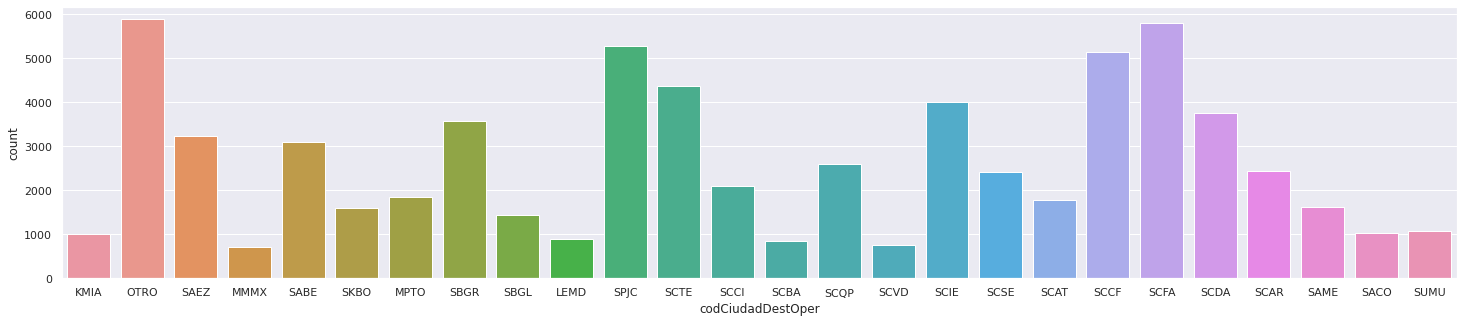

In [ ]:
plt.figure(figsize=(25,5))
sns.countplot(dataVuelos['codCiudadDestOper'])
plt.show()

In [ ]:
cross_target(dataVuelos,'codCiudadDestOper','target')

----------------------------------------------------------------
---- Var:  codCiudadDestOper
   Atributo  Cantidad    %Total
0      OTRO      5878  8.618010
1      SCFA      5786  8.483125
2      SPJC      5270  7.726593
3      SCCF      5146  7.544791
4      SCTE      4357  6.388001
5      SCIE      3993  5.854324
6      SCDA      3747  5.493652
7      SBGR      3569  5.232677
8      SAEZ      3241  4.751781
9      SABE      3094  4.536258
10     SCQP      2589  3.795854
11     SCAR      2436  3.571533
12     SCSE      2410  3.533413
13     SCCI      2105  3.086239
14     MPTO      1850  2.712371
15     SCAT      1780  2.609741
16     SAME      1625  2.382488
17     SKBO      1604  2.351699
18     SBGL      1435  2.103920
19     SUMU      1066  1.562912
20     SACO      1023  1.499868
21     KMIA      1016  1.489605
22     LEMD       894  1.310735
23     SCBA       839  1.230097
24     SCVD       753  1.104008
25     MMMX       700  1.026303

   codCiudadDestOper % ratio_conv
6      

Al aplicar este tipo de tratamiento podemos observar que esta variable se comporta de la misma manera que la variable **codCiudadDestProg** en ese sentido eliminaremos una de ellas

In [ ]:
dataVuelos.drop(['codCiudadDestProg'],axis=1,inplace=True)

In [ ]:
# Var: codAeroVueloOper
cross_target(dataVuelos,'codAeroVueloOper','target')

----------------------------------------------------------------
---- Var:  codAeroVueloOper
   Atributo  Cantidad     %Total
0       LAN     20988  30.771486
1       LXP     14558  21.344163
2       SKU     14298  20.962965
3       TAM      3046   4.465883
4       ARG      1946   2.853121
5       CMP      1850   2.712371
6       JMR      1647   2.414744
7       LPE      1214   1.779902
8       JAT      1095   1.605431
9       AVA       885   1.297540
10      GLO       806   1.181714
11      AAL       757   1.109873
12      ACA       565   0.828373
13      DSM       493   0.722810
14      LNE       374   0.548339
15      IBE       362   0.530745
16      DAL       358   0.524881
17      AFR       358   0.524881
18      LRC       357   0.523414
19      AMX       351   0.514617
20      UAL       335   0.491159
21      ONE       279   0.409055
22      AZA       259   0.379732
23      KLM       251   0.368003
24      LAP       219   0.321086
25      BAW       205   0.300560
26      QFA     

In [ ]:
# Definición de agrupación
def def_codAeroVueloOper(x):
    if x in ['LAN','LXP','SKU','TAM']:
        return x
    else:
        return 'OTRO'

dataVuelos['codAeroVueloOper'] = dataVuelos['codAeroVueloOper'].apply(lambda x: def_codAeroVueloOper(x))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


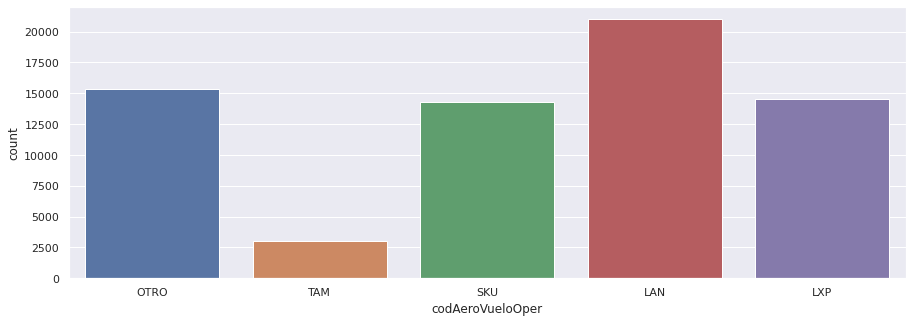

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(dataVuelos['codAeroVueloOper'])
plt.show()

In [ ]:
cross_target(dataVuelos,'codAeroVueloOper','target')

----------------------------------------------------------------
---- Var:  codAeroVueloOper
  Atributo  Cantidad     %Total
0      LAN     20988  30.771486
1     OTRO     15316  22.455502
2      LXP     14558  21.344163
3      SKU     14298  20.962965
4      TAM      3046   4.465883

  codAeroVueloOper % ratio_conv
4              TAM    25.574524
2             OTRO    21.879081
0              LAN    18.467696
3              SKU    17.764722
1              LXP    14.205248


- Se observa que la categoria **LAN** tiene un 30% y un ratio de conversión del 18.4% con respecto al target.
- Se observa que la categoria **SKU** tiene un 21% y un ratio de conversión del 18% con respecto al target.
- Se observa que la categoria **SKU** tiene un 21% y un ratio de conversión del 14% con respecto al target.
- Se observa que la categoria **TAM** tiene un 4.4% y un ratio de conversión del **26%** con respecto al target. **Se aprecia que a pesar de tener una poca cantidad de registros, tiene un alto nivel de conversión con respecto al target, lo que permite diferenciar una clase de otra.
- La categoria **OTRO** al ser agrupada paso a tener un alto ratio de conversión, esto es mejor que tener una alta variabilidad con el resto de categorias

Por otro lado se puede observar que el codigo de la aerolinea de programación y operación son diferentes una de otra es por eso que se creó la variable **cambioCodAeroVuelo** con el objetivo de medir esta variabilidad.

In [ ]:
# Var: anioOperVuelo
cross_target(dataVuelos,'anioOperVuelo','target')

----------------------------------------------------------------
---- Var:  anioOperVuelo
  Atributo  Cantidad     %Total
0     2017     68204  99.997068
1     2018         2   0.002932

   anioOperVuelo  % ratio_conv
1         2018.0      50.00000
0         2017.0      18.49305


Se elimina esta variable debido a que tiene poca variabilidad

In [ ]:
dataVuelos.drop(['anioOperVuelo'],axis=1,inplace=True)

In [ ]:
# Var: tipVuelo
cross_target(dataVuelos,'tipVuelo','target')

----------------------------------------------------------------
---- Var:  tipVuelo
  Atributo  Cantidad     %Total
0        N     36966  54.197578
1        I     31240  45.802422

  tipVuelo % ratio_conv
0        I    22.560819
1        N    15.057079


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


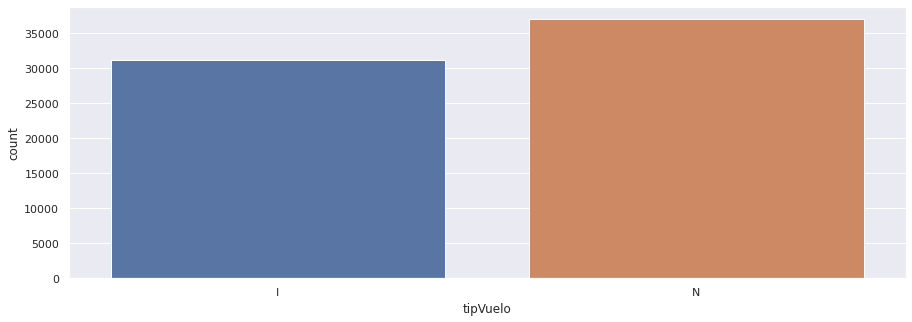

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(dataVuelos['tipVuelo'])
plt.show()

A pesar de tener menor proporción la categoria **Internacional** tien un nivel alto de conversión, para predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago de Chile (SCL).

In [ ]:
# Var: aerolineaOpera
cross_target(dataVuelos,'aerolineaOpera','target')

----------------------------------------------------------------
---- Var:  aerolineaOpera
                    Atributo  Cantidad     %Total
0                Grupo LATAM     40892  59.953670
1                Sky Airline     14298  20.962965
2      Aerolineas Argentinas      1949   2.857520
3                   Copa Air      1850   2.712371
4       Latin American Wings      1674   2.454330
5                    Avianca      1152   1.689001
6               JetSmart SPA      1095   1.605431
7                  Gol Trans       806   1.181714
8          American Airlines       757   1.109873
9                 Air Canada       565   0.828373
10                    Iberia       362   0.530745
11                 Delta Air       358   0.524881
12                Air France       358   0.524881
13                Aeromexico       351   0.514617
14           United Airlines       335   0.491159
15    Oceanair Linhas Aereas       279   0.409055
16                  Alitalia       259   0.379732
17       

In [ ]:
# Definición de agrupación
def def_aerolineaOpera(x):
    if x in ['Grupo LATAM','Sky Airline']:
        return x
    else:
        return 'OTRO'

dataVuelos['aerolineaOpera'] = dataVuelos['aerolineaOpera'].apply(lambda x: def_aerolineaOpera(x))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


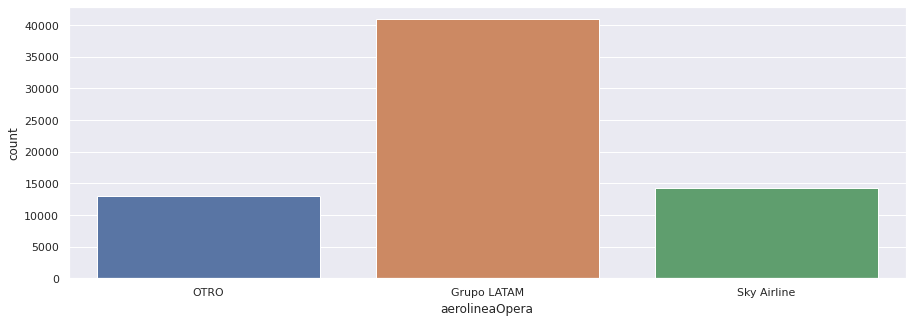

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(dataVuelos['aerolineaOpera'])
plt.show()

In [ ]:
dataVuelos.loc[dataVuelos['aerolineaOpera']=='Grupo LATAM',['aerolineaOpera']]='Grupo_LATAM'
dataVuelos.loc[dataVuelos['aerolineaOpera']=='Sky Airline',['aerolineaOpera']]='Sky_Airline'

In [ ]:
cross_target(dataVuelos,'aerolineaOpera','target')

----------------------------------------------------------------
---- Var:  aerolineaOpera
      Atributo  Cantidad     %Total
0  Grupo_LATAM     40892  59.953670
1  Sky_Airline     14298  20.962965
2         OTRO     13016  19.083365

  aerolineaOpera % ratio_conv
1           OTRO    21.266134
0    Grupo_LATAM    17.866575
2    Sky_Airline    17.764722


- Se observa que la categoria **Grupo LATAM** tiene un 60% y un ratio de conversión del 17.7% con respecto al target.
- Se observa que la categoria **Sky Airline** tiene un 21% y un ratio de conversión del 18% con respecto al target.
- La categoria **OTRO** al ser agrupada paso a tener un alto ratio de conversión, esto es mejor que tener una alta variabilidad con el resto de categorias

In [ ]:
# Var: nombCiudadOrig
cross_target(dataVuelos,'nombCiudadOrig','target')

----------------------------------------------------------------
---- Var:  nombCiudadOrig
   Atributo  Cantidad  %Total
0  Santiago     68206   100.0

  nombCiudadOrig % ratio_conv
0       Santiago    18.493974


In [ ]:
dataVuelos.drop(['nombCiudadOrig'],axis=1,inplace=True)

Se elimina esta variable debido a que tiene poca variabilidad

In [ ]:
# Var: nombCiudadDest
cross_target(dataVuelos,'nombCiudadDest','target')

----------------------------------------------------------------
---- Var:  nombCiudadDest
            Atributo  Cantidad    %Total
0       Buenos Aires      6335  9.288039
1        Antofagasta      5786  8.483125
2               Lima      5270  7.726593
3             Calama      5146  7.544791
4       Puerto Montt      4357  6.388001
5         Concepcion      3993  5.854324
6            Iquique      3747  5.493652
7          Sao Paulo      3569  5.232677
8             Temuco      2589  3.795854
9              Arica      2436  3.571533
10         La Serena      2410  3.533413
11      Punta Arenas      2105  3.086239
12  Ciudad de Panama      1850  2.712371
13           Copiapo      1780  2.609741
14           Mendoza      1625  2.382488
15            Bogota      1604  2.351699
16    Rio de Janeiro      1435  2.103920
17        Montevideo      1066  1.562912
18           Cordoba      1023  1.499868
19             Miami      1016  1.489605
20            Madrid       894  1.310735
21     

In [ ]:
# Definición de agrupación
def def_nombCiudadDest(x):
    if x in ['Buenos Aires','Antofagasta','Lima','Calama','Puerto Montt','Concepcion','Iquique','Sao Paulo','Temuco','Arica','La Serena','Punta Arenas','Ciudad de Panama',
             'Copiapo','Mendoza','Bogota','Rio de Janeiro','Montevideo','Cordoba','Miami','Madrid','Balmaceda','Valdivia','Ciudad de Mexico']:
        return x
    else:
        return 'OTRO'

dataVuelos['nombCiudadDest'] = dataVuelos['nombCiudadDest'].apply(lambda x: def_nombCiudadDest(x))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


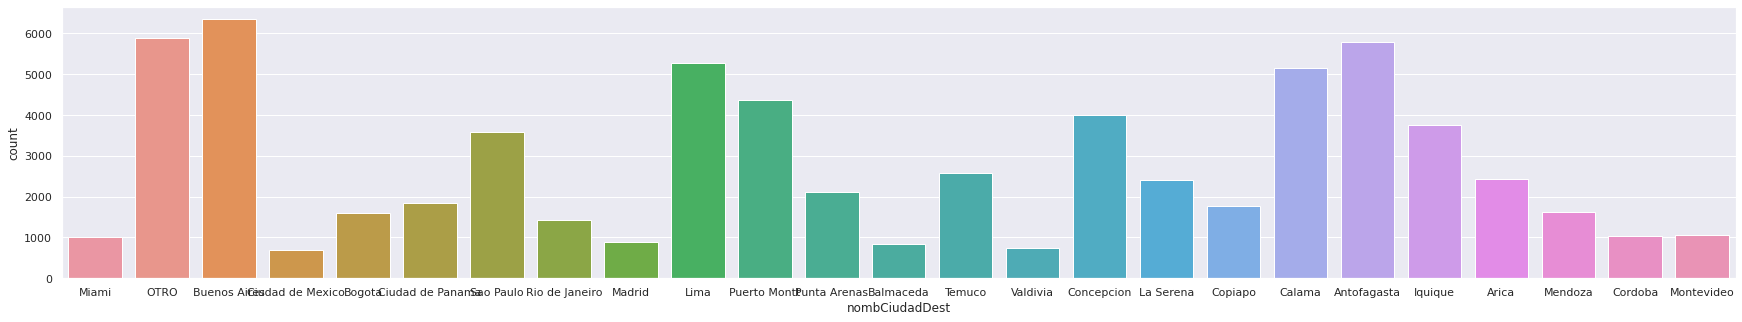

In [ ]:
plt.figure(figsize=(30,5))
sns.countplot(dataVuelos['nombCiudadDest'])
plt.show()

In [ ]:
cross_target(dataVuelos,'nombCiudadDest','target')

----------------------------------------------------------------
---- Var:  nombCiudadDest
            Atributo  Cantidad    %Total
0       Buenos Aires      6335  9.288039
1               OTRO      5878  8.618010
2        Antofagasta      5786  8.483125
3               Lima      5270  7.726593
4             Calama      5146  7.544791
5       Puerto Montt      4357  6.388001
6         Concepcion      3993  5.854324
7            Iquique      3747  5.493652
8          Sao Paulo      3569  5.232677
9             Temuco      2589  3.795854
10             Arica      2436  3.571533
11         La Serena      2410  3.533413
12      Punta Arenas      2105  3.086239
13  Ciudad de Panama      1850  2.712371
14           Copiapo      1780  2.609741
15           Mendoza      1625  2.382488
16            Bogota      1604  2.351699
17    Rio de Janeiro      1435  2.103920
18        Montevideo      1066  1.562912
19           Cordoba      1023  1.499868
20             Miami      1016  1.489605
21     

Se aprecia que **Buenos Aires** y **Lima**, dos destinos internacionales, tienen un alto porcentaje de valores así con un alto valor de conversión.

Por otro lado debido a que esta variable se convertiráen dummy para evitar problemas con el nombre se realiza la siguiente transformación:

In [ ]:
dataVuelos.loc[dataVuelos['nombCiudadDest']=='Buenos Aires',['nombCiudadDest']]='Buenos_Aires'
dataVuelos.loc[dataVuelos['nombCiudadDest']=='Puerto Montt',['nombCiudadDest']]='Puerto_Montt'
dataVuelos.loc[dataVuelos['nombCiudadDest']=='Sao Paulo',['nombCiudadDest']]='Sao_Paulo'
dataVuelos.loc[dataVuelos['nombCiudadDest']=='La Serena',['nombCiudadDest']]='La_Serena'
dataVuelos.loc[dataVuelos['nombCiudadDest']=='Sao Paulo',['nombCiudadDest']]='Sao_Paulo'
dataVuelos.loc[dataVuelos['nombCiudadDest']=='Punta Arenas',['nombCiudadDest']]='Punta_Arenas'
dataVuelos.loc[dataVuelos['nombCiudadDest']=='Ciudad de Panama',['nombCiudadDest']]='Ciudad_de_Panama'
dataVuelos.loc[dataVuelos['nombCiudadDest']=='Rio de Janeiro',['nombCiudadDest']]='Rio_de_Janeiro'
dataVuelos.loc[dataVuelos['nombCiudadDest']=='Ciudad de Mexico',['nombCiudadDest']]='Ciudad_de_Mexico'

### Transformacion de datos del tipo Binario

Estos datos deben ser transformados en valores cuantitativas para que puedan ingresar al modelo

In [ ]:
# Aplicación de una función map sobre el tipo de Vuelo
dicc_tipVuelo = {'N': 0,'I': 1}

dataVuelos['tipVuelo'] = dataVuelos['tipVuelo'].map(dicc_tipVuelo)
dataVuelos['tipVuelo'] = dataVuelos['tipVuelo'].astype('int64')

In [ ]:
# Transformacion de datos del tipo string a int64
dataVuelos['temporadaAlta'] = dataVuelos['temporadaAlta'].astype('int64')
dataVuelos['cambioNroVuelo'] = dataVuelos['cambioNroVuelo'].astype('int64')
dataVuelos['cambioCodAeroVuelo'] = dataVuelos['cambioCodAeroVuelo'].astype('int64')

### Variable según su naturaleza: Cualitatia ordinal

In [ ]:
# Var: diaSem
cross_target(dataVuelos,'diaSem','target')

----------------------------------------------------------------
---- Var:  diaSem
    Atributo  Cantidad     %Total
0    Viernes     10292  15.089582
1     Jueves     10251  15.029470
2      Lunes     10131  14.853532
3    Domingo      9796  14.362373
4  Miercoles      9722  14.253878
5     Martes      9662  14.165909
6     Sabado      8352  12.245257

      diaSem % ratio_conv
6    Viernes     22.20171
2      Lunes    20.215181
1     Jueves    19.949273
4  Miercoles    17.084962
3     Martes    16.911613
5     Sabado    16.319444
0    Domingo    16.108616


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


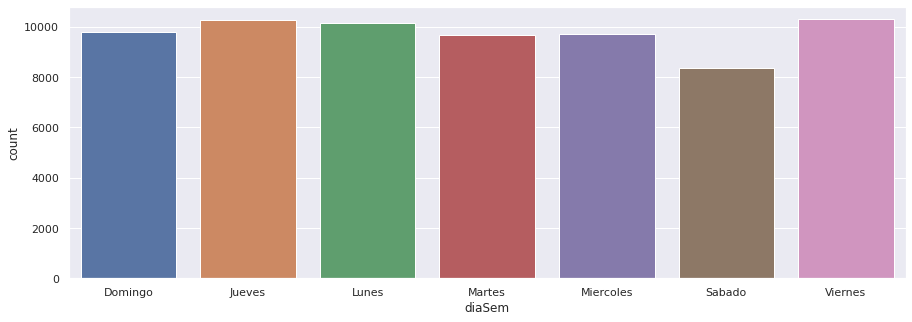

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(dataVuelos['diaSem'])
plt.show()

La proporción de viajes en cuanto al dia de semana no tiene mucha diferencia, son proporciones muy equitativas. Sin embargo su ratio de conversión es mayor los **Viernes** y **Lunes** que los **Martes, Sabado y Domingo**

Por otro lado observamos que la variable es del tipo ordinal, conservamos su naturaleza.

In [ ]:
dicc_diaSem = {'Lunes': 0,
 'Martes': 1,
 'Miercoles':2,
 'Jueves':3,
 'Viernes':4,
 'Sabado': 5, 
 'Domingo':6, 
}

dataVuelos['diaSem'] = dataVuelos['diaSem'].map(dicc_diaSem)
dataVuelos['diaSem'] = dataVuelos['diaSem'].astype('int64')

In [ ]:
cross_target(dataVuelos,'diaSem','target')

----------------------------------------------------------------
---- Var:  diaSem
   Atributo  Cantidad     %Total
0         4     10292  15.089582
1         3     10251  15.029470
2         0     10131  14.853532
3         6      9796  14.362373
4         2      9722  14.253878
5         1      9662  14.165909
6         5      8352  12.245257

   diaSem  % ratio_conv
4     4.0     22.201710
0     0.0     20.215181
3     3.0     19.949273
2     2.0     17.084962
1     1.0     16.911613
5     5.0     16.319444
6     6.0     16.108616


In [ ]:
# Var: partesDia
cross_target(dataVuelos,'partesDia','target')

----------------------------------------------------------------
---- Var:  partesDia
  Atributo  Cantidad     %Total
0    tarde     25506  37.395537
1   mañana     25352  37.169750
2    noche     17348  25.434712

  partesDia % ratio_conv
1     noche    20.002306
2     tarde    19.940406
0    mañana    16.006627


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


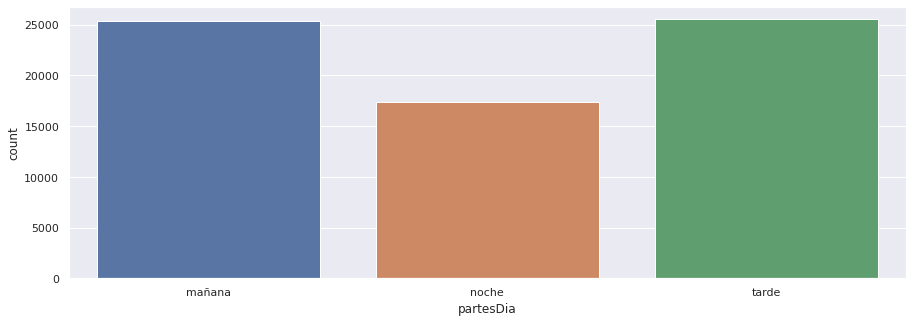

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(dataVuelos['partesDia'])
plt.show()

Se observa que la mayoria de las personas prefiere viajar por la mañana, tarde. Sin embargo la categoria **noche** tiene mayor ratio de conversión con respecto al target

In [ ]:
dicc_partesDia = {'mañana': 0,
 'tarde': 1,
 'noche':2
}

dataVuelos['partesDia'] = dataVuelos['partesDia'].map(dicc_partesDia)
dataVuelos['partesDia'] = dataVuelos['partesDia'].astype('int64')

In [ ]:
cross_target(dataVuelos,'partesDia','target')

----------------------------------------------------------------
---- Var:  partesDia
   Atributo  Cantidad     %Total
0         1     25506  37.395537
1         0     25352  37.169750
2         2     17348  25.434712

   partesDia  % ratio_conv
2        2.0     20.002306
1        1.0     19.940406
0        0.0     16.006627


### Transformacion de Variables Categoricas Nominales a Dummies

In [ ]:
dataVuelos.describe(include=['object','category'])

,codAeroVueloProg,codCiudadDestOper,codAeroVueloOper,diaMesOperVuelo,nroMesOperVuelo,aerolineaOpera,nombCiudadDest,horaOperVuelo
count,68206,68206,68206,68206,68206,68206,68206,68206
unique,4,26,5,31,12,3,25,24
top,LAN,OTRO,LAN,20,12,Grupo_LATAM,Buenos_Aires,7
freq,37611,5878,20988,2290,6356,40892,6335,4570


In [ ]:
vars_str = dataVuelos.select_dtypes(include=['object','category']).columns.tolist()
for var in vars_str:
  print("N de",var,":",dataVuelos[var].nunique())

N de codAeroVueloProg : 4
N de codCiudadDestOper : 26
N de codAeroVueloOper : 5
N de diaMesOperVuelo : 31
N de nroMesOperVuelo : 12
N de aerolineaOpera : 3
N de nombCiudadDest : 25
N de horaOperVuelo : 24


In [ ]:
vars_to_dummies = [
                   'codAeroVueloProg',
                   'codCiudadDestOper',
                   'codAeroVueloOper',
                   'diaMesOperVuelo',
                   'nroMesOperVuelo',
                   'aerolineaOpera',
                   'nombCiudadDest',
                   'horaOperVuelo']

In [ ]:
dataVuelos = pd.get_dummies(dataVuelos, columns = vars_to_dummies)
dataVuelos.head()

,fecVueloProg,fecVueloOper,diaSem,tipVuelo,difMinfecProgYfecOper,target,temporadaAlta,partesDia,cambioNroVuelo,cambioCodAeroVuelo,codAeroVueloProg_LAN,codAeroVueloProg_OTRO,codAeroVueloProg_SKU,codAeroVueloProg_TAM,codCiudadDestOper_KMIA,codCiudadDestOper_LEMD,codCiudadDestOper_MMMX,codCiudadDestOper_MPTO,codCiudadDestOper_OTRO,codCiudadDestOper_SABE,codCiudadDestOper_SACO,codCiudadDestOper_SAEZ,codCiudadDestOper_SAME,codCiudadDestOper_SBGL,codCiudadDestOper_SBGR,codCiudadDestOper_SCAR,codCiudadDestOper_SCAT,codCiudadDestOper_SCBA,codCiudadDestOper_SCCF,codCiudadDestOper_SCCI,codCiudadDestOper_SCDA,codCiudadDestOper_SCFA,codCiudadDestOper_SCIE,codCiudadDestOper_SCQP,codCiudadDestOper_SCSE,codCiudadDestOper_SCTE,codCiudadDestOper_SCVD,codCiudadDestOper_SKBO,codCiudadDestOper_SPJC,codCiudadDestOper_SUMU,codAeroVueloOper_LAN,codAeroVueloOper_LXP,codAeroVueloOper_OTRO,codAeroVueloOper_SKU,codAeroVueloOper_TAM,diaMesOperVuelo_1,diaMesOperVuelo_2,diaMesOperVuelo_3,diaMesOperVuelo_4,diaMesOperVuelo_5,...,aerolineaOpera_Sky_Airline,nombCiudadDest_Antofagasta,nombCiudadDest_Arica,nombCiudadDest_Balmaceda,nombCiudadDest_Bogota,nombCiudadDest_Buenos_Aires,nombCiudadDest_Calama,nombCiudadDest_Ciudad_de_Mexico,nombCiudadDest_Ciudad_de_Panama,nombCiudadDest_Concepcion,nombCiudadDest_Copiapo,nombCiudadDest_Cordoba,nombCiudadDest_Iquique,nombCiudadDest_La_Serena,nombCiudadDest_Lima,nombCiudadDest_Madrid,nombCiudadDest_Mendoza,nombCiudadDest_Miami,nombCiudadDest_Montevideo,nombCiudadDest_OTRO,nombCiudadDest_Puerto_Montt,nombCiudadDest_Punta_Arenas,nombCiudadDest_Rio_de_Janeiro,nombCiudadDest_Sao_Paulo,nombCiudadDest_Temuco,nombCiudadDest_Valdivia,horaOperVuelo_0,horaOperVuelo_1,horaOperVuelo_10,horaOperVuelo_11,horaOperVuelo_12,horaOperVuelo_13,horaOperVuelo_14,horaOperVuelo_15,horaOperVuelo_16,horaOperVuelo_17,horaOperVuelo_18,horaOperVuelo_19,horaOperVuelo_2,horaOperVuelo_20,horaOperVuelo_21,horaOperVuelo_22,horaOperVuelo_23,horaOperVuelo_3,horaOperVuelo_4,horaOperVuelo_5,horaOperVuelo_6,horaOperVuelo_7,horaOperVuelo_8,horaOperVuelo_9
0,2017-01-01 23:30:00,2017-01-01 23:33:00,6,1,3.0,0,0,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,2017-01-02 23:30:00,2017-01-02 23:39:00,0,1,9.0,0,0,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,2017-01-03 23:30:00,2017-01-03 23:39:00,1,1,9.0,0,0,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,2017-01-04 23:30:00,2017-01-04 23:33:00,2,1,3.0,0,0,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,2017-01-05 23:30:00,2017-01-05 23:28:00,3,1,-2.0,0,0,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


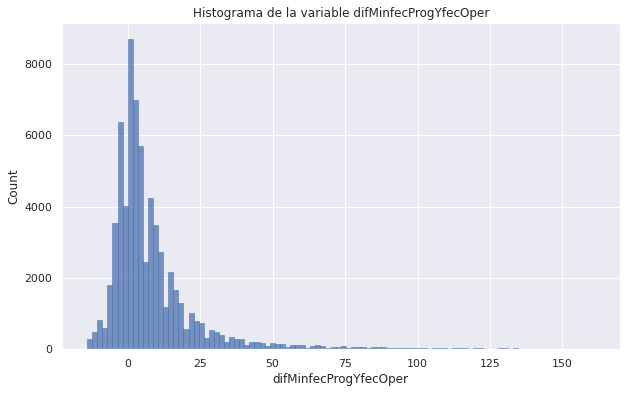

In [ ]:
# Analisis mediante un histograma
plt.figure(figsize=(10,6))
sns.histplot(dfVuelos['dif_min'],
             bins=100,
             edgecolor='b')
plt.title("Histograma de la variable dif_min")
plt.show()

Se observa una ligera **asimetria a la derecha (Cola a la derecha)**. Através de este histograma tambien podemos validar la presencia de algunos valores fuera del rango normal de distribución. Veamos un BOXPLOT para analizar estos puntos.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


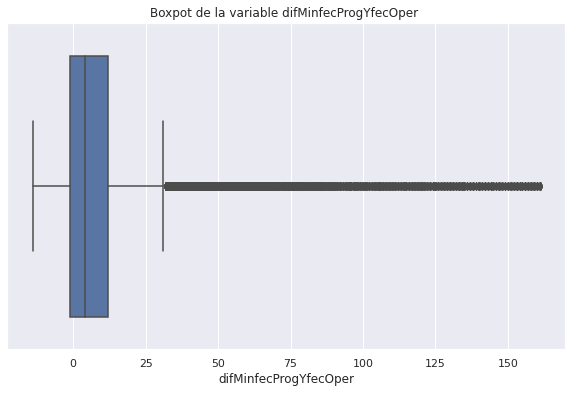

In [ ]:
# Analisis mediante un diagrama de cajas (Boxplot)
plt.figure(figsize=(10,6))
sns.boxplot(dfVuelos['dif_min'])
plt.title("Boxpot de la variable difMinfecProgYfecOper ")
plt.show()

A través del boxplot podemos ver claramente que existen algunos valores a la derecha que pueden no favorecer en el comportamiento habitual de los datos. Veamos un análisis por PERCENTILES

In [ ]:
# Análisis de percentiles
for var in dfVuelos['dif_min']:
  print("Variable: ", var)
  fx_percentiles_en_lista(dfVuelos[var])

Variable:  difMinfecProgYfecOper


,Percentile,Valor
0,0.0,-14.0
1,0.5,-12.0
2,1.0,-11.0
3,2.5,-8.0
4,5.0,-6.0
5,10.0,-4.0
6,25.0,-1.0
7,50.0,4.0
8,75.0,12.0
9,90.0,26.0


Lo que se busca son **grandes variaciones por percentil**. Por ejemplo para esta variable el percentil **98.5** tiene un valor de 86 sin embargo el percentil 100 tiene un valor 161, casi el doble. es decir solo un **1.5%** concentra valores mayores que 86; se observa una ligera variación de un percentil a otro. Este será nuestro criterio para imputar cada variable.

Se analizaron los percentiles de la variable y se definió en base la punto de corte correspondiente:

In [ ]:
clean_outlier_perc(dfVuelos,'dif_min', 0.98)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


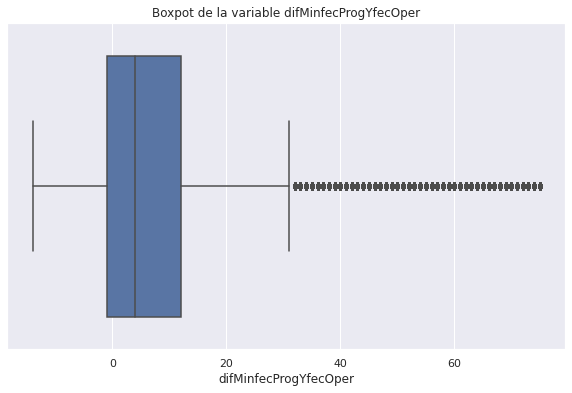

In [ ]:
# Analisis mediante un diagrama de cajas (Boxplot)
plt.figure(figsize=(10,6))
sns.boxplot(dfVuelos['dif_min'])
plt.title("Boxpot de la variable dif_min")
plt.show()

# Analisis de Correlación

In [ ]:
var_cor=list(dataVuelos.columns)

var_cor.remove('fecVueloProg')
var_cor.remove('fecVueloOper')

In [ ]:
dataVuelos.corrwith(dataVuelos["target"])

diaSem                            -0.014448
tipVuelo                           0.096295
difMinfecProgYfecOper              0.789026
target                             1.000000
temporadaAlta                      0.064067
partesDia                          0.043061
cambioNroVuelo                     0.048471
cambioCodAeroVuelo                -0.007762
codAeroVueloProg_LAN              -0.038175
codAeroVueloProg_OTRO              0.037315
codAeroVueloProg_SKU              -0.009673
codAeroVueloProg_TAM               0.039493
codCiudadDestOper_KMIA             0.001902
codCiudadDestOper_LEMD             0.001549
codCiudadDestOper_MMMX            -0.023777
codCiudadDestOper_MPTO            -0.052570
codCiudadDestOper_OTRO             0.009813
codCiudadDestOper_SABE             0.046237
codCiudadDestOper_SACO             0.036912
codCiudadDestOper_SAEZ             0.034367
codCiudadDestOper_SAME             0.035279
codCiudadDestOper_SBGL             0.036736
codCiudadDestOper_SBGR          

Vamos a retirar la variable **difMinfecProgYfecOper** porque el target se calcula a partir de esta

# Modelado

Seleccionando las variables entre data y target

In [ ]:
var_to_select=list(dataVuelos.columns)
var_to_select.remove('target')
var_to_select.remove('fecVueloProg')
var_to_select.remove('fecVueloOper')
var_to_select.remove('difMinfecProgYfecOper')

In [ ]:
list(dataVuelos[var_to_select].columns)

['diaSem',
 'tipVuelo',
 'temporadaAlta',
 'partesDia',
 'cambioNroVuelo',
 'cambioCodAeroVuelo',
 'codAeroVueloProg_LAN',
 'codAeroVueloProg_OTRO',
 'codAeroVueloProg_SKU',
 'codAeroVueloProg_TAM',
 'codCiudadDestOper_KMIA',
 'codCiudadDestOper_LEMD',
 'codCiudadDestOper_MMMX',
 'codCiudadDestOper_MPTO',
 'codCiudadDestOper_OTRO',
 'codCiudadDestOper_SABE',
 'codCiudadDestOper_SACO',
 'codCiudadDestOper_SAEZ',
 'codCiudadDestOper_SAME',
 'codCiudadDestOper_SBGL',
 'codCiudadDestOper_SBGR',
 'codCiudadDestOper_SCAR',
 'codCiudadDestOper_SCAT',
 'codCiudadDestOper_SCBA',
 'codCiudadDestOper_SCCF',
 'codCiudadDestOper_SCCI',
 'codCiudadDestOper_SCDA',
 'codCiudadDestOper_SCFA',
 'codCiudadDestOper_SCIE',
 'codCiudadDestOper_SCQP',
 'codCiudadDestOper_SCSE',
 'codCiudadDestOper_SCTE',
 'codCiudadDestOper_SCVD',
 'codCiudadDestOper_SKBO',
 'codCiudadDestOper_SPJC',
 'codCiudadDestOper_SUMU',
 'codAeroVueloOper_LAN',
 'codAeroVueloOper_LXP',
 'codAeroVueloOper_OTRO',
 'codAeroVueloOper_SKU'

Se separa la variable dependiente de las variables independientes

In [ ]:
X_data = dataVuelos[var_to_select]
y_data = dataVuelos['target']

Se dimensiona el dataset para este modelado inicial 

In [ ]:
y_data.value_counts(normalize=True)

0    0.81506
1    0.18494
Name: target, dtype: float64

## Validación mediante Split Train/Test

Para este ejercicio se utiliza 80% para el train y 20% para el test

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_data,
                                                 y_data,
                                                 train_size = 0.7,
                                                 random_state = 20,
                                                 stratify = y_data)

In [ ]:
print("Distribución del Target en el Train: {:0.4}%".format(100*y_train.mean()))
print("Distribución del Target en el Test: {:0.4}%".format(100*y_test.mean()))

Distribución del Target en el Train: 18.49%
Distribución del Target en el Test: 18.49%


### Arbol de Decision

In [ ]:
tree_cl = DecisionTreeClassifier(max_depth = 4,
                                min_samples_leaf=10,
                                random_state = 1,
                                max_features =5,
                                max_leaf_nodes = 10)

In [ ]:
tree_cl_model = tree_cl.fit(X_train,y_train)

In [ ]:
y_predict = tree_cl_model.predict(X_test)

In [ ]:
confusion_matrix(y_test,y_predict)

array([[16678,     0],
       [ 3784,     0]])

In [ ]:
accuracy_model = accuracy_score(y_test,y_predict)
accuracy_model

0.8150718404848011

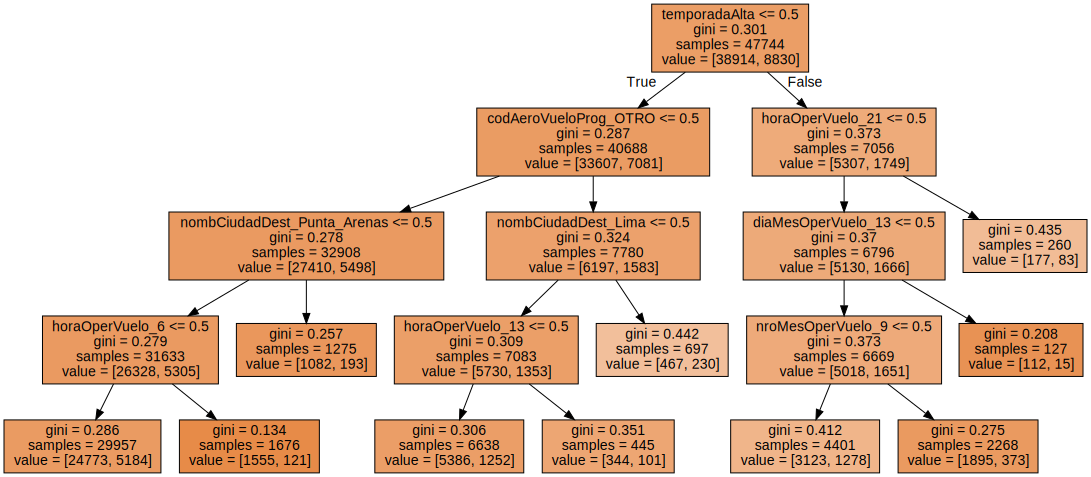

In [ ]:
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

graph = Source(export_graphviz(tree_cl,out_file=None,
                               feature_names=var_to_select,
                              filled=True))
SVG(graph.pipe(format='svg'))

In [ ]:
correlation_heatmap()